**Daily player selection using random forest**


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from termcolor import colored

# Web/database stuff
import urllib.request
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup

# Multiprocessing/threading
import multiprocess
import threading
from threading import Thread

In [6]:
# Web/database stuff
# import urllib.request
# import xml.etree.ElementTree as ET
# from bs4 import BeautifulSoup
import sqlalchemy
import sqlalchemy_utils
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

# Multiprocessing/threading
import multiprocess
import threading   # included in base

In [7]:
# ML
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [8]:
# Code formatting with Jupyter black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [9]:
from pybaseball import pitching_stats
from pybaseball import batting_stats
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup

<IPython.core.display.Javascript object>

# Import data from database

In [10]:
# Define a database name
# Set your postgres username
dbname = "baseball"
username = "lacar"  # change this to your username

<IPython.core.display.Javascript object>

In [11]:
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine("postgres://%s@localhost/%s" % (username, dbname))
print(engine.url)

postgres://lacar@localhost/baseball


<IPython.core.display.Javascript object>

In [12]:
# Working with PostgreSQL in Python
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database=dbname, user=username)

<IPython.core.display.Javascript object>

## Get statcast pitch-by-pitch data

In [13]:
# Get statcast 2015 data
sql_query = """
SELECT * FROM statcast_15 
WHERE statcast_15.events IS NOT NULL;
"""

df_sc_15 = pd.read_sql_query(sql_query, con)

<IPython.core.display.Javascript object>

In [14]:
df_sc_15.shape

(184080, 91)

<IPython.core.display.Javascript object>

In [15]:
# Get statcast 2016 data
sql_query = """
SELECT * FROM statcast_16 
WHERE statcast_16.events IS NOT NULL;
"""

df_sc_16 = pd.read_sql_query(sql_query, con)

<IPython.core.display.Javascript object>

In [16]:
df_sc_16.shape

(182719, 91)

<IPython.core.display.Javascript object>

In [17]:
# Get statcast 2017-19 data
sql_query = """
SELECT * FROM statcast 
WHERE statcast.events IS NOT NULL;
"""

df_sc_171819 = pd.read_sql_query(sql_query, con)

<IPython.core.display.Javascript object>

In [18]:
df_sc_171819.shape

(555396, 91)

<IPython.core.display.Javascript object>

In [19]:
df_sc_all = pd.concat([df_sc_15, df_sc_16, df_sc_171819], axis=0)
df_sc_all.drop(["level_0", "index"], axis=1, inplace=True)
df_sc_all.reset_index(inplace=True)

<IPython.core.display.Javascript object>

In [20]:
df_sc_all.head()

index pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
0      0         SI 2015-10-04           97.2        -1.3222         6.4094   
1      1         SI 2015-10-04           98.4        -1.2591         6.3362   
2      2         SI 2015-10-04           97.7        -1.2283         6.2723   
3      3         SI 2015-10-04           97.6        -1.2410         6.3449   
4      4         SI 2015-10-04           97.7        -2.7596         6.1490   

      player_name    batter   pitcher                     events  ...  \
0  Jeurys Familia  150029.0  544727.0                  field_out  ...   
1  Jeurys Familia  547180.0  544727.0                     double  ...   
2  Jeurys Familia  607208.0  544727.0                  strikeout  ...   
3  Jeurys Familia  543685.0  544727.0                  field_out  ...   
4   Blake Treinen  502517.0  595014.0  grounded_into_double_play  ...   

  home_score away_score bat_score fld_score post_away_score  post_home_score  \
0        1.0        0.0       0.0       1.0             0.0              1.0   
1        1.0        0.0       0.0       1.0             0.0              1.0   
2        1.0        0.0       0.0       1.0             0.0              1.0   
3        1.0        0.0       0.0       1.0             0.0              1.0   
4        1.0        0.0       1.0       0.0             0.0              1.0   

  post_bat_score post_fld_score if_fielding_alignment of_fielding_alignment  
0            0.0            1.0                  None                  None  
1            0.0            1.0              Standard             Strategic  
2            0.0            1.0              Standard              Standard  
3            0.0            1.0              Standard              Standard  
4            1.0            0.0              Standard              Standard  

[5 rows x 90 columns]

<IPython.core.display.Javascript object>

In [687]:
(df_sc_all["batter"] == 544725).sum()

1283

<IPython.core.display.Javascript object>

In [21]:
# Encode events

# All on-base
event_list = ["hit_by_pitch", "walk", "single", "double", "triple", "home_run"]
df_sc_all["onbase_event"] = 0
df_sc_all.loc[df_sc_all["events"].isin(event_list), "onbase_event"] = 1

# Walk
event_list = ["walk"]
df_sc_all["walk_event"] = 0
df_sc_all.loc[df_sc_all["events"].isin(event_list), "walk_event"] = 1

# Singles
event_list = ["single"]
df_sc_all["single_event"] = 0
df_sc_all.loc[df_sc_all["events"].isin(event_list), "single_event"] = 1

# 2B
event_list = ["double"]
df_sc_all["double_event"] = 0
df_sc_all.loc[df_sc_all["events"].isin(event_list), "double_event"] = 1

# 3B
event_list = ["triple"]
df_sc_all["triple_event"] = 0
df_sc_all.loc[df_sc_all["events"].isin(event_list), "triple_event"] = 1

# HR
event_list = ["home_run"]
df_sc_all["homerun_event"] = 0
df_sc_all.loc[df_sc_all["events"].isin(event_list), "homerun_event"] = 1

# strikeout
event_list = ["strikeout"]
df_sc_all["strikeout_event"] = 0
df_sc_all.loc[df_sc_all["events"].isin(event_list), "strikeout_event"] = 1

<IPython.core.display.Javascript object>

## Batter characteristics 

 <<< -------- update app and slides to account for new PA min, removed switch hitters ------- >>>>>>>

In [22]:
# 200 PA, aggregated
df_batting1519agg_200pa = batting_stats(2015, 2019, qual=200, ind=1)


<IPython.core.display.Javascript object>

In [23]:
def get_binned_counts_data_against(index_col, bin_col, df):
    df_counts = (df.groupby([index_col, bin_col]).count()["index"]).unstack()
    df_counts.columns = ["batters_PA_vs_" + bin_col + str(i) for i in df_counts.columns]
    df_counts[df_counts.isna()] = 0
    return df_counts

<IPython.core.display.Javascript object>

In [24]:
def get_binned_batter_counts_data(index_col, bin_col, df):
    df_counts = (df.groupby([index_col, bin_col]).count()["index"]).unstack()
    df_counts.columns = ["batters_PA_as_" + bin_col + str(i) for i in df_counts.columns]
    df_counts[df_counts.isna()] = 0
    return df_counts

<IPython.core.display.Javascript object>

In [25]:
## Filter statcast data to only be hitters with 250 PA

<IPython.core.display.Javascript object>

In [26]:
# Filter statcast data to only be hitters with 250 PA
df_batting_fromsc = pd.DataFrame()
df_batting_fromsc[
    ["batters_PA_as_L", "batters_PA_as_R"]
] = get_binned_batter_counts_data("batter", "stand", df_sc_all.iloc[:, 0:30])

df_batting_fromsc[["PA_vs_LHP", "PA_vs_RHP"]] = get_binned_counts_data_against(
    "batter", "p_throws", df_sc_all.iloc[:, 0:30]
)
df_batting_fromsc["PA"] = df_sc_all.iloc[:, 0:30].groupby("batter").count()["index"]

<IPython.core.display.Javascript object>

In [695]:
df_temp = df_sc_all[df_sc_all["batter"] == 544725]

<IPython.core.display.Javascript object>

In [697]:
df_temp.head()

index pitch_type  game_date  release_speed  release_pos_x  \
1778    1778         FF 2015-10-03           97.2        -2.4321   
14234  14234         FT 2015-09-21           88.8         2.3115   
14250  14250         FT 2015-09-21           87.0         2.3194   
14271  14271         CH 2015-09-21           78.3         2.4391   
18200  18200         FF 2015-09-17           92.6         1.8470   

       release_pos_z     player_name    batter   pitcher     events  ...  \
1778          6.1900   Neftali Feliz  544725.0  491703.0     single  ...   
14234         5.9004      Randy Wolf  544725.0  150116.0  field_out  ...   
14250         5.9828      Randy Wolf  544725.0  150116.0  strikeout  ...   
14271         6.1906      Randy Wolf  544725.0  150116.0  field_out  ...   
18200         6.0673  Sean Doolittle  544725.0  448281.0  field_out  ...   

      post_fld_score if_fielding_alignment of_fielding_alignment onbase_event  \
1778             3.0             Strategic              Standard            1   
14234            2.0              Standard              Standard            0   
14250            2.0              Standard              Standard            0   
14271            0.0              Standard              Standard            0   
18200            1.0              Standard              Standard            0   

      walk_event  single_event double_event triple_event homerun_event  \
1778           0             1            0            0             0   
14234          0             0            0            0             0   
14250          0             0            0            0             0   
14271          0             0            0            0             0   
18200          0             0            0            0             0   

      strikeout_event  
1778                0  
14234               0  
14250               1  
14271               0  
18200               0  

[5 rows x 97 columns]

<IPython.core.display.Javascript object>

In [28]:
# Count number of switch hitters, at least 10% of their PA
bool_switch_hitters = (
    df_batting_fromsc["batters_PA_as_L"] > df_batting_fromsc["PA"] * 0.1
) & (df_batting_fromsc["batters_PA_as_R"] > df_batting_fromsc["PA"] * 0.1)

<IPython.core.display.Javascript object>

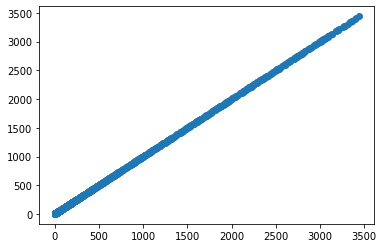

<IPython.core.display.Javascript object>

In [29]:
f, ax1 = plt.subplots()
ax1.scatter(
    df_batting_fromsc["batters_PA_as_L"] + df_batting_fromsc["batters_PA_as_R"],
    df_batting_fromsc["PA"],
)

In [30]:
# Remove switch hitters
df_batting_fromsc = df_batting_fromsc.loc[~bool_switch_hitters, :].copy()

<IPython.core.display.Javascript object>

In [31]:
# Assign stance
df_batting_fromsc["batter_stance"] = "L"
bool_more_RH_at_bats = (
    df_batting_fromsc["batters_PA_as_R"] > df_batting_fromsc["batters_PA_as_L"]
)
df_batting_fromsc.loc[bool_more_RH_at_bats, "batter_stance"] = "R"

<IPython.core.display.Javascript object>

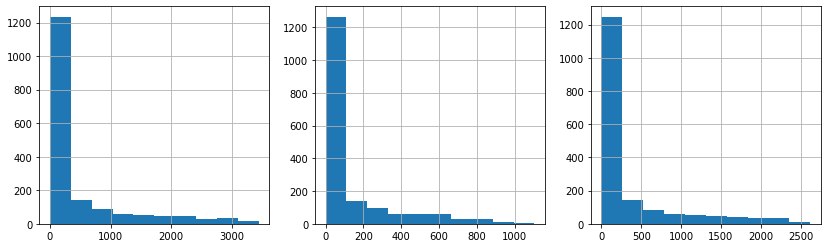

<IPython.core.display.Javascript object>

In [32]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_batting_fromsc["PA"].hist(ax=ax1)
df_batting_fromsc["PA_vs_LHP"].hist(ax=ax2)
df_batting_fromsc["PA_vs_RHP"].hist(ax=ax3)

In [33]:
df_batting_fromsc_250pa = df_batting_fromsc.loc[
    ((df_batting_fromsc["PA_vs_LHP"] > 250) & (df_batting_fromsc["PA_vs_RHP"] > 250)), :
]

<IPython.core.display.Javascript object>

In [34]:
print(
    "No. of batters with >250 PA against LHP and RHP each: ",
    len(df_batting_fromsc_250pa),
)

No. of batters with >250 PA against LHP and RHP each:  315


<IPython.core.display.Javascript object>

In [690]:
# Checking an index
(df_batting_fromsc_250pa.index == 120074).sum()

1

<IPython.core.display.Javascript object>

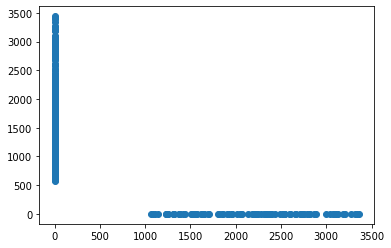

<IPython.core.display.Javascript object>

In [36]:
# Verification of switch hitter removal
plt.scatter(
    df_batting_fromsc_250pa["batters_PA_as_L"],
    df_batting_fromsc_250pa["batters_PA_as_R"],
)

In [37]:
df_batting_fromsc_250pa.head()

batters_PA_as_L  batters_PA_as_R  PA_vs_LHP  PA_vs_RHP    PA  \
batter                                                                   
120074.0           1233.0              1.0      334.0      900.0  1234   
121347.0              0.0            866.0      277.0      589.0   866   
134181.0              0.0           2127.0      592.0     1535.0  2127   
150029.0              0.0           1274.0      280.0      994.0  1274   
400284.0           1525.0              0.0      253.0     1272.0  1525   

         batter_stance  
batter                  
120074.0             L  
121347.0             R  
134181.0             R  
150029.0             R  
400284.0             L

<IPython.core.display.Javascript object>

In [38]:
# Get proportion of counts for each event (on-base, walk, single, etc...)

<IPython.core.display.Javascript object>

In [39]:
def get_prop_event_data(index_col, bin_col, event, df):
    #     df_counts = (df.groupby([index_col, bin_col]).count()["index"]).unstack()
    #     df_counts.columns = ["PA_vs_" + bin_col + str(i) for i in df_counts.columns]
    df_event_mean = (df.groupby([index_col, bin_col]).mean()[event]).unstack()
    df_event_mean.columns = [
        "prop_" + event + "_" + bin_col + "_" + str(i) for i in df_event_mean.columns
    ]
    df_event_mean["prop_" + event + "_overall"] = df.groupby([index_col]).mean()[event]
    # df_binned = pd.merge(df_counts, df_event_mean, left_index=True, right_index=True)
    return df_event_mean

<IPython.core.display.Javascript object>

In [40]:
# del df_batting_fromsc_250pa_prop_events

<IPython.core.display.Javascript object>

In [41]:
df_temp = get_prop_event_data("batter", "p_throws", "onbase_event", df_sc_all)
df_batting_fromsc_250pa_prop_events = pd.merge(
    df_batting_fromsc_250pa, df_temp, left_index=True, right_index=True
)

# Note change in left table to merge - all other events will be added in
df_temp = get_prop_event_data("batter", "p_throws", "walk_event", df_sc_all)
df_batting_fromsc_250pa_prop_events = pd.merge(
    df_batting_fromsc_250pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("batter", "p_throws", "single_event", df_sc_all)
df_batting_fromsc_250pa_prop_events = pd.merge(
    df_batting_fromsc_250pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("batter", "p_throws", "double_event", df_sc_all)
df_batting_fromsc_250pa_prop_events = pd.merge(
    df_batting_fromsc_250pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("batter", "p_throws", "triple_event", df_sc_all)
df_batting_fromsc_250pa_prop_events = pd.merge(
    df_batting_fromsc_250pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("batter", "p_throws", "homerun_event", df_sc_all)
df_batting_fromsc_250pa_prop_events = pd.merge(
    df_batting_fromsc_250pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("batter", "p_throws", "strikeout_event", df_sc_all)
df_batting_fromsc_250pa_prop_events = pd.merge(
    df_batting_fromsc_250pa_prop_events, df_temp, left_index=True, right_index=True
)

<IPython.core.display.Javascript object>

In [42]:
df_batting_fromsc_250pa_prop_events.shape

(315, 27)

<IPython.core.display.Javascript object>

In [43]:
df_batting_fromsc_250pa_prop_events.head()

batters_PA_as_L  batters_PA_as_R  PA_vs_LHP  PA_vs_RHP    PA  \
batter                                                                   
120074.0           1233.0              1.0      334.0      900.0  1234   
121347.0              0.0            866.0      277.0      589.0   866   
134181.0              0.0           2127.0      592.0     1535.0  2127   
150029.0              0.0           1274.0      280.0      994.0  1274   
400284.0           1525.0              0.0      253.0     1272.0  1525   

         batter_stance  prop_onbase_event_p_throws_L  \
batter                                                 
120074.0             L                      0.320359   
121347.0             R                      0.335740   
134181.0             R                      0.373311   
150029.0             R                      0.357143   
400284.0             L                      0.252964   

          prop_onbase_event_p_throws_R  prop_onbase_event_overall  \
batter                                                              
120074.0                      0.368889                   0.355754   
121347.0                      0.310696                   0.318707   
134181.0                      0.330293                   0.342266   
150029.0                      0.310865                   0.321036   
400284.0                      0.315252                   0.304918   

          prop_walk_event_p_throws_L  ...  prop_double_event_overall  \
batter                                ...                              
120074.0                    0.080838  ...                   0.068882   
121347.0                    0.115523  ...                   0.033487   
134181.0                    0.094595  ...                   0.050776   
150029.0                    0.114286  ...                   0.042386   
400284.0                    0.071146  ...                   0.050492   

          prop_triple_event_p_throws_L  prop_triple_event_p_throws_R  \
batter                                                                 
120074.0                      0.000000                      0.001111   
121347.0                      0.003610                      0.000000   
134181.0                      0.006757                      0.001954   
150029.0                      0.000000                      0.002012   
400284.0                      0.003953                      0.007075   

          prop_triple_event_overall  prop_homerun_event_p_throws_L  \
batter                                                               
120074.0                   0.000810                       0.038922   
121347.0                   0.001155                       0.046931   
134181.0                   0.003291                       0.043919   
150029.0                   0.001570                       0.057143   
400284.0                   0.006557                       0.015810   

          prop_homerun_event_p_throws_R  prop_homerun_event_overall  \
batter                                                                
120074.0                       0.068889                    0.060778   
121347.0                       0.049236                    0.048499   
134181.0                       0.036482                    0.038552   
150029.0                       0.027163                    0.033752   
400284.0                       0.021226                    0.020328   

          prop_strikeout_event_p_throws_L  prop_strikeout_event_p_throws_R  \
batter                                                                       
120074.0                         0.176647                         0.131111   
121347.0                         0.252708                         0.241087   
134181.0                         0.130068                         0.130293   
150029.0                         0.210714                         0.231388   
400284.0                         0.225296                         0.165881   

          prop_strikeout_event_overall  
batter                     

<IPython.core.display.Javascript object>

### Represent handedness of opposing pitcher explicitly

In [44]:
same_hand_colnames = [
    "prop_onbase_event_p_throws_same",
    "prop_walk_event_p_throws_same",
    "prop_single_event_p_throws_same",
    "prop_double_event_p_throws_same",
    "prop_triple_event_p_throws_same",
    "prop_homerun_event_p_throws_same",
    "prop_strikeout_event_p_throws_same",
]

diff_hand_colnames = [
    "prop_onbase_event_p_throws_diff",
    "prop_walk_event_p_throws_diff",
    "prop_single_event_p_throws_diff",
    "prop_double_event_p_throws_diff",
    "prop_triple_event_p_throws_diff",
    "prop_homerun_event_p_throws_diff",
    "prop_strikeout_event_p_throws_diff",
]

for colname2start in same_hand_colnames + diff_hand_colnames:
    df_batting_fromsc_250pa_prop_events[colname2start] = None

<IPython.core.display.Javascript object>

In [45]:
# Add same different columns of proportions for each batter
for b_index in df_batting_fromsc_250pa_prop_events.index.tolist():
    # print(b_index)
    same_hand = df_batting_fromsc_250pa_prop_events.loc[b_index, "batter_stance"][0]
    diff_hand = list(set(["L", "R"]) - set(same_hand))[0]

    # Same / diff handedness
    same_hand_col = df_batting_fromsc_250pa_prop_events.columns.str.contains(
        "p_throws_" + same_hand
    )
    same_hand_prop_info = df_batting_fromsc_250pa_prop_events.loc[
        b_index, same_hand_col
    ]
    same_hand_prop_info.index = same_hand_prop_info.index.str.replace(same_hand, "same")

    diff_hand_col = df_batting_fromsc_250pa_prop_events.columns.str.contains(
        "p_throws_" + diff_hand
    )
    diff_hand_prop_info = df_batting_fromsc_250pa_prop_events.loc[
        b_index, diff_hand_col
    ]
    diff_hand_prop_info.index = diff_hand_prop_info.index.str.replace(diff_hand, "diff")

    # Add to dataframe
    df_batting_fromsc_250pa_prop_events.loc[
        b_index, same_hand_prop_info.index.tolist()
    ] = same_hand_prop_info
    df_batting_fromsc_250pa_prop_events.loc[
        b_index, diff_hand_prop_info.index.tolist()
    ] = diff_hand_prop_info

    # print("      ", same_hand, diff_hand)

<IPython.core.display.Javascript object>

In [46]:
df_batting_fromsc_250pa_prop_events.head()

batters_PA_as_L  batters_PA_as_R  PA_vs_LHP  PA_vs_RHP    PA  \
batter                                                                   
120074.0           1233.0              1.0      334.0      900.0  1234   
121347.0              0.0            866.0      277.0      589.0   866   
134181.0              0.0           2127.0      592.0     1535.0  2127   
150029.0              0.0           1274.0      280.0      994.0  1274   
400284.0           1525.0              0.0      253.0     1272.0  1525   

         batter_stance  prop_onbase_event_p_throws_L  \
batter                                                 
120074.0             L                      0.320359   
121347.0             R                      0.335740   
134181.0             R                      0.373311   
150029.0             R                      0.357143   
400284.0             L                      0.252964   

          prop_onbase_event_p_throws_R  prop_onbase_event_overall  \
batter                                                              
120074.0                      0.368889                   0.355754   
121347.0                      0.310696                   0.318707   
134181.0                      0.330293                   0.342266   
150029.0                      0.310865                   0.321036   
400284.0                      0.315252                   0.304918   

          prop_walk_event_p_throws_L  ...  prop_triple_event_p_throws_same  \
batter                                ...                                    
120074.0                    0.080838  ...                                0   
121347.0                    0.115523  ...                                0   
134181.0                    0.094595  ...                        0.0019544   
150029.0                    0.114286  ...                       0.00201207   
400284.0                    0.071146  ...                       0.00395257   

          prop_homerun_event_p_throws_same  \
batter                                       
120074.0                         0.0389222   
121347.0                          0.049236   
134181.0                         0.0364821   
150029.0                          0.027163   
400284.0                         0.0158103   

          prop_strikeout_event_p_throws_same  prop_onbase_event_p_throws_diff  \
batter                                                                          
120074.0                            0.176647                         0.368889   
121347.0                            0.241087                          0.33574   
134181.0                            0.130293                         0.373311   
150029.0                            0.231388                         0.357143   
400284.0                            0.225296                         0.315252   

          prop_walk_event_p_throws_diff  prop_single_event_p_throws_diff  \
batter                                                                     
120074.0                       0.108889                         0.112222   
121347.0                       0.115523                         0.104693   
134181.0                      0.0945946                         0.173986   
150029.0                       0.114286                         0.110714   
400284.0                      0.0754717                         0.138365   

          prop_double_event_p_throws_diff  prop_triple_event_p_throws_diff  \
batter                                                                       
120074.0                        0.0755556                       0.00111111   
121347.0                        0.0505415                       0.00361011   
134181.0                        0.0489865                       0.00675676   
150029.0                        0.0714286                                0   
400284.0                        0.0518868                       0.00707547   

          prop_homerun_event_p_throws_diff  prop_strikeout_event_p_throws_diff  
batter         

<IPython.core.display.Javascript object>

## Pitching characteristics


< ------ use only data with minimum number of plate appearances but allow all batters/pitchers and just put warning if they're less than 250/500 ------> 

In [47]:
def get_binned_pitcher_counts_data(index_col, bin_col, df):
    """
    Represent handedness of the pitcher by counting at-bats with that hand
    """
    df_counts = (df.groupby([index_col, bin_col]).count()["index"]).unstack()
    df_counts.columns = [
        "pitchers_PA_as_" + bin_col + str(i) for i in df_counts.columns
    ]
    df_counts[df_counts.isna()] = 0
    return df_counts

<IPython.core.display.Javascript object>

In [48]:
# Filter statcast data to only be pitchers with 500 PA for each hand
df_pitching_fromsc = pd.DataFrame()

df_pitching_fromsc[
    ["pitchers_PA_as_L", "pitchers_PA_as_R"]
] = get_binned_pitcher_counts_data("pitcher", "p_throws", df_sc_all.iloc[:, 0:30])

df_pitching_fromsc[
    ["pitcher_PA_vs_LHB", "pitcher_PA_vs_RHB"]
] = get_binned_counts_data_against("pitcher", "stand", df_sc_all.iloc[:, 0:30])

df_pitching_fromsc["pitcher_PA"] = (
    df_sc_all.iloc[:, 0:30].groupby("pitcher").count()["index"]
)

<IPython.core.display.Javascript object>

In [49]:
# Assign throwing hand
df_pitching_fromsc['pitchers_throwing_hand'] = 'L'
bool_more_RH_p_throws = (
    df_pitching_fromsc['pitchers_PA_as_R'] > df_pitching_fromsc['pitchers_PA_as_L']
)
df_pitching_fromsc.loc[bool_more_RH_p_throws, 'pitchers_throwing_hand'] = 'R'


<IPython.core.display.Javascript object>

In [50]:
df_pitching_fromsc.head()

pitchers_PA_as_L  pitchers_PA_as_R  pitcher_PA_vs_LHB  \
pitcher                                                           
112526.0               0.0            2869.0             1422.0   
115629.0               0.0             162.0               81.0   
136600.0              35.0               0.0               12.0   
150116.0             162.0               0.0               30.0   
150274.0               0.0              29.0               10.0   

          pitcher_PA_vs_RHB  pitcher_PA pitchers_throwing_hand  
pitcher                                                         
112526.0             1447.0        2869                      R  
115629.0               81.0         162                      R  
136600.0               23.0          35                      L  
150116.0              132.0         162                      L  
150274.0               19.0          29                      R

<IPython.core.display.Javascript object>

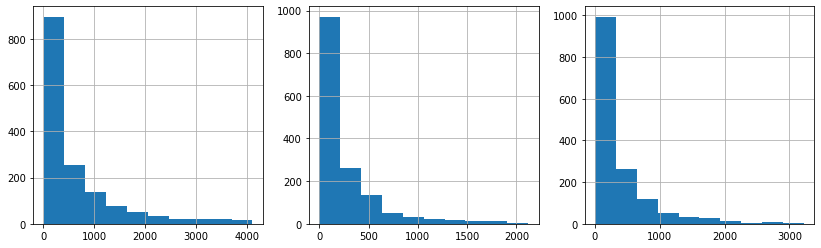

<IPython.core.display.Javascript object>

In [51]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_pitching_fromsc["pitcher_PA"].hist(ax=ax1)
df_pitching_fromsc["pitcher_PA_vs_LHB"].hist(ax=ax2)
df_pitching_fromsc["pitcher_PA_vs_RHB"].hist(ax=ax3)

In [52]:
df_pitching_fromsc_500pa = df_pitching_fromsc.loc[
    (
        (df_pitching_fromsc["pitcher_PA_vs_LHB"] > 500)
        & (df_pitching_fromsc["pitcher_PA_vs_RHB"] > 500)
    ),
    :,
]

<IPython.core.display.Javascript object>

In [53]:
print(
    "No. of pitchers with >500 PA against LHB and RHB each: ",
    len(df_pitching_fromsc_500pa),
)

No. of pitchers with >500 PA against LHB and RHB each:  230


<IPython.core.display.Javascript object>

In [54]:
# del df_pitching_fromsc_500pa_prop_events

<IPython.core.display.Javascript object>

In [55]:
df_temp = get_prop_event_data("pitcher", "stand", "onbase_event", df_sc_all)
df_pitching_fromsc_500pa_prop_events = pd.merge(
    df_pitching_fromsc_500pa, df_temp, left_index=True, right_index=True
)

# Note change in left table to merge - all other events will be added in
df_temp = get_prop_event_data("pitcher", "stand", "walk_event", df_sc_all)
df_pitching_fromsc_500pa_prop_events = pd.merge(
    df_pitching_fromsc_500pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("pitcher", "stand", "single_event", df_sc_all)
df_pitching_fromsc_500pa_prop_events = pd.merge(
    df_pitching_fromsc_500pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("pitcher", "stand", "double_event", df_sc_all)
df_pitching_fromsc_500pa_prop_events = pd.merge(
    df_pitching_fromsc_500pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("pitcher", "stand", "triple_event", df_sc_all)
df_pitching_fromsc_500pa_prop_events = pd.merge(
    df_pitching_fromsc_500pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("pitcher", "stand", "homerun_event", df_sc_all)
df_pitching_fromsc_500pa_prop_events = pd.merge(
    df_pitching_fromsc_500pa_prop_events, df_temp, left_index=True, right_index=True
)

df_temp = get_prop_event_data("pitcher", "stand", "strikeout_event", df_sc_all)
df_pitching_fromsc_500pa_prop_events = pd.merge(
    df_pitching_fromsc_500pa_prop_events, df_temp, left_index=True, right_index=True
)

<IPython.core.display.Javascript object>

In [56]:
print("pitching df shape: ", df_pitching_fromsc_500pa_prop_events.shape)
df_pitching_fromsc_500pa_prop_events.head()

pitching df shape:  (230, 27)


pitchers_PA_as_L  pitchers_PA_as_R  pitcher_PA_vs_LHB  \
pitcher                                                           
112526.0               0.0            2869.0             1422.0   
282332.0            3255.0               0.0              635.0   
285079.0               0.0            2430.0             1096.0   
407793.0               0.0            2375.0             1089.0   
407845.0               0.0            1282.0              633.0   

          pitcher_PA_vs_RHB  pitcher_PA pitchers_throwing_hand  \
pitcher                                                          
112526.0             1447.0        2869                      R   
282332.0             2620.0        3255                      L   
285079.0             1334.0        2430                      R   
407793.0             1286.0        2375                      R   
407845.0              649.0        1282                      R   

          prop_onbase_event_stand_L  prop_onbase_event_stand_R  \
pitcher                                                          
112526.0                   0.315752                   0.308224   
282332.0                   0.294488                   0.327481   
285079.0                   0.304745                   0.327586   
407793.0                   0.326905                   0.265163   
407845.0                   0.336493                   0.322034   

          prop_onbase_event_overall  prop_walk_event_stand_L  ...  \
pitcher                                                       ...   
112526.0                   0.311955                 0.047117  ...   
282332.0                   0.321045                 0.085039  ...   
285079.0                   0.317284                 0.082117  ...   
407793.0                   0.293474                 0.084481  ...   
407845.0                   0.329173                 0.126382  ...   

          prop_double_event_overall  prop_triple_event_stand_L  \
pitcher                                                          
112526.0                   0.056466                   0.008439   
282332.0                   0.036866                   0.003150   
285079.0                   0.050206                   0.006387   
407793.0                   0.036632                   0.003673   
407845.0                   0.033541                   0.001580   

          prop_triple_event_stand_R  prop_triple_event_overall  \
pitcher                                                          
112526.0                   0.006911                   0.007668   
282332.0                   0.003053                   0.003072   
285079.0                   0.008246                   0.007407   
407793.0                   0.001555                   0.002526   
407845.0                   0.001541                   0.001560   

          prop_homerun_event_stand_L  prop_homerun_event_stand_R  \
pitcher                                                            
112526.0                    0.034459                    0.040774   
282332.0                    0.029921                    0.037405   
285079.0                    0.031934                    0.032984   
407793.0                    0.034894                    0.032659   
407845.0                    0.023697                    0.021572   

          prop_homerun_event_overall  prop_strikeout_event_stand_L  \
pitcher                                                              
112526.0                    0.037644                      0.143460   
282332.0                    0.035945                      0.251969   
285079.0                    0.032510                      0.142336   
407793.0                    0.033684                      0.166208   
407845.0                    0.022621                      0.271722   

          prop_strikeout_event_stand_R  prop_strikeout_event_overall  
pitcher                                                               
112526.0                      0.154112                      0.148832  
282332.0               

<IPython.core.display.Javascript object>

### Represent handedness of opposing batter explicitly

In [57]:
same_bhand_colnames = [
    "prop_onbase_event_stand_same",
    "prop_walk_event_stand_same",
    "prop_single_event_stand_same",
    "prop_double_event_stand_same",
    "prop_triple_event_stand_same",
    "prop_homerun_event_stand_same",
    "prop_strikeout_event_stand_same",
]

diff_bhand_colnames = [
    "prop_onbase_event_stand_diff",
    "prop_walk_event_stand_diff",
    "prop_single_event_stand_diff",
    "prop_double_event_stand_diff",
    "prop_triple_event_stand_diff",
    "prop_homerun_event_stand_diff",
    "prop_strikeout_event_stand_diff",
]

for colname2start in same_bhand_colnames + diff_bhand_colnames:
    df_pitching_fromsc_500pa_prop_events[colname2start] = None

<IPython.core.display.Javascript object>

In [58]:
df_pitching_fromsc_500pa_prop_events.head()

pitchers_PA_as_L  pitchers_PA_as_R  pitcher_PA_vs_LHB  \
pitcher                                                           
112526.0               0.0            2869.0             1422.0   
282332.0            3255.0               0.0              635.0   
285079.0               0.0            2430.0             1096.0   
407793.0               0.0            2375.0             1089.0   
407845.0               0.0            1282.0              633.0   

          pitcher_PA_vs_RHB  pitcher_PA pitchers_throwing_hand  \
pitcher                                                          
112526.0             1447.0        2869                      R   
282332.0             2620.0        3255                      L   
285079.0             1334.0        2430                      R   
407793.0             1286.0        2375                      R   
407845.0              649.0        1282                      R   

          prop_onbase_event_stand_L  prop_onbase_event_stand_R  \
pitcher                                                          
112526.0                   0.315752                   0.308224   
282332.0                   0.294488                   0.327481   
285079.0                   0.304745                   0.327586   
407793.0                   0.326905                   0.265163   
407845.0                   0.336493                   0.322034   

          prop_onbase_event_overall  prop_walk_event_stand_L  ...  \
pitcher                                                       ...   
112526.0                   0.311955                 0.047117  ...   
282332.0                   0.321045                 0.085039  ...   
285079.0                   0.317284                 0.082117  ...   
407793.0                   0.293474                 0.084481  ...   
407845.0                   0.329173                 0.126382  ...   

          prop_triple_event_stand_same  prop_homerun_event_stand_same  \
pitcher                                                                 
112526.0                          None                           None   
282332.0                          None                           None   
285079.0                          None                           None   
407793.0                          None                           None   
407845.0                          None                           None   

          prop_strikeout_event_stand_same  prop_onbase_event_stand_diff  \
pitcher                                                                   
112526.0                             None                          None   
282332.0                             None                          None   
285079.0                             None                          None   
407793.0                             None                          None   
407845.0                             None                          None   

          prop_walk_event_stand_diff  prop_single_event_stand_diff  \
pitcher                                                              
112526.0                        None                          None   
282332.0                        None                          None   
285079.0                        None                          None   
407793.0                        None                          None   
407845.0                        None                          None   

          prop_double_event_stand_diff  prop_triple_event_stand_diff  \
pitcher                                                                
112526.0                          None                          None   
282332.0                          None                          None   
285079.0                          None                          None   
407793.0                          None                          None   
407845.0                          None                          None   

          prop_homerun_event_stand_diff  prop_strikeout_event_stand_diff  
pitcher              

<IPython.core.display.Javascript object>

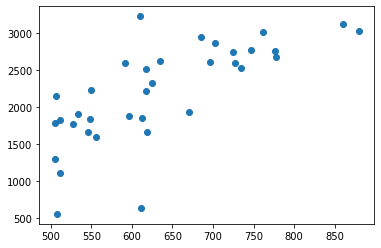

<IPython.core.display.Javascript object>

In [59]:
# LHP still throw more to RHBs
df_temp = df_pitching_fromsc_500pa_prop_events[
    df_pitching_fromsc_500pa_prop_events["pitchers_throwing_hand"] == "L"
].copy()

plt.scatter(df_temp["pitcher_PA_vs_LHB"], df_temp["pitcher_PA_vs_RHB"])

In [60]:
# Add same different columns of proportions for each batter
for p_index in df_pitching_fromsc_500pa_prop_events.index.tolist():
    # print(p_index)
    same_hand = df_pitching_fromsc_500pa_prop_events.loc[
        p_index, "pitchers_throwing_hand"
    ][0]
    diff_hand = list(set(["L", "R"]) - set(same_hand))[0]

    # Same / diff handedness
    same_hand_col = df_pitching_fromsc_500pa_prop_events.columns.str.contains(
        "stand_" + same_hand
    )
    same_hand_prop_info = df_pitching_fromsc_500pa_prop_events.loc[
        p_index, same_hand_col
    ]
    same_hand_prop_info.index = same_hand_prop_info.index.str.replace(same_hand, "same")

    diff_hand_col = df_pitching_fromsc_500pa_prop_events.columns.str.contains(
        "stand_" + diff_hand
    )
    diff_hand_prop_info = df_pitching_fromsc_500pa_prop_events.loc[
        p_index, diff_hand_col
    ]
    diff_hand_prop_info.index = diff_hand_prop_info.index.str.replace(diff_hand, "diff")

    # Add to dataframe
    df_pitching_fromsc_500pa_prop_events.loc[
        p_index, same_hand_prop_info.index.tolist()
    ] = same_hand_prop_info
    df_pitching_fromsc_500pa_prop_events.loc[
        p_index, diff_hand_prop_info.index.tolist()
    ] = diff_hand_prop_info

    # print("      ", same_hand, diff_hand)

<IPython.core.display.Javascript object>

In [61]:
df_pitching_fromsc_500pa_prop_events.head()

pitchers_PA_as_L  pitchers_PA_as_R  pitcher_PA_vs_LHB  \
pitcher                                                           
112526.0               0.0            2869.0             1422.0   
282332.0            3255.0               0.0              635.0   
285079.0               0.0            2430.0             1096.0   
407793.0               0.0            2375.0             1089.0   
407845.0               0.0            1282.0              633.0   

          pitcher_PA_vs_RHB  pitcher_PA pitchers_throwing_hand  \
pitcher                                                          
112526.0             1447.0        2869                      R   
282332.0             2620.0        3255                      L   
285079.0             1334.0        2430                      R   
407793.0             1286.0        2375                      R   
407845.0              649.0        1282                      R   

          prop_onbase_event_stand_L  prop_onbase_event_stand_R  \
pitcher                                                          
112526.0                   0.315752                   0.308224   
282332.0                   0.294488                   0.327481   
285079.0                   0.304745                   0.327586   
407793.0                   0.326905                   0.265163   
407845.0                   0.336493                   0.322034   

          prop_onbase_event_overall  prop_walk_event_stand_L  ...  \
pitcher                                                       ...   
112526.0                   0.311955                 0.047117  ...   
282332.0                   0.321045                 0.085039  ...   
285079.0                   0.317284                 0.082117  ...   
407793.0                   0.293474                 0.084481  ...   
407845.0                   0.329173                 0.126382  ...   

          prop_triple_event_stand_same  prop_homerun_event_stand_same  \
pitcher                                                                 
112526.0                    0.00691085                       0.040774   
282332.0                    0.00314961                      0.0299213   
285079.0                    0.00824588                      0.0329835   
407793.0                    0.00155521                      0.0326594   
407845.0                    0.00154083                      0.0215716   

          prop_strikeout_event_stand_same  prop_onbase_event_stand_diff  \
pitcher                                                                   
112526.0                         0.154112                      0.315752   
282332.0                         0.251969                      0.327481   
285079.0                         0.173913                      0.304745   
407793.0                         0.250389                      0.326905   
407845.0                         0.218798                      0.336493   

          prop_walk_event_stand_diff  prop_single_event_stand_diff  \
pitcher                                                              
112526.0                   0.0471167                      0.164557   
282332.0                   0.0748092                      0.166031   
285079.0                   0.0821168                       0.12865   
407793.0                   0.0844812                      0.155188   
407845.0                    0.126382                       0.14218   

          prop_double_event_stand_diff  prop_triple_event_stand_diff  \
pitcher                                                                
112526.0                     0.0576653                    0.00843882   
282332.0                     0.0408397                    0.00305344   
285079.0                     0.0474453                    0.00638686   
407793.0                     0.0394858                    0.00367309   
407845.0                     0.0315956                    0.00157978   

          prop_homerun_event_stand_diff  prop_strikeout_event_stand_diff  
pitcher              

<IPython.core.display.Javascript object>

# Exploratory data 

### Plots showing distribution of batter quality

onbase, single, double, 
triple, homerun, strikeout

In [62]:
df_batting_fromsc_250pa_prop_events.head()

batters_PA_as_L  batters_PA_as_R  PA_vs_LHP  PA_vs_RHP    PA  \
batter                                                                   
120074.0           1233.0              1.0      334.0      900.0  1234   
121347.0              0.0            866.0      277.0      589.0   866   
134181.0              0.0           2127.0      592.0     1535.0  2127   
150029.0              0.0           1274.0      280.0      994.0  1274   
400284.0           1525.0              0.0      253.0     1272.0  1525   

         batter_stance  prop_onbase_event_p_throws_L  \
batter                                                 
120074.0             L                      0.320359   
121347.0             R                      0.335740   
134181.0             R                      0.373311   
150029.0             R                      0.357143   
400284.0             L                      0.252964   

          prop_onbase_event_p_throws_R  prop_onbase_event_overall  \
batter                                                              
120074.0                      0.368889                   0.355754   
121347.0                      0.310696                   0.318707   
134181.0                      0.330293                   0.342266   
150029.0                      0.310865                   0.321036   
400284.0                      0.315252                   0.304918   

          prop_walk_event_p_throws_L  ...  prop_triple_event_p_throws_same  \
batter                                ...                                    
120074.0                    0.080838  ...                                0   
121347.0                    0.115523  ...                                0   
134181.0                    0.094595  ...                        0.0019544   
150029.0                    0.114286  ...                       0.00201207   
400284.0                    0.071146  ...                       0.00395257   

          prop_homerun_event_p_throws_same  \
batter                                       
120074.0                         0.0389222   
121347.0                          0.049236   
134181.0                         0.0364821   
150029.0                          0.027163   
400284.0                         0.0158103   

          prop_strikeout_event_p_throws_same  prop_onbase_event_p_throws_diff  \
batter                                                                          
120074.0                            0.176647                         0.368889   
121347.0                            0.241087                          0.33574   
134181.0                            0.130293                         0.373311   
150029.0                            0.231388                         0.357143   
400284.0                            0.225296                         0.315252   

          prop_walk_event_p_throws_diff  prop_single_event_p_throws_diff  \
batter                                                                     
120074.0                       0.108889                         0.112222   
121347.0                       0.115523                         0.104693   
134181.0                      0.0945946                         0.173986   
150029.0                       0.114286                         0.110714   
400284.0                      0.0754717                         0.138365   

          prop_double_event_p_throws_diff  prop_triple_event_p_throws_diff  \
batter                                                                       
120074.0                        0.0755556                       0.00111111   
121347.0                        0.0505415                       0.00361011   
134181.0                        0.0489865                       0.00675676   
150029.0                        0.0714286                                0   
400284.0                        0.0518868                       0.00707547   

          prop_homerun_event_p_throws_diff  prop_strikeout_event_p_throws_diff  
batter         

<IPython.core.display.Javascript object>

In [63]:
print("No. of batters of each hand")
df_batting_fromsc_250pa_prop_events.groupby("batter_stance").count().iloc[:, 0]

No. of batters of each hand


batter_stance
L     93
R    222
Name: batters_PA_as_L, dtype: int64

<IPython.core.display.Javascript object>

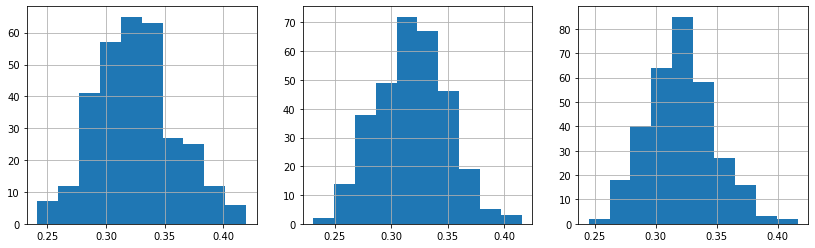

<IPython.core.display.Javascript object>

In [64]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_batting_fromsc_250pa_prop_events["prop_onbase_event_p_throws_L"].hist(ax=ax1)
df_batting_fromsc_250pa_prop_events["prop_onbase_event_p_throws_R"].hist(ax=ax2)
df_batting_fromsc_250pa_prop_events["prop_onbase_event_overall"].hist(ax=ax3)

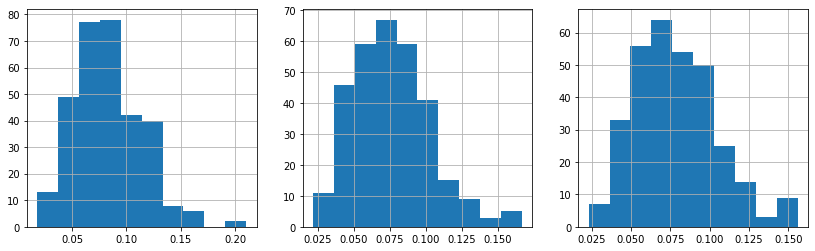

<IPython.core.display.Javascript object>

In [65]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_batting_fromsc_250pa_prop_events["prop_walk_event_p_throws_L"].hist(ax=ax1)
df_batting_fromsc_250pa_prop_events["prop_walk_event_p_throws_R"].hist(ax=ax2)
df_batting_fromsc_250pa_prop_events["prop_walk_event_overall"].hist(ax=ax3)

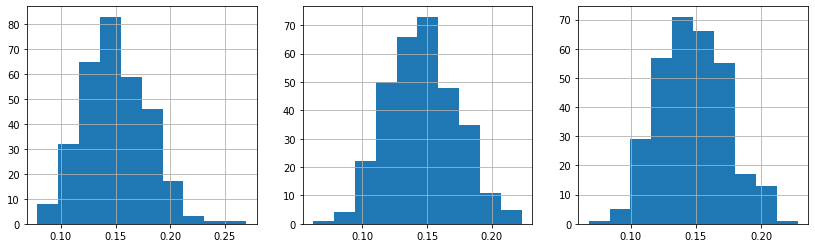

<IPython.core.display.Javascript object>

In [66]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_batting_fromsc_250pa_prop_events["prop_single_event_p_throws_L"].hist(ax=ax1)
df_batting_fromsc_250pa_prop_events["prop_single_event_p_throws_R"].hist(ax=ax2)
df_batting_fromsc_250pa_prop_events["prop_single_event_overall"].hist(ax=ax3)

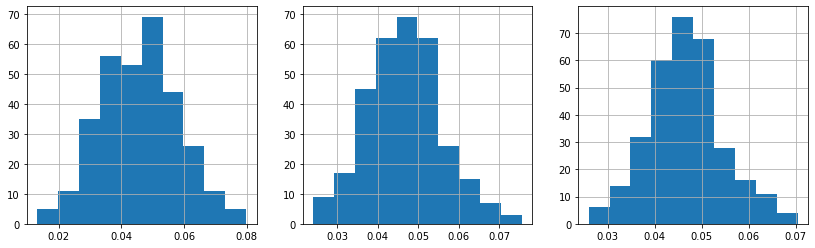

<IPython.core.display.Javascript object>

In [67]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_batting_fromsc_250pa_prop_events["prop_double_event_p_throws_L"].hist(ax=ax1)
df_batting_fromsc_250pa_prop_events["prop_double_event_p_throws_R"].hist(ax=ax2)
df_batting_fromsc_250pa_prop_events["prop_double_event_overall"].hist(ax=ax3)

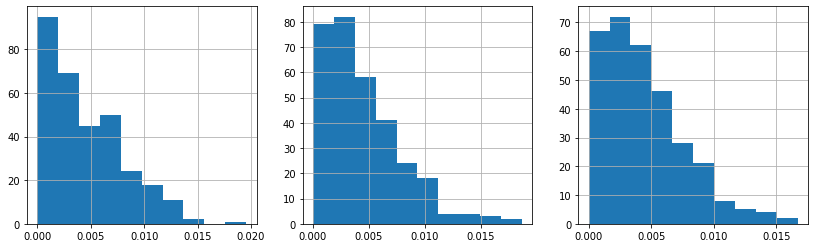

<IPython.core.display.Javascript object>

In [68]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_batting_fromsc_250pa_prop_events["prop_triple_event_p_throws_L"].hist(ax=ax1)
df_batting_fromsc_250pa_prop_events["prop_triple_event_p_throws_R"].hist(ax=ax2)
df_batting_fromsc_250pa_prop_events["prop_triple_event_overall"].hist(ax=ax3)

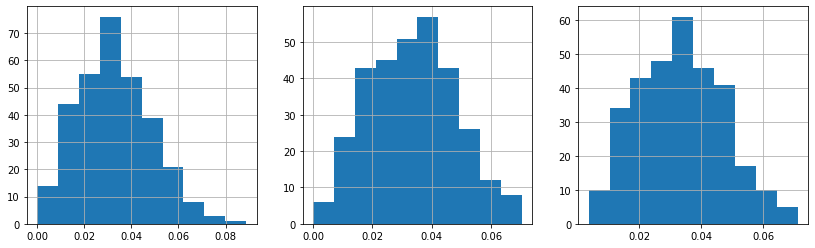

<IPython.core.display.Javascript object>

In [69]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_batting_fromsc_250pa_prop_events["prop_homerun_event_p_throws_L"].hist(ax=ax1)
df_batting_fromsc_250pa_prop_events["prop_homerun_event_p_throws_R"].hist(ax=ax2)
df_batting_fromsc_250pa_prop_events["prop_homerun_event_overall"].hist(ax=ax3)

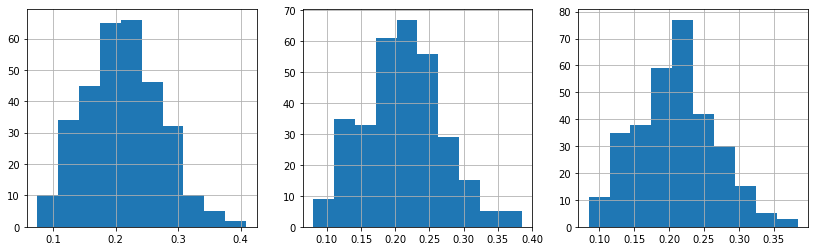

<IPython.core.display.Javascript object>

In [70]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_batting_fromsc_250pa_prop_events["prop_strikeout_event_p_throws_L"].hist(ax=ax1)
df_batting_fromsc_250pa_prop_events["prop_strikeout_event_p_throws_R"].hist(ax=ax2)
df_batting_fromsc_250pa_prop_events["prop_strikeout_event_overall"].hist(ax=ax3)

### Plots showing distribution of pitcher quality

onbase, single, double, 
triple, homerun, strikeout

In [71]:
df_pitching_fromsc_500pa_prop_events.head()

pitchers_PA_as_L  pitchers_PA_as_R  pitcher_PA_vs_LHB  \
pitcher                                                           
112526.0               0.0            2869.0             1422.0   
282332.0            3255.0               0.0              635.0   
285079.0               0.0            2430.0             1096.0   
407793.0               0.0            2375.0             1089.0   
407845.0               0.0            1282.0              633.0   

          pitcher_PA_vs_RHB  pitcher_PA pitchers_throwing_hand  \
pitcher                                                          
112526.0             1447.0        2869                      R   
282332.0             2620.0        3255                      L   
285079.0             1334.0        2430                      R   
407793.0             1286.0        2375                      R   
407845.0              649.0        1282                      R   

          prop_onbase_event_stand_L  prop_onbase_event_stand_R  \
pitcher                                                          
112526.0                   0.315752                   0.308224   
282332.0                   0.294488                   0.327481   
285079.0                   0.304745                   0.327586   
407793.0                   0.326905                   0.265163   
407845.0                   0.336493                   0.322034   

          prop_onbase_event_overall  prop_walk_event_stand_L  ...  \
pitcher                                                       ...   
112526.0                   0.311955                 0.047117  ...   
282332.0                   0.321045                 0.085039  ...   
285079.0                   0.317284                 0.082117  ...   
407793.0                   0.293474                 0.084481  ...   
407845.0                   0.329173                 0.126382  ...   

          prop_triple_event_stand_same  prop_homerun_event_stand_same  \
pitcher                                                                 
112526.0                    0.00691085                       0.040774   
282332.0                    0.00314961                      0.0299213   
285079.0                    0.00824588                      0.0329835   
407793.0                    0.00155521                      0.0326594   
407845.0                    0.00154083                      0.0215716   

          prop_strikeout_event_stand_same  prop_onbase_event_stand_diff  \
pitcher                                                                   
112526.0                         0.154112                      0.315752   
282332.0                         0.251969                      0.327481   
285079.0                         0.173913                      0.304745   
407793.0                         0.250389                      0.326905   
407845.0                         0.218798                      0.336493   

          prop_walk_event_stand_diff  prop_single_event_stand_diff  \
pitcher                                                              
112526.0                   0.0471167                      0.164557   
282332.0                   0.0748092                      0.166031   
285079.0                   0.0821168                       0.12865   
407793.0                   0.0844812                      0.155188   
407845.0                    0.126382                       0.14218   

          prop_double_event_stand_diff  prop_triple_event_stand_diff  \
pitcher                                                                
112526.0                     0.0576653                    0.00843882   
282332.0                     0.0408397                    0.00305344   
285079.0                     0.0474453                    0.00638686   
407793.0                     0.0394858                    0.00367309   
407845.0                     0.0315956                    0.00157978   

          prop_homerun_event_stand_diff  prop_strikeout_event_stand_diff  
pitcher              

<IPython.core.display.Javascript object>

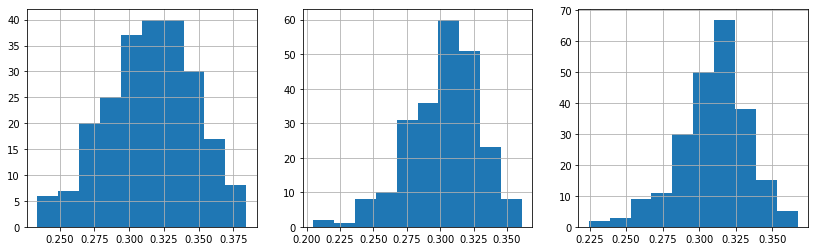

<IPython.core.display.Javascript object>

In [72]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_pitching_fromsc_500pa_prop_events["prop_onbase_event_stand_L"].hist(ax=ax1)
df_pitching_fromsc_500pa_prop_events["prop_onbase_event_stand_R"].hist(ax=ax2)
df_pitching_fromsc_500pa_prop_events["prop_onbase_event_overall"].hist(ax=ax3)

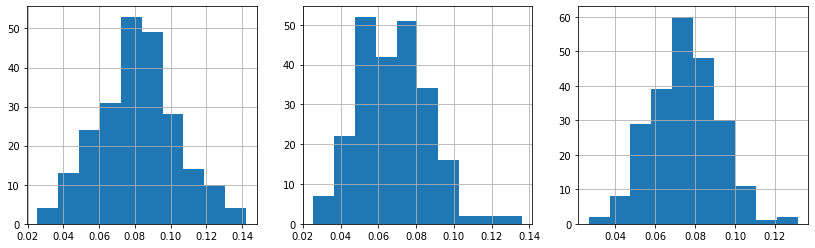

<IPython.core.display.Javascript object>

In [73]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_pitching_fromsc_500pa_prop_events["prop_walk_event_stand_L"].hist(ax=ax1)
df_pitching_fromsc_500pa_prop_events["prop_walk_event_stand_R"].hist(ax=ax2)
df_pitching_fromsc_500pa_prop_events["prop_walk_event_overall"].hist(ax=ax3)

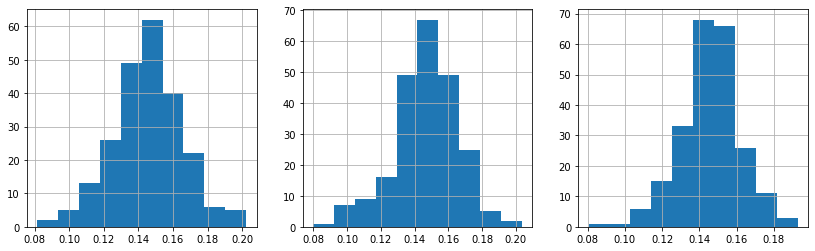

<IPython.core.display.Javascript object>

In [74]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_pitching_fromsc_500pa_prop_events["prop_single_event_stand_L"].hist(ax=ax1)
df_pitching_fromsc_500pa_prop_events["prop_single_event_stand_R"].hist(ax=ax2)
df_pitching_fromsc_500pa_prop_events["prop_single_event_overall"].hist(ax=ax3)

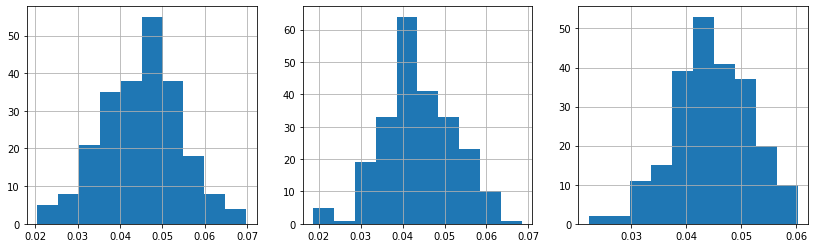

<IPython.core.display.Javascript object>

In [75]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_pitching_fromsc_500pa_prop_events["prop_double_event_stand_L"].hist(ax=ax1)
df_pitching_fromsc_500pa_prop_events["prop_double_event_stand_R"].hist(ax=ax2)
df_pitching_fromsc_500pa_prop_events["prop_double_event_overall"].hist(ax=ax3)

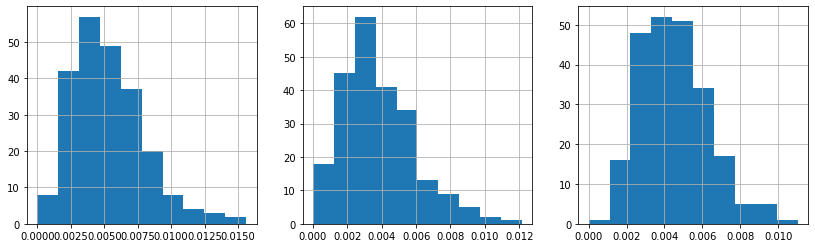

<IPython.core.display.Javascript object>

In [76]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_pitching_fromsc_500pa_prop_events["prop_triple_event_stand_L"].hist(ax=ax1)
df_pitching_fromsc_500pa_prop_events["prop_triple_event_stand_R"].hist(ax=ax2)
df_pitching_fromsc_500pa_prop_events["prop_triple_event_overall"].hist(ax=ax3)

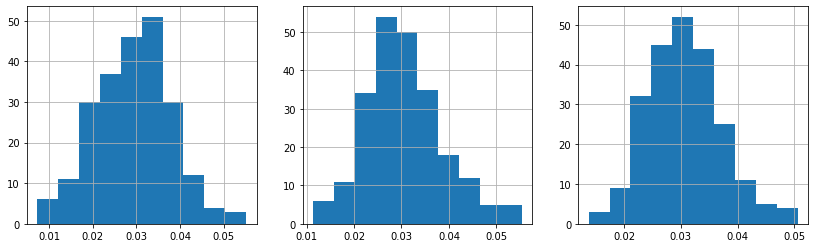

<IPython.core.display.Javascript object>

In [77]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_pitching_fromsc_500pa_prop_events["prop_homerun_event_stand_L"].hist(ax=ax1)
df_pitching_fromsc_500pa_prop_events["prop_homerun_event_stand_R"].hist(ax=ax2)
df_pitching_fromsc_500pa_prop_events["prop_homerun_event_overall"].hist(ax=ax3)

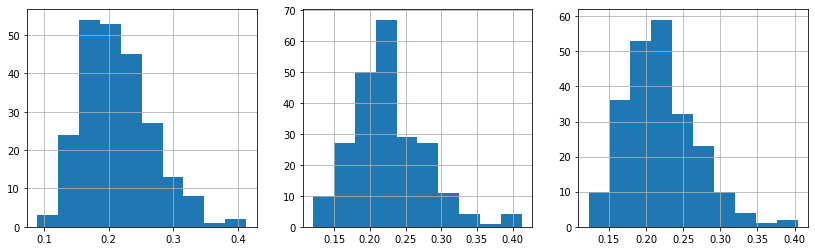

<IPython.core.display.Javascript object>

In [78]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
df_pitching_fromsc_500pa_prop_events["prop_strikeout_event_stand_L"].hist(ax=ax1)
df_pitching_fromsc_500pa_prop_events["prop_strikeout_event_stand_R"].hist(ax=ax2)
df_pitching_fromsc_500pa_prop_events["prop_strikeout_event_overall"].hist(ax=ax3)

### Plots showing some handedness differences

In [79]:
# from stack overflow
def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, "--")

<IPython.core.display.Javascript object>

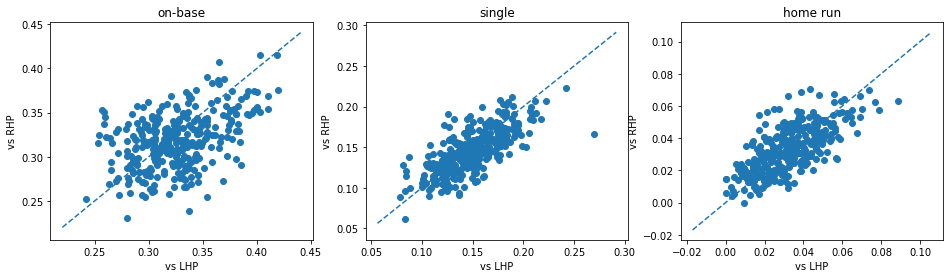

<IPython.core.display.Javascript object>

In [80]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
ax1.scatter(
    df_batting_fromsc_250pa_prop_events["prop_onbase_event_p_throws_L"],
    df_batting_fromsc_250pa_prop_events["prop_onbase_event_p_throws_R"],
)
ax1.set_title("on-base")
ax1.set_xlabel("vs LHP")
ax1.set_ylabel("vs RHP")
abline(1, 0, ax1)

ax2.scatter(
    df_batting_fromsc_250pa_prop_events["prop_single_event_p_throws_L"],
    df_batting_fromsc_250pa_prop_events["prop_single_event_p_throws_R"],
)
ax2.set_title("single")
ax2.set_xlabel("vs LHP")
ax2.set_ylabel("vs RHP")
abline(1, 0, ax2)

ax3.scatter(
    df_batting_fromsc_250pa_prop_events["prop_homerun_event_p_throws_L"],
    df_batting_fromsc_250pa_prop_events["prop_homerun_event_p_throws_R"],
)
ax3.set_title("home run")
ax3.set_xlabel("vs LHP")
ax3.set_ylabel("vs RHP")
abline(1, 0, ax3)

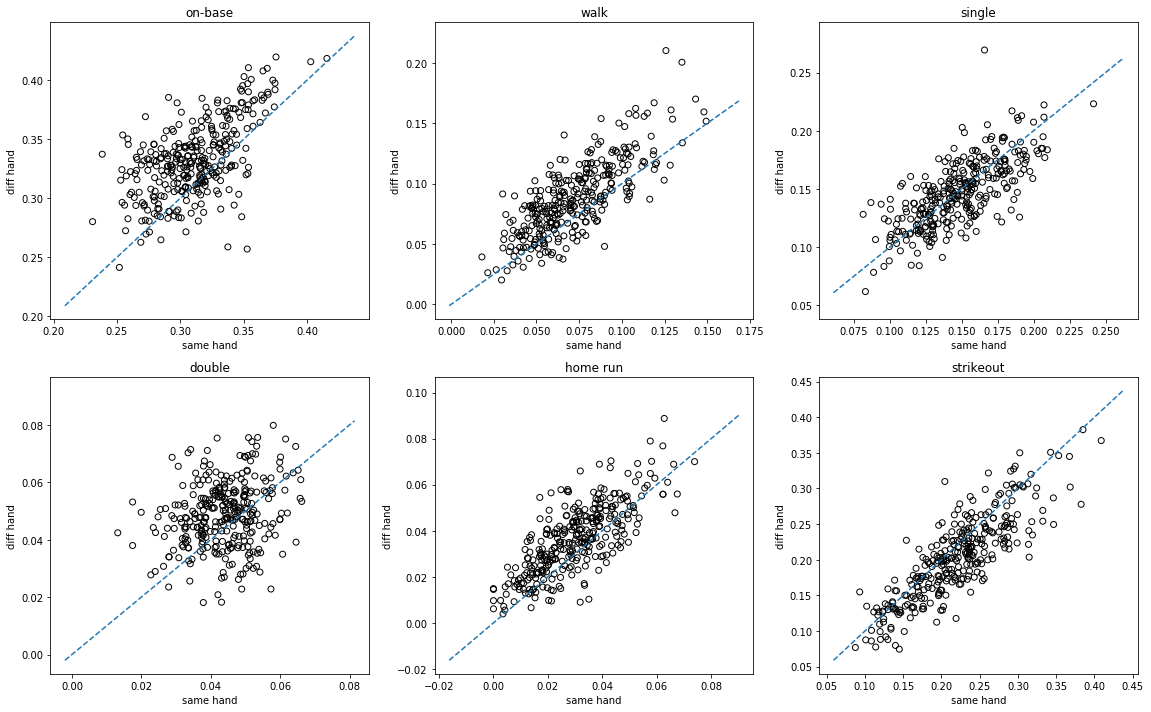

<IPython.core.display.Javascript object>

In [233]:
# Batters same vs. different handedness

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16, 10))

ax1.scatter(
    df_batting_fromsc_250pa_prop_events["prop_onbase_event_p_throws_same"],
    df_batting_fromsc_250pa_prop_events["prop_onbase_event_p_throws_diff"],
    facecolors="none",
    edgecolors="black",
)
ax1.set_title("on-base")
ax1.set_xlabel("same hand")
ax1.set_ylabel("diff hand")
abline(1, 0, ax1)

ax2.scatter(
    df_batting_fromsc_250pa_prop_events["prop_walk_event_p_throws_same"],
    df_batting_fromsc_250pa_prop_events["prop_walk_event_p_throws_diff"],
    facecolors="none",
    edgecolors="black",
)
ax2.set_title("walk")
ax2.set_xlabel("same hand")
ax2.set_ylabel("diff hand")
abline(1, 0, ax2)

ax3.scatter(
    df_batting_fromsc_250pa_prop_events["prop_single_event_p_throws_same"],
    df_batting_fromsc_250pa_prop_events["prop_single_event_p_throws_diff"],
    facecolors="none",
    edgecolors="black",
)
ax3.set_title("single")
ax3.set_xlabel("same hand")
ax3.set_ylabel("diff hand")
abline(1, 0, ax3)

ax4.scatter(
    df_batting_fromsc_250pa_prop_events["prop_double_event_p_throws_same"],
    df_batting_fromsc_250pa_prop_events["prop_double_event_p_throws_diff"],
    facecolors="none",
    edgecolors="black",
)
ax4.set_title("double")
ax4.set_xlabel("same hand")
ax4.set_ylabel("diff hand")
abline(1, 0, ax4)

ax5.scatter(
    df_batting_fromsc_250pa_prop_events["prop_homerun_event_p_throws_same"],
    df_batting_fromsc_250pa_prop_events["prop_homerun_event_p_throws_diff"],
    facecolors="none",
    edgecolors="black",
)
ax5.set_title("home run")
ax5.set_xlabel("same hand")
ax5.set_ylabel("diff hand")
abline(1, 0, ax5)

ax6.scatter(
    df_batting_fromsc_250pa_prop_events["prop_strikeout_event_p_throws_same"],
    df_batting_fromsc_250pa_prop_events["prop_strikeout_event_p_throws_diff"],
    facecolors="none",
    edgecolors="black",
)
ax6.set_title("strikeout")
ax6.set_xlabel("same hand")
ax6.set_ylabel("diff hand")
abline(1, 0, ax6)

plt.tight_layout()

In [82]:
df_pitching_fromsc_500pa_prop_events.head()

pitchers_PA_as_L  pitchers_PA_as_R  pitcher_PA_vs_LHB  \
pitcher                                                           
112526.0               0.0            2869.0             1422.0   
282332.0            3255.0               0.0              635.0   
285079.0               0.0            2430.0             1096.0   
407793.0               0.0            2375.0             1089.0   
407845.0               0.0            1282.0              633.0   

          pitcher_PA_vs_RHB  pitcher_PA pitchers_throwing_hand  \
pitcher                                                          
112526.0             1447.0        2869                      R   
282332.0             2620.0        3255                      L   
285079.0             1334.0        2430                      R   
407793.0             1286.0        2375                      R   
407845.0              649.0        1282                      R   

          prop_onbase_event_stand_L  prop_onbase_event_stand_R  \
pitcher                                                          
112526.0                   0.315752                   0.308224   
282332.0                   0.294488                   0.327481   
285079.0                   0.304745                   0.327586   
407793.0                   0.326905                   0.265163   
407845.0                   0.336493                   0.322034   

          prop_onbase_event_overall  prop_walk_event_stand_L  ...  \
pitcher                                                       ...   
112526.0                   0.311955                 0.047117  ...   
282332.0                   0.321045                 0.085039  ...   
285079.0                   0.317284                 0.082117  ...   
407793.0                   0.293474                 0.084481  ...   
407845.0                   0.329173                 0.126382  ...   

          prop_triple_event_stand_same  prop_homerun_event_stand_same  \
pitcher                                                                 
112526.0                    0.00691085                       0.040774   
282332.0                    0.00314961                      0.0299213   
285079.0                    0.00824588                      0.0329835   
407793.0                    0.00155521                      0.0326594   
407845.0                    0.00154083                      0.0215716   

          prop_strikeout_event_stand_same  prop_onbase_event_stand_diff  \
pitcher                                                                   
112526.0                         0.154112                      0.315752   
282332.0                         0.251969                      0.327481   
285079.0                         0.173913                      0.304745   
407793.0                         0.250389                      0.326905   
407845.0                         0.218798                      0.336493   

          prop_walk_event_stand_diff  prop_single_event_stand_diff  \
pitcher                                                              
112526.0                   0.0471167                      0.164557   
282332.0                   0.0748092                      0.166031   
285079.0                   0.0821168                       0.12865   
407793.0                   0.0844812                      0.155188   
407845.0                    0.126382                       0.14218   

          prop_double_event_stand_diff  prop_triple_event_stand_diff  \
pitcher                                                                
112526.0                     0.0576653                    0.00843882   
282332.0                     0.0408397                    0.00305344   
285079.0                     0.0474453                    0.00638686   
407793.0                     0.0394858                    0.00367309   
407845.0                     0.0315956                    0.00157978   

          prop_homerun_event_stand_diff  prop_strikeout_event_stand_diff  
pitcher              

<IPython.core.display.Javascript object>

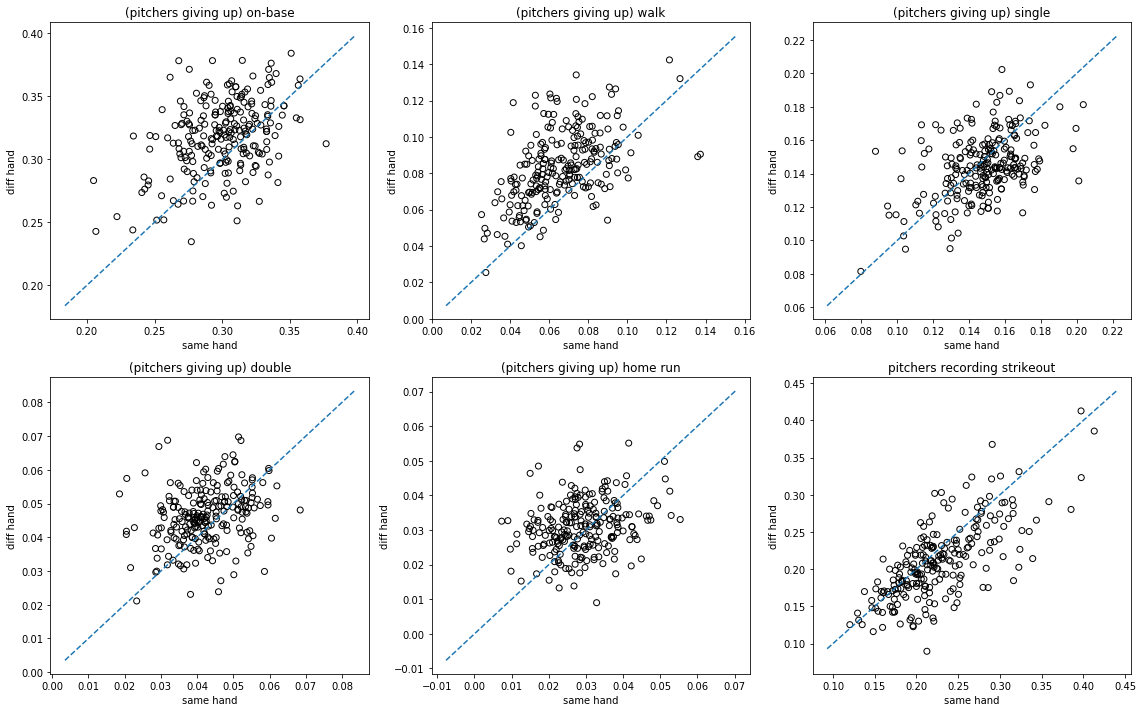

<IPython.core.display.Javascript object>

In [274]:
# Pitchers same vs. different handedness

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16, 10))

ax1.scatter(
    df_pitching_fromsc_500pa_prop_events["prop_onbase_event_stand_same"],
    df_pitching_fromsc_500pa_prop_events["prop_onbase_event_stand_diff"],
    facecolors="none",
    edgecolors="black",
)
ax1.set_title("(pitchers giving up) on-base")
ax1.set_xlabel("same hand")
ax1.set_ylabel("diff hand")
abline(1, 0, ax1)

ax2.scatter(
    df_pitching_fromsc_500pa_prop_events["prop_walk_event_stand_same"],
    df_pitching_fromsc_500pa_prop_events["prop_walk_event_stand_diff"],
    facecolors="none",
    edgecolors="black",
)
ax2.set_title("(pitchers giving up) walk")
ax2.set_xlabel("same hand")
ax2.set_ylabel("diff hand")
abline(1, 0, ax2)

ax3.scatter(
    df_pitching_fromsc_500pa_prop_events["prop_single_event_stand_same"],
    df_pitching_fromsc_500pa_prop_events["prop_single_event_stand_diff"],
    facecolors="none",
    edgecolors="black",
)
ax3.set_title("(pitchers giving up) single")
ax3.set_xlabel("same hand")
ax3.set_ylabel("diff hand")
abline(1, 0, ax3)

ax4.scatter(
    df_pitching_fromsc_500pa_prop_events["prop_double_event_stand_same"],
    df_pitching_fromsc_500pa_prop_events["prop_double_event_stand_diff"],
    facecolors="none",
    edgecolors="black",
)
ax4.set_title("(pitchers giving up) double")
ax4.set_xlabel("same hand")
ax4.set_ylabel("diff hand")
abline(1, 0, ax4)

ax5.scatter(
    df_pitching_fromsc_500pa_prop_events["prop_homerun_event_stand_same"],
    df_pitching_fromsc_500pa_prop_events["prop_homerun_event_stand_diff"],
    facecolors="none",
    edgecolors="black",
)
ax5.set_title("(pitchers giving up) home run")
ax5.set_xlabel("same hand")
ax5.set_ylabel("diff hand")
abline(1, 0, ax5)

ax6.scatter(
    df_pitching_fromsc_500pa_prop_events["prop_strikeout_event_stand_same"],
    df_pitching_fromsc_500pa_prop_events["prop_strikeout_event_stand_diff"],
    facecolors="none",
    edgecolors="black",
)
ax6.set_title("pitchers recording strikeout")
ax6.set_xlabel("same hand")
ax6.set_ylabel("diff hand")
abline(1, 0, ax6)

plt.tight_layout()

# Setting the dataframe for the model

In [86]:
col4model_preprocess = [
    "batter",
    "pitcher",
    "events",
    "stand",
    "p_throws",
    "inning_topbot",
    "onbase_event",
    "walk_event",
    "single_event",
    "double_event",
    "triple_event",
    "homerun_event",
    "strikeout_event",
]

df_sc_all_preprocess = df_sc_all.loc[:, col4model_preprocess].copy()

<IPython.core.display.Javascript object>

In [87]:
# Make feature to represent bp handedness
df_sc_all_preprocess["bp_hand_samediff"] = 0
bool_bp_hand_samediff = (
    df_sc_all_preprocess["stand"] != df_sc_all_preprocess["p_throws"]
)
df_sc_all_preprocess.loc[bool_bp_hand_samediff, "bp_hand_samediff"] = 1

# Make feature to represent home/away, top/bottom
df_sc_all_preprocess["inning_topbot"].replace({"Top": 0, "Bot": 1}, inplace=True)

<IPython.core.display.Javascript object>

In [88]:
df_sc_all_preprocess.head()

batter   pitcher                     events stand p_throws  \
0  150029.0  544727.0                  field_out     R        R   
1  547180.0  544727.0                     double     L        R   
2  607208.0  544727.0                  strikeout     R        R   
3  543685.0  544727.0                  field_out     R        R   
4  502517.0  595014.0  grounded_into_double_play     L        R   

   inning_topbot  onbase_event  walk_event  single_event  double_event  \
0              0             0           0             0             0   
1              0             1           0             0             1   
2              0             0           0             0             0   
3              0             0           0             0             0   
4              1             0           0             0             0   

   triple_event  homerun_event  strikeout_event  bp_hand_samediff  
0             0              0                0                 0  
1             0              0                0                 1  
2             0              0                1                 0  
3             0              0                0                 0  
4             0              0                0                 1

<IPython.core.display.Javascript object>

In [89]:
df_sc_all_preprocess_wbat = pd.merge(
    df_sc_all_preprocess,
    df_batting_fromsc_250pa_prop_events,
    left_on="batter",
    right_index=True,
)

<IPython.core.display.Javascript object>

In [90]:
df_sc_all_preprocess_wbat.head()

batter   pitcher     events stand p_throws  inning_topbot  \
0     150029.0  544727.0  field_out     R        R              0   
17    150029.0  477003.0  field_out     R        L              0   
37    150029.0  594798.0  strikeout     R        R              0   
53    150029.0  594798.0  strikeout     R        R              0   
2224  150029.0  592665.0  strikeout     R        R              0   

      onbase_event  walk_event  single_event  double_event  ...  \
0                0           0             0             0  ...   
17               0           0             0             0  ...   
37               0           0             0             0  ...   
53               0           0             0             0  ...   
2224             0           0             0             0  ...   

      prop_triple_event_p_throws_same  prop_homerun_event_p_throws_same  \
0                          0.00201207                          0.027163   
17                         0.00201207                          0.027163   
37                         0.00201207                          0.027163   
53                         0.00201207                          0.027163   
2224                       0.00201207                          0.027163   

      prop_strikeout_event_p_throws_same  prop_onbase_event_p_throws_diff  \
0                               0.231388                         0.357143   
17                              0.231388                         0.357143   
37                              0.231388                         0.357143   
53                              0.231388                         0.357143   
2224                            0.231388                         0.357143   

      prop_walk_event_p_throws_diff  prop_single_event_p_throws_diff  \
0                          0.114286                         0.110714   
17                         0.114286                         0.110714   
37                         0.114286                         0.110714   
53                         0.114286                         0.110714   
2224                       0.114286                         0.110714   

      prop_double_event_p_throws_diff  prop_triple_event_p_throws_diff  \
0                           0.0714286                                0   
17                          0.0714286                                0   
37                          0.0714286                                0   
53                          0.0714286                                0   
2224                        0.0714286                                0   

      prop_homerun_event_p_throws_diff prop_strikeout_event_p_throws_diff  
0                            0.0571429                           0.210714  
17                           0.0571429                           0.210714  
37                           0.0571429                           0.210714  
53                           0.0571429                           0.210714  
2224                         0.0571429                           0.210714  

[5 rows x 55 columns]

<IPython.core.display.Javascript object>

In [91]:
df_sc_all_preprocess_wbat_wpitch = pd.merge(
    df_sc_all_preprocess_wbat,
    df_pitching_fromsc_500pa_prop_events,
    left_on="pitcher",
    right_index=True,
)

<IPython.core.display.Javascript object>

In [632]:
df_sc_all_preprocess_wbat_wpitch.shape

(324806, 96)

<IPython.core.display.Javascript object>

In [633]:
df_sc_all_preprocess_wbat_wpitch.head()

batter   pitcher     events stand p_throws  inning_topbot  \
0       150029.0  544727.0  field_out     R        R              0   
27772   150029.0  544727.0     single     R        R              1   
28866   150029.0  544727.0     single     R        R              1   
155920  150029.0  544727.0  field_out     R        R              0   
158235  150029.0  544727.0  field_out     R        R              0   

        onbase_event  walk_event  single_event  double_event  ...  \
0                  0           0             0             0  ...   
27772              1           0             1             0  ...   
28866              1           0             1             0  ...   
155920             0           0             0             0  ...   
158235             0           0             0             0  ...   

        prop_triple_event_stand_same  prop_homerun_event_stand_same  \
0                         0.00139665                      0.0125698   
27772                     0.00139665                      0.0125698   
28866                     0.00139665                      0.0125698   
155920                    0.00139665                      0.0125698   
158235                    0.00139665                      0.0125698   

        prop_strikeout_event_stand_same  prop_onbase_event_stand_diff  \
0                              0.287709                      0.318644   
27772                          0.287709                      0.318644   
28866                          0.287709                      0.318644   
155920                         0.287709                      0.318644   
158235                         0.287709                      0.318644   

        prop_walk_event_stand_diff  prop_single_event_stand_diff  \
0                        0.0932203                      0.154237   
27772                    0.0932203                      0.154237   
28866                    0.0932203                      0.154237   
155920                   0.0932203                      0.154237   
158235                   0.0932203                      0.154237   

        prop_double_event_stand_diff  prop_triple_event_stand_diff  \
0                          0.0474576                    0.00338983   
27772                      0.0474576                    0.00338983   
28866                      0.0474576                    0.00338983   
155920                     0.0474576                    0.00338983   
158235                     0.0474576                    0.00338983   

        prop_homerun_event_stand_diff prop_strikeout_event_stand_diff  
0                           0.0152542                        0.225424  
27772                       0.0152542                        0.225424  
28866                       0.0152542                        0.225424  
155920                      0.0152542                        0.225424  
158235                      0.0152542                        0.225424  

[5 rows x 96 columns]

<IPython.core.display.Javascript object>

In [634]:
preprocess_col = [
    "onbase_event",
    "bp_hand_samediff",
    "prop_onbase_event_overall_x",
    "prop_onbase_event_overall_y",
    "inning_topbot",
]

df_sc_all_preprocess_wbat_wpitch_4model = df_sc_all_preprocess_wbat_wpitch[
    preprocess_col
].copy()

<IPython.core.display.Javascript object>

In [635]:
df_sc_all_preprocess_wbat_wpitch_4model.head()

onbase_event  bp_hand_samediff  prop_onbase_event_overall_x  \
0                  0                 0                     0.321036   
27772              1                 0                     0.321036   
28866              1                 0                     0.321036   
155920             0                 0                     0.321036   
158235             0                 0                     0.321036   

        prop_onbase_event_overall_y  inning_topbot  
0                          0.300919              0  
27772                      0.300919              1  
28866                      0.300919              1  
155920                     0.300919              0  
158235                     0.300919              0

<IPython.core.display.Javascript object>

In [636]:
# Selection of same, diff handedness columns for historical proportion event

# Initiate columns
prop_col = ["prop_onbase_event_p_throws_handcomp", "prop_onbase_event_stand_handcomp"]
same_prop_col = ["prop_onbase_event_p_throws_same", "prop_onbase_event_stand_same"]
diff_prop_col = ["prop_onbase_event_p_throws_diff", "prop_onbase_event_stand_diff"]

df_sc_all_preprocess_wbat_wpitch_4model[prop_col[0]] = None
df_sc_all_preprocess_wbat_wpitch_4model[prop_col[1]] = None

bool_atbats_sameh = df_sc_all_preprocess_wbat_wpitch["bp_hand_samediff"] == 0
bool_atbats_diffh = df_sc_all_preprocess_wbat_wpitch["bp_hand_samediff"] == 1

# Add values depending on handedness matchup
df_sc_all_preprocess_wbat_wpitch_4model.loc[
    bool_atbats_sameh, prop_col
] = df_sc_all_preprocess_wbat_wpitch.loc[bool_atbats_sameh, same_prop_col].rename(
    columns=dict(zip(same_prop_col, prop_col))
)

df_sc_all_preprocess_wbat_wpitch_4model.loc[
    bool_atbats_diffh, prop_col
] = df_sc_all_preprocess_wbat_wpitch.loc[bool_atbats_diffh, diff_prop_col].rename(
    columns=dict(zip(diff_prop_col, prop_col))
)

<IPython.core.display.Javascript object>

In [637]:
feature_col_now = [
    "bp_hand_samediff",
    "inning_topbot",
]

feature_col = feature_col_now + prop_col
target_col = "onbase_event"

X_ob = df_sc_all_preprocess_wbat_wpitch_4model[feature_col].copy()
y_ob = df_sc_all_preprocess_wbat_wpitch_4model[target_col].copy()


<IPython.core.display.Javascript object>

In [639]:
df_sc_all_preprocess_wbat_wpitch_4model.head()

onbase_event  bp_hand_samediff  prop_onbase_event_overall_x  \
0                  0                 0                     0.321036   
27772              1                 0                     0.321036   
28866              1                 0                     0.321036   
155920             0                 0                     0.321036   
158235             0                 0                     0.321036   

        prop_onbase_event_overall_y  inning_topbot  \
0                          0.300919              0   
27772                      0.300919              1   
28866                      0.300919              1   
155920                     0.300919              0   
158235                     0.300919              0   

       prop_onbase_event_p_throws_handcomp prop_onbase_event_stand_handcomp  
0                                 0.310865                         0.286313  
27772                             0.310865                         0.286313  
28866                             0.310865                         0.286313  
155920                            0.310865                         0.286313  
158235                            0.310865                         0.286313

<IPython.core.display.Javascript object>

# Run logistic regression

## Split data

In [640]:
def get_split_data(X, y, testsize):

    # Split data between train and test_and_holdout
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=testsize, random_state=19
    )

    from sklearn import preprocessing

    # Scale features based on training data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scale = scaler.transform(X_train)

    # Apply transformation to test data
    X_test_scale = scaler.transform(X_test)

    return X_train_scale, X_test_scale, y_train, y_test, scaler

<IPython.core.display.Javascript object>

In [646]:
X_ob_scale_train, X_ob_scale_test, y_ob_train, y_ob_test, scale_ob = get_split_data(
    X_ob, y_ob, 0.3
)

<IPython.core.display.Javascript object>

In [647]:
def run_logreg_model(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):

    log_reg = LogisticRegression(class_weight="balanced")
    log_reg.fit(X_train_scale_set, y_train_set)

    y_pred = log_reg.predict(X_test_scale_set)
    y_predprob = log_reg.predict_proba(X_test_scale_set)[:, 1]
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred, "predprob": y_predprob})

    return log_reg, df_eval

<IPython.core.display.Javascript object>

In [648]:
log_reg_ob, df_eval_ob = run_logreg_model(
    X_ob_scale_train, y_ob_train, X_ob_scale_test, y_ob_test
)

<IPython.core.display.Javascript object>

In [650]:
df_eval_ob.head()

test  pred  predprob
390736     0     0  0.348375
416641     1     0  0.484469
769534     0     0  0.490117
389495     1     1  0.537113
918789     0     1  0.593330

<IPython.core.display.Javascript object>

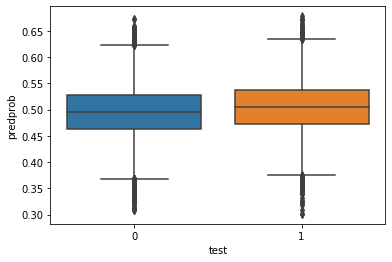

<IPython.core.display.Javascript object>

In [651]:
sns.boxplot(data=df_eval_ob, x="test", y="predprob")

In [652]:
print(metrics.classification_report(df_eval_ob["test"], df_eval_ob["pred"]))

              precision    recall  f1-score   support

           0       0.71      0.54      0.61     66185
           1       0.35      0.54      0.43     31257

    accuracy                           0.54     97442
   macro avg       0.53      0.54      0.52     97442
weighted avg       0.60      0.54      0.55     97442



<IPython.core.display.Javascript object>

In [658]:
# Compare to random shuffle
(pd.Series([0, 1, 2, 3, 4])).sample(frac=1)

1    1
4    4
2    2
0    0
3    3
dtype: int64

<IPython.core.display.Javascript object>

In [669]:
report_vals = list()
for i in range(5):
    df_cl_report = metrics.classification_report(
        df_eval_ob["test"], df_eval_ob["test"].sample(frac=1)
    )

    report_vals.append(df_cl_report)

<IPython.core.display.Javascript object>

In [670]:
report_vals

['              precision    recall  f1-score   support\n\n           0       0.68      0.68      0.68     66185\n           1       0.32      0.32      0.32     31257\n\n    accuracy                           0.56     97442\n   macro avg       0.50      0.50      0.50     97442\nweighted avg       0.56      0.56      0.56     97442\n',
 '              precision    recall  f1-score   support\n\n           0       0.68      0.68      0.68     66185\n           1       0.32      0.32      0.32     31257\n\n    accuracy                           0.56     97442\n   macro avg       0.50      0.50      0.50     97442\nweighted avg       0.56      0.56      0.56     97442\n',
 '              precision    recall  f1-score   support\n\n           0       0.68      0.68      0.68     66185\n           1       0.32      0.32      0.32     31257\n\n    accuracy                           0.57     97442\n   macro avg       0.50      0.50      0.50     97442\nweighted avg       0.57      0.57      0.

<IPython.core.display.Javascript object>

In [665]:
print(
    metrics.classification_report(df_eval_ob["test"], df_eval_ob["test"].sample(frac=1))
)

              precision    recall  f1-score   support

           0       0.68      0.68      0.68     66185
           1       0.32      0.32      0.32     31257

    accuracy                           0.56     97442
   macro avg       0.50      0.50      0.50     97442
weighted avg       0.56      0.56      0.56     97442



<IPython.core.display.Javascript object>

# Run random forest

In [433]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

<IPython.core.display.Javascript object>

In [434]:
def run_randomforest_v0(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):

    # Instantiate model with 1000 decision trees
    rf = RandomForestClassifier(n_estimators=1000, random_state=19)
    rf.fit(X_train_scale_set, y_train_set)

    y_pred = rf.predict(X_test_scale_set)
    y_predprob = rf.predict_proba(X_test_scale_set)[:, 1]
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred, "predprob": y_predprob})

    return rf, df_eval

<IPython.core.display.Javascript object>

In [435]:
log_reg_ob_rf, df_eval_ob_rf = run_randomforest_v0(
    X_ob_scale_train, y_ob_train, X_ob_scale_test, y_ob_test
)

<IPython.core.display.Javascript object>

In [436]:
print(metrics.classification_report(df_eval_ob_rf["test"], df_eval_ob_rf["pred"]))

              precision    recall  f1-score   support

           0       0.68      0.80      0.74     88366
           1       0.33      0.21      0.26     41557

    accuracy                           0.61    129923
   macro avg       0.51      0.51      0.50    129923
weighted avg       0.57      0.61      0.58    129923



<IPython.core.display.Javascript object>

# XGBoost

**Model considerations**


Notes from Fiona
<br>
https://www.analyticsvidhya.com/blog/2018/10/interpret-random-forest-model-machine-learning-programmers/
if you have time I recommend watching his lectures (the first 4 or so are on random forest), it'll help you be able to use it to understand your features. All of his lectures are also online and written up as an article too

this was the article that very crudely tested 4 classification models
logistic regression, random forest, SVC and NB
I tried it more to get a directional idea of which could be worth spending more time on
avatar
this one also has other models like KNN (https://www.geeksforgeeks.org/multiclass-classification-using-scikit-learn/), but I didn't find them useful.

https://evgenypogorelov.com/multiclass-xgb-shap.html
and here's XGBoost


In [643]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate


<IPython.core.display.Javascript object>

In [644]:
# X_ob_scale_train, X_ob_scale_test, y_ob_train, y_ob_test, scale_ob = get_split_data(
#     X_ob, y_ob, 0.3
# )

xgbcl = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
         gamma=0.0, max_delta_step=0.0, min_child_weight=1.0,
         missing=None, n_jobs=-1, objective='binary:logistic', random_state=42, reg_alpha=0.0,
         reg_lambda=1.0, scale_pos_weight=1.0, tree_method='auto')

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid = { 
    'colsample_bytree':[.75,1],
    'learning_rate':[0.01,0.05,0.1,0.3,0.5],
    'max_depth':[1,2,3,5],
    'subsample':[.75,1],
    'n_estimators': list(range(50, 400, 50))
}

grid_search = GridSearchCV(estimator=xgbcl, scoring='roc_auc', param_grid=param_grid, n_jobs=-1, cv=kfold)


<IPython.core.display.Javascript object>

In [645]:
grid_result = grid_search.fit(X_ob_scale_train, y_ob_train)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}", "\n")

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

# Regression approaches, using historical proportions

## Using overall percentages

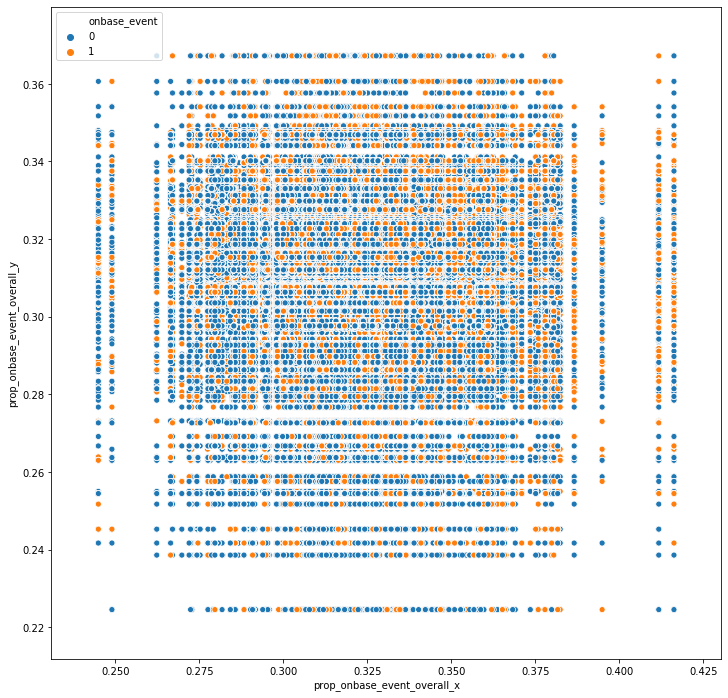

<IPython.core.display.Javascript object>

In [113]:
# f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 16))
f, (ax1) = plt.subplots(1, 1, figsize=(12, 12))

sns.scatterplot(
    data=df_sc_all_preprocess_wbat_wpitch,
    x="prop_onbase_event_overall_x",
    y="prop_onbase_event_overall_y",
    hue="onbase_event",
    ax=ax1,
)

# sns.scatterplot(
#     data=df_sc_all_preprocess_wbat_wpitch,
#     x="prop_onbase_event_p_throws_same",
#     y="prop_onbase_event_stand_same",
#     hue="onbase_event",
#     ax=ax2,
# )

# sns.scatterplot(
#     data=df_sc_all_preprocess_wbat_wpitch,
#     x="prop_onbase_event_p_throws_diff",
#     y="prop_onbase_event_stand_diff",
#     hue="onbase_event",
#     ax=ax3,
# )

In [114]:
df_sc_all_preprocess_wbat_wpitch.shape

(324806, 96)

<IPython.core.display.Javascript object>

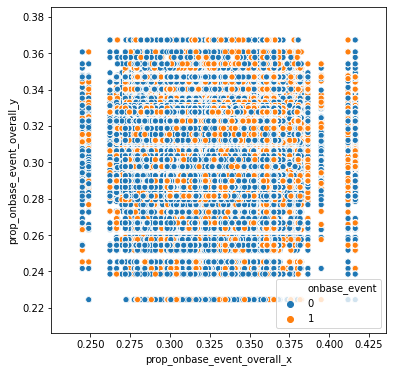

<IPython.core.display.Javascript object>

In [115]:
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))

df_temp = df_sc_all_preprocess_wbat_wpitch.copy()

sns.scatterplot(
    data=df_temp,
    x="prop_onbase_event_overall_x",
    y="prop_onbase_event_overall_y",
    hue="onbase_event",
    ax=ax1,
);


In [131]:
bool_x_vals = df_sc_all_preprocess_wbat_wpitch["prop_onbase_event_overall_x"].between(
    0.275, 0.375
)
bool_y_vals = df_sc_all_preprocess_wbat_wpitch["prop_onbase_event_overall_y"].between(
    0.24, 0.36
)

df_temp_focus = df_sc_all_preprocess_wbat_wpitch.loc[(bool_x_vals & bool_y_vals), :]

<IPython.core.display.Javascript object>

## KNN

In [116]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from math import sqrt

<IPython.core.display.Javascript object>

In [18]:
feature_col = ["prop_onbase_event_overall_x", "prop_onbase_event_overall_y"]

<IPython.core.display.Javascript object>

In [19]:
X_knn = df_temp[feature_col].copy()
y_knn = df_temp[target_col].copy()


NameError: name 'df_temp' is not defined

<IPython.core.display.Javascript object>

In [ ]:
(
    X_knn_scale_train,
    X_knn_scale_test,
    y_knn_train,
    y_knn_test,
    scale_knn,
) = get_split_data(X_knn, y_knn, 0.3)

In [703]:
rmse_val = []  # to store rmse values for different k
for K in range(100):
    K = K + 1
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model.fit(X_knn_scale_train, y_knn_train)  # fit the model
    pred = model.predict(X_knn_scale_test)  # make prediction on test set
    error = sqrt(mean_squared_error(y_knn_test, pred))  # calculate rmse
    df_eval = pd.DataFrame({"test": y_knn_test, "pred": pred})
    rmse_val.append(error)  # store rmse values
    # print("RMSE value for k= ", K, "is:", error)

<IPython.core.display.Javascript object>

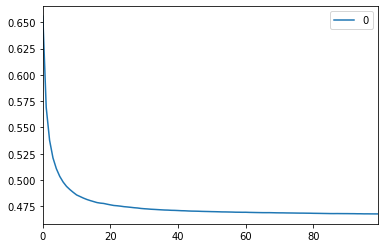

<IPython.core.display.Javascript object>

In [704]:
# plotting the rmse values against k values
curve = pd.DataFrame(rmse_val)  # elbow curve
curve.plot()

In [713]:
df_eval.shape

(97442, 2)

<IPython.core.display.Javascript object>

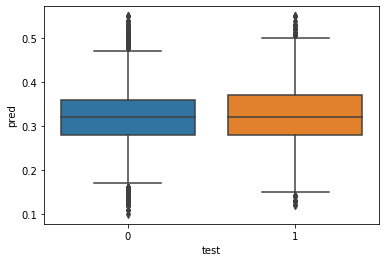

<IPython.core.display.Javascript object>

In [706]:
sns.boxplot(data=df_eval, x="test", y="pred")

In [707]:
pred_train = model.predict(X_knn_scale_train)

<IPython.core.display.Javascript object>

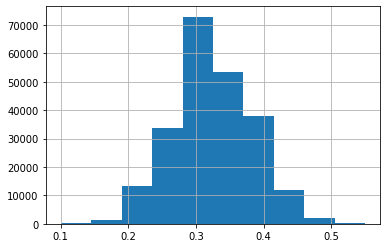

<IPython.core.display.Javascript object>

In [708]:
pd.Series(pred_train).hist()

In [709]:
# Make heatmap spreadsheet

bat_cat_min, bat_cat_max = 0.15, 0.5
pitch_cat_min, pitch_cat_max = 0.8, 1.8
n_points = 20

df_vals4heatmap = pd.DataFrame(
    {
        "batter_cat": sorted(
            np.linspace(bat_cat_min, bat_cat_max, n_points).tolist() * n_points
        ),
        "pitcher_cat": (
            np.linspace(pitch_cat_min, pitch_cat_max, n_points).tolist() * n_points
        ),
    }
)

# Scale values
df_vals4heatmap_scale = scale_knn.transform(df_vals4heatmap)

# Use model to make predictions
y_pred_vals4heatmap = model.predict(df_vals4heatmap_scale)

df_vals4heatmap["pred"] = y_pred_vals4heatmap

<IPython.core.display.Javascript object>

In [697]:
def make_heatmap(vals_heatmap):
    vals4heatmap_pivot = vals_heatmap.pivot("batter_cat", "pitcher_cat", "pred")

    def fmt(s):
        try:
            n = "{:.3f}".format(float(s))
        except:
            n = ""
        return n

    f, ax1 = plt.subplots(figsize=(8, 8))
    ax1 = sns.heatmap(vals4heatmap_pivot, cmap="RdBu_r")  # , annot=True)
    ax1.set_xticklabels([fmt(label.get_text()) for label in ax1.get_xticklabels()])
    ax1.invert_yaxis()
    ax1.set_yticklabels([fmt(label.get_text()) for label in ax1.get_yticklabels()])

    #     batter_obp = np.float(
    #         df_batting_100pa.loc[df_batting_100pa["Name"] == batter_name, "OBP"]
    #     )

    #     pitcher_whip = np.float(
    #         df_pitching_50ip.loc[df_pitching_50ip["Name"] == pitcher_name, "WHIP"]
    #     )

    #     bat_val, pitch_val = batter_obp, pitcher_whip
    #     x_on_plot = (pitch_val / pitch_cat_max) * n_points
    #     y_on_plot = (bat_val / bat_cat_max) * n_points
    # ax1.scatter(x_on_plot, y_on_plot, marker="*", s=100, color="orange")

    #     save_name = (
    #         "heatmap_"
    #         + (batter_name).replace(" ", "-")
    #         + "_"
    #         + (pitcher_name).replace(" ", "-")
    #     )

    #     dir_path = "./flask_insight_notes/flask_baseball/flaskexample/static/bp_hist/"
    #     plt.savefig(dir_path + save_name)

    # return save_name + ".png"
    return None

<IPython.core.display.Javascript object>

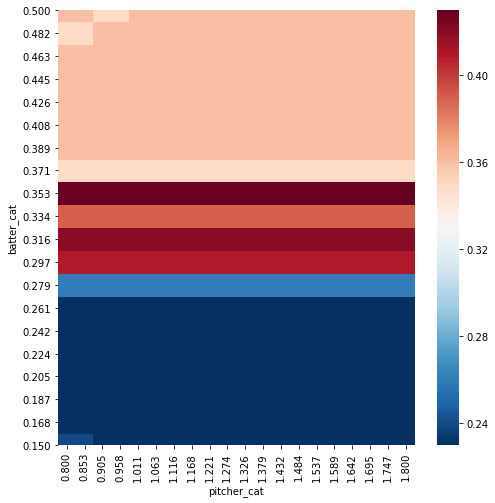

<IPython.core.display.Javascript object>

In [710]:
make_heatmap(df_vals4heatmap)

### Using GridSearch

## Radius Nearest Neighbors

In [117]:
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import GridSearchCV

<IPython.core.display.Javascript object>

In [151]:
def get_split_data_noscale(X, y, testsize):

    # Split data between train and test_and_holdout
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=testsize, random_state=19
    )

    return X_train, X_test, y_train, y_test

<IPython.core.display.Javascript object>

In [4]:
df_temp = df_sc_all_preprocess_wbat_wpitch.iloc[0:50000, :].copy()
feature_col = ["prop_onbase_event_overall_x", "prop_onbase_event_overall_y"]

NameError: name 'df_sc_all_preprocess_wbat_wpitch' is not defined

In [3]:
df_temp.shape

NameError: name 'df_temp' is not defined

In [153]:
X_knn = df_temp_focus[feature_col].copy()
y_knn = df_temp_focus[target_col].copy()

<IPython.core.display.Javascript object>

In [154]:
(
    X_knn_noscale_train,
    X_knn_noscale_test,
    y_knn_train,
    y_knn_test,
) = get_split_data_noscale(X_knn, y_knn, 0.3)

<IPython.core.display.Javascript object>

In [ ]:

# neigh = RadiusNeighborsClassifier(radius=1.0)
# neigh.fit(X_ob_scale_train, y_ob_train)
# RadiusNeighborsClassifier(...)

In [ ]:
rmse_val = []  # to store rmse values for different r
for r in [0.5, 1, 10, 20]:
    # r = r + 1
    neigh = RadiusNeighborsClassifier(radius=r)
    neigh.fit(X_knn_noscale_train, y_knn_train)
    pred = neigh.predict(X_knn_noscale_test)  # make prediction on test set
    error = sqrt(mean_squared_error(y_knn_test, pred))  # calculate rmse
    df_eval = pd.DataFrame({"test": y_knn_test, "pred": pred})
    rmse_val.append(error)  # store rmse values
    print("RMSE value for r= ", r, "is:", error)

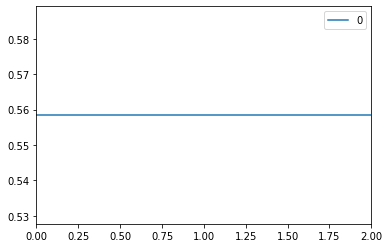

<IPython.core.display.Javascript object>

In [122]:
# plotting the rmse values against k values
curve = pd.DataFrame(rmse_val)  # elbow curve
curve.plot()

In [137]:
df_eval["pred"].sum()

0

<IPython.core.display.Javascript object>

In [138]:
predprob = neigh.predict_proba(X_knn_scale_test)

<IPython.core.display.Javascript object>

In [140]:
df_eval = pd.DataFrame({"test": y_knn_test, "pred": pred, "predprob": predprob[:, 1]})

<IPython.core.display.Javascript object>

In [141]:
df_eval.head()

test  pred  predprob
836439     1     0  0.319629
919851     0     0  0.319629
284537     1     0  0.319629
852696     0     0  0.319629
458629     0     0  0.319629

<IPython.core.display.Javascript object>

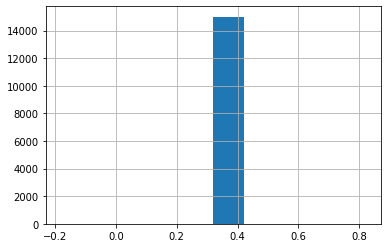

<IPython.core.display.Javascript object>

In [142]:
df_eval["predprob"].hist()

### Using GridSearch

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

# Linear regression with target construction

In [98]:
df_sc_all_preprocess_wbat_wpitch.head()

batter   pitcher     events stand p_throws  inning_topbot  \
0       150029.0  544727.0  field_out     R        R              0   
27772   150029.0  544727.0     single     R        R              1   
28866   150029.0  544727.0     single     R        R              1   
155920  150029.0  544727.0  field_out     R        R              0   
158235  150029.0  544727.0  field_out     R        R              0   

        onbase_event  walk_event  single_event  double_event  ...  \
0                  0           0             0             0  ...   
27772              1           0             1             0  ...   
28866              1           0             1             0  ...   
155920             0           0             0             0  ...   
158235             0           0             0             0  ...   

        prop_triple_event_stand_same  prop_homerun_event_stand_same  \
0                         0.00139665                      0.0125698   
27772                     0.00139665                      0.0125698   
28866                     0.00139665                      0.0125698   
155920                    0.00139665                      0.0125698   
158235                    0.00139665                      0.0125698   

        prop_strikeout_event_stand_same  prop_onbase_event_stand_diff  \
0                              0.287709                      0.318644   
27772                          0.287709                      0.318644   
28866                          0.287709                      0.318644   
155920                         0.287709                      0.318644   
158235                         0.287709                      0.318644   

        prop_walk_event_stand_diff  prop_single_event_stand_diff  \
0                        0.0932203                      0.154237   
27772                    0.0932203                      0.154237   
28866                    0.0932203                      0.154237   
155920                   0.0932203                      0.154237   
158235                   0.0932203                      0.154237   

        prop_double_event_stand_diff  prop_triple_event_stand_diff  \
0                          0.0474576                    0.00338983   
27772                      0.0474576                    0.00338983   
28866                      0.0474576                    0.00338983   
155920                     0.0474576                    0.00338983   
158235                     0.0474576                    0.00338983   

        prop_homerun_event_stand_diff prop_strikeout_event_stand_diff  
0                           0.0152542                        0.225424  
27772                       0.0152542                        0.225424  
28866                       0.0152542                        0.225424  
155920                      0.0152542                        0.225424  
158235                      0.0152542                        0.225424  

[5 rows x 96 columns]

<IPython.core.display.Javascript object>

## Using overall on-base percentage

In [99]:
preprocess_col = [
    "onbase_event",
    "prop_onbase_event_overall_x",
    "prop_onbase_event_overall_y",
]

df_sc_all_preprocess_wbat_wpitch_4model = df_sc_all_preprocess_wbat_wpitch[
    preprocess_col
].copy()

<IPython.core.display.Javascript object>

In [100]:
df_sc_all_preprocess_wbat_wpitch_4model.head()

onbase_event  prop_onbase_event_overall_x  prop_onbase_event_overall_y
0                  0                     0.321036                     0.300919
27772              1                     0.321036                     0.300919
28866              1                     0.321036                     0.300919
155920             0                     0.321036                     0.300919
158235             0                     0.321036                     0.300919

<IPython.core.display.Javascript object>

## Target construction via binning

In [112]:
# Bin these so that the most frequent categories are subdivided more
df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_batter"] = pd.qcut(
    df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_event_overall_x"], 50
)
df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_pitcher"] = pd.qcut(
    df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_event_overall_y"], 50
)

<IPython.core.display.Javascript object>

In [113]:
df_sc_all_preprocess_wbat_wpitch_4model.shape

(324806, 5)

<IPython.core.display.Javascript object>

In [114]:
df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_batter"].unique()

[(0.32, 0.3214], (0.3785, 0.3824], (0.3427, 0.3459], (0.3683, 0.3751], (0.341, 0.3427], ..., (0.3129, 0.3142], (0.3824, 0.4163], (0.3078, 0.3085], (0.3638, 0.3683], (0.3214, 0.3227]]
Length: 50
Categories (50, interval[float64]): [(0.2449, 0.2744] < (0.2744, 0.2788] < (0.2788, 0.285] < (0.285, 0.2883] ... (0.3683, 0.3751] < (0.3751, 0.3785] < (0.3785, 0.3824] < (0.3824, 0.4163]]

<IPython.core.display.Javascript object>

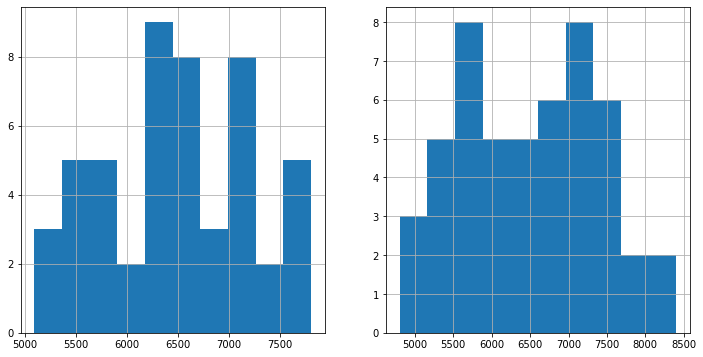

<IPython.core.display.Javascript object>

In [115]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_batter"].value_counts().hist(
    ax=ax1
)
df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_pitcher"].value_counts().hist(
    ax=ax2
)

In [176]:
df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_pitcher"].value_counts().mean()

6496.12

<IPython.core.display.Javascript object>

In [119]:
def get_df_binned_4model(df_sc_4model, bat_cat, pitch_cat, target):
    # Get the proportion from each category combination with groupby
    df_sc_4model_agg = df_sc_4model.groupby([bat_cat, pitch_cat])[target].mean()

    bat_cat_mp = pd.Series(df_sc_4model_agg.index.get_level_values(0).tolist()).apply(
        lambda x: x.mid
    )

    pitch_cat_mp = pd.Series(df_sc_4model_agg.index.get_level_values(1).tolist()).apply(
        lambda x: x.mid
    )

    df_sc_4model_agg_final = pd.DataFrame(
        {
            "event_mean": df_sc_4model_agg.tolist(),
            "batter_cat": bat_cat_mp,
            "pitcher_cat": pitch_cat_mp,
        }
    )

    return df_sc_4model_agg_final

<IPython.core.display.Javascript object>

In [120]:
df_sc_all_preprocess_wbat_wpitch_4model_agg = get_df_binned_4model(
    df_sc_all_preprocess_wbat_wpitch_4model,
    "prop_onbase_batter",
    "prop_onbase_pitcher",
    "onbase_event",
)

<IPython.core.display.Javascript object>

In [122]:
print(df_sc_all_preprocess_wbat_wpitch_4model_agg.shape)
df_sc_all_preprocess_wbat_wpitch_4model_agg.head()

(2500, 3)


event_mean  batter_cat  pitcher_cat
0    0.174107     0.25965      0.23805
1    0.235294     0.25965      0.25735
2    0.230000     0.25965      0.26445
3    0.202454     0.25965      0.26945
4    0.239496     0.25965      0.27685

<IPython.core.display.Javascript object>

Text(0, 0.5, 'proportion of at-bats getting on-base')

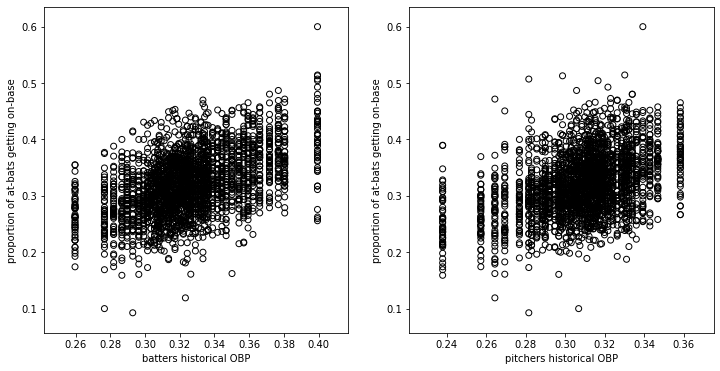

<IPython.core.display.Javascript object>

In [151]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(
    df_sc_all_preprocess_wbat_wpitch_4model_agg["batter_cat"],
    df_sc_all_preprocess_wbat_wpitch_4model_agg["event_mean"],
    facecolors="none",
    edgecolors="black",
)
ax1.set_xlabel("batters historical OBP")
ax1.set_ylabel("proportion of at-bats getting on-base")

ax2.scatter(
    df_sc_all_preprocess_wbat_wpitch_4model_agg["pitcher_cat"],
    df_sc_all_preprocess_wbat_wpitch_4model_agg["event_mean"],
    facecolors="none",
    edgecolors="black",
)
ax2.set_xlabel("pitchers historical OBP")
ax2.set_ylabel("proportion of at-bats getting on-base")

### Run LM model

In [125]:
feature_col_now = [
    "batter_cat",
    "pitcher_cat",
]

feature_col = feature_col_now
target_col = "event_mean"

X_ob_oa = df_sc_all_preprocess_wbat_wpitch_4model_agg[feature_col].copy()
y_ob_oa = df_sc_all_preprocess_wbat_wpitch_4model_agg[target_col].copy()

<IPython.core.display.Javascript object>

**See above for split model function**

In [134]:
(
    X_ob_oa_scale_train,
    X_ob_oa_scale_test,
    y_ob_oa_train,
    y_ob_oa_test,
    scale_ob,
) = get_split_data(X_ob_oa, y_ob_oa, 0.4)

<IPython.core.display.Javascript object>

In [135]:
def run_linreg_model(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):

    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scale_set, y_train_set)

    y_pred = lin_reg.predict(X_test_scale_set)
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred})

    return lin_reg, df_eval

<IPython.core.display.Javascript object>

In [136]:
lin_reg_v0, df_eval_v0 = run_linreg_model(
    X_ob_oa_scale_train, y_ob_oa_train, X_ob_oa_scale_test, y_ob_oa_test
)

<IPython.core.display.Javascript object>

In [137]:
df_eval_v0.head()

test      pred
2201  0.231579  0.303162
2248  0.355030  0.394680
926   0.369863  0.316312
534   0.241667  0.313641
529   0.301724  0.309753

<IPython.core.display.Javascript object>

Text(0, 0.5, 'prediction')

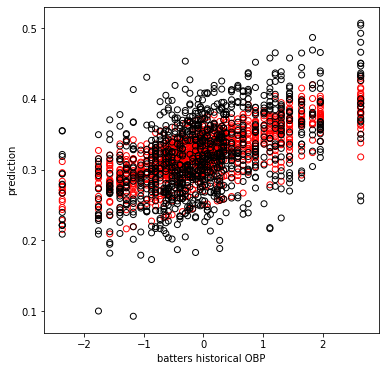

<IPython.core.display.Javascript object>

In [146]:
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
ax1.scatter(
    X_ob_oa_scale_test[:, 0], df_eval_v0["pred"], facecolors="none", edgecolors="red",
)

ax1.scatter(
    X_ob_oa_scale_test[:, 0], df_eval_v0["test"], facecolors="none", edgecolors="black",
)

ax1.set_xlabel("batters historical OBP")
ax1.set_ylabel("prediction")

In [138]:
metrics.r2_score(df_eval_v0["test"], df_eval_v0["pred"])

0.4502250876079835

<IPython.core.display.Javascript object>

## Natural log transformation


In [157]:
feature_col_now = [
    "batter_cat",
    "pitcher_cat",
]

feature_col = feature_col_now
target_col = "event_mean"

X_ob_oa = np.log(df_sc_all_preprocess_wbat_wpitch_4model_agg[feature_col].copy())
y_ob_oa = np.log(df_sc_all_preprocess_wbat_wpitch_4model_agg[target_col].copy())


<IPython.core.display.Javascript object>

In [155]:
X_ob_oa.head()

batter_cat  pitcher_cat
0   -1.348421    -1.435275
1   -1.348421    -1.357318
2   -1.348421    -1.330103
3   -1.348421    -1.311372
4   -1.348421    -1.284279

<IPython.core.display.Javascript object>

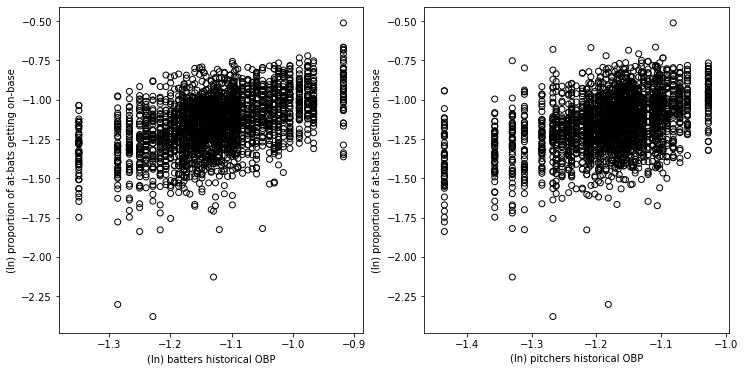

<IPython.core.display.Javascript object>

In [158]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(
    X_ob_oa.iloc[:, 0], y_ob_oa, facecolors="none", edgecolors="black",
)
ax1.set_xlabel("(ln) batters historical OBP")
ax1.set_ylabel("(ln) proportion of at-bats getting on-base")

ax2.scatter(
    X_ob_oa.iloc[:, 1], y_ob_oa, facecolors="none", edgecolors="black",
)
ax2.set_xlabel("(ln) pitchers historical OBP")
ax2.set_ylabel("(ln) proportion of at-bats getting on-base")

### Run LM model after log transformation

In [159]:
(
    X_ob_oa_scale_train,
    X_ob_oa_scale_test,
    y_ob_oa_train,
    y_ob_oa_test,
    scale_ob,
) = get_split_data(X_ob_oa, y_ob_oa, 0.4)

<IPython.core.display.Javascript object>

In [160]:
lin_reg_v1, df_eval_v1 = run_linreg_model(
    X_ob_oa_scale_train, y_ob_oa_train, X_ob_oa_scale_test, y_ob_oa_test
)

<IPython.core.display.Javascript object>

In [161]:
df_eval_v1.head()

test      pred
2201 -1.462834 -1.224979
2248 -1.035554 -0.925693
926  -0.994623 -1.160302
534  -1.420196 -1.170227
529  -1.198242 -1.182252

<IPython.core.display.Javascript object>

Text(0, 0.5, 'prediction')

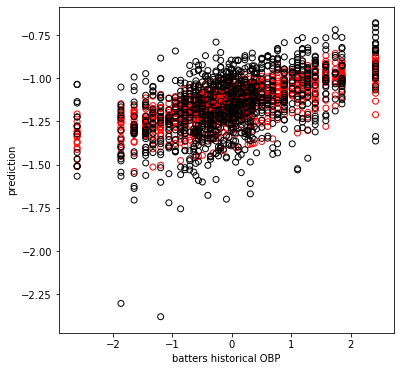

<IPython.core.display.Javascript object>

In [162]:
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
ax1.scatter(
    X_ob_oa_scale_test[:, 0], df_eval_v1["pred"], facecolors="none", edgecolors="red",
)

ax1.scatter(
    X_ob_oa_scale_test[:, 0], df_eval_v1["test"], facecolors="none", edgecolors="black",
)

ax1.set_xlabel("batters historical OBP")
ax1.set_ylabel("prediction")

In [164]:
metrics.r2_score(df_eval_v1["test"], df_eval_v1["pred"])

0.4296785018388639

<IPython.core.display.Javascript object>

## Using handedness information

In [214]:
df_sc_all_preprocess_wbat_wpitch.head()

batter   pitcher     events stand p_throws  inning_topbot  \
0       150029.0  544727.0  field_out     R        R              0   
27772   150029.0  544727.0     single     R        R              1   
28866   150029.0  544727.0     single     R        R              1   
155920  150029.0  544727.0  field_out     R        R              0   
158235  150029.0  544727.0  field_out     R        R              0   

        onbase_event  walk_event  single_event  double_event  ...  \
0                  0           0             0             0  ...   
27772              1           0             1             0  ...   
28866              1           0             1             0  ...   
155920             0           0             0             0  ...   
158235             0           0             0             0  ...   

        prop_triple_event_stand_same  prop_homerun_event_stand_same  \
0                         0.00139665                      0.0125698   
27772                     0.00139665                      0.0125698   
28866                     0.00139665                      0.0125698   
155920                    0.00139665                      0.0125698   
158235                    0.00139665                      0.0125698   

        prop_strikeout_event_stand_same  prop_onbase_event_stand_diff  \
0                              0.287709                      0.318644   
27772                          0.287709                      0.318644   
28866                          0.287709                      0.318644   
155920                         0.287709                      0.318644   
158235                         0.287709                      0.318644   

        prop_walk_event_stand_diff  prop_single_event_stand_diff  \
0                        0.0932203                      0.154237   
27772                    0.0932203                      0.154237   
28866                    0.0932203                      0.154237   
155920                   0.0932203                      0.154237   
158235                   0.0932203                      0.154237   

        prop_double_event_stand_diff  prop_triple_event_stand_diff  \
0                          0.0474576                    0.00338983   
27772                      0.0474576                    0.00338983   
28866                      0.0474576                    0.00338983   
155920                     0.0474576                    0.00338983   
158235                     0.0474576                    0.00338983   

        prop_homerun_event_stand_diff prop_strikeout_event_stand_diff  
0                           0.0152542                        0.225424  
27772                       0.0152542                        0.225424  
28866                       0.0152542                        0.225424  
155920                      0.0152542                        0.225424  
158235                      0.0152542                        0.225424  

[5 rows x 96 columns]

<IPython.core.display.Javascript object>

In [264]:
def make_handedness_specific_df(df, df_4model, event_type):
    # Selection of same, diff handedness columns for historical proportion event

    # Initiate columns
    prop_col = [
        "prop_" + event_type + "_event_p_throws_handcomp",
        "prop_" + event_type + "_event_stand_handcomp",
    ]
    same_prop_col = [
        "prop_" + event_type + "_event_p_throws_same",
        "prop_" + event_type + "_event_stand_same",
    ]
    diff_prop_col = [
        "prop_" + event_type + "_event_p_throws_diff",
        "prop_" + event_type + "_event_stand_diff",
    ]

    df_4model[prop_col[0]] = None
    df_4model[prop_col[1]] = None

    bool_atbats_sameh = df["bp_hand_samediff"] == 0
    bool_atbats_diffh = df["bp_hand_samediff"] == 1

    # Add values depending on handedness matchup
    df_4model.loc[bool_atbats_sameh, prop_col] = df.loc[
        bool_atbats_sameh, same_prop_col
    ].rename(columns=dict(zip(same_prop_col, prop_col)))

    df_4model.loc[bool_atbats_diffh, prop_col] = df.loc[
        bool_atbats_diffh, diff_prop_col
    ].rename(columns=dict(zip(diff_prop_col, prop_col)))

    return df_4model

<IPython.core.display.Javascript object>

In [ ]:
#df_sc_all_preprocess_wbat_wpitch_4model = make_handedness_specific_df(df_sc_all_preprocess_wbat_wpitch)

In [216]:
df_sc_all_preprocess_wbat_wpitch_4model.head()

onbase_event  prop_onbase_event_overall_x  \
0                  0                     0.321036   
27772              1                     0.321036   
28866              1                     0.321036   
155920             0                     0.321036   
158235             0                     0.321036   

        prop_onbase_event_overall_y prop_onbase_batter prop_onbase_pitcher  \
0                          0.300919   (0.3208, 0.3214]    (0.2988, 0.3009]   
27772                      0.300919   (0.3208, 0.3214]    (0.2988, 0.3009]   
28866                      0.300919   (0.3208, 0.3214]    (0.2988, 0.3009]   
155920                     0.300919   (0.3208, 0.3214]    (0.2988, 0.3009]   
158235                     0.300919   (0.3208, 0.3214]    (0.2988, 0.3009]   

       prop_onbase_event_p_throws_handcomp prop_onbase_event_stand_handcomp  
0                                 0.310865                         0.286313  
27772                             0.310865                         0.286313  
28866                             0.310865                         0.286313  
155920                            0.310865                         0.286313  
158235                            0.310865                         0.286313

<IPython.core.display.Javascript object>

In [178]:
# Bin these so that the most frequent categories are subdivided more
df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_batter"] = pd.qcut(
    df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_event_p_throws_handcomp"], 50
)
df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_pitcher"] = pd.qcut(
    df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_event_stand_handcomp"], 50
)

<IPython.core.display.Javascript object>

In [180]:
df_sc_all_preprocess_wbat_wpitch_4model_agg = get_df_binned_4model(
    df_sc_all_preprocess_wbat_wpitch_4model,
    "prop_onbase_batter",
    "prop_onbase_pitcher",
    "onbase_event",
)

<IPython.core.display.Javascript object>

In [181]:
df_sc_all_preprocess_wbat_wpitch_4model_agg.head()

event_mean  batter_cat  pitcher_cat
0    0.161435      0.2475       0.2235
1    0.216931      0.2475       0.2475
2    0.259459      0.2475       0.2570
3    0.204082      0.2475       0.2645
4    0.250000      0.2475       0.2685

<IPython.core.display.Javascript object>

Text(0, 0.5, 'proportion of at-bats getting on-base')

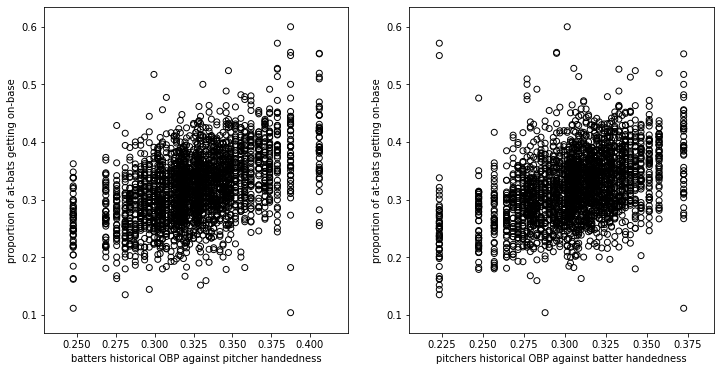

<IPython.core.display.Javascript object>

In [182]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(
    df_sc_all_preprocess_wbat_wpitch_4model_agg["batter_cat"],
    df_sc_all_preprocess_wbat_wpitch_4model_agg["event_mean"],
    facecolors="none",
    edgecolors="black",
)
ax1.set_xlabel("batters historical OBP against pitcher handedness")
ax1.set_ylabel("proportion of at-bats getting on-base")

ax2.scatter(
    df_sc_all_preprocess_wbat_wpitch_4model_agg["pitcher_cat"],
    df_sc_all_preprocess_wbat_wpitch_4model_agg["event_mean"],
    facecolors="none",
    edgecolors="black",
)
ax2.set_xlabel("pitchers historical OBP against batter handedness")
ax2.set_ylabel("proportion of at-bats getting on-base")

### Run LM model

In [187]:
df_sc_all_preprocess_wbat_wpitch_4model_agg.isnull().sum()

event_mean     6
batter_cat     0
pitcher_cat    0
dtype: int64

<IPython.core.display.Javascript object>

In [189]:
# Drop rows with missing value
df_sc_all_preprocess_wbat_wpitch_4model_agg.dropna(axis=0, inplace=True)

<IPython.core.display.Javascript object>

In [190]:
df_sc_all_preprocess_wbat_wpitch_4model_agg.shape

(2494, 3)

<IPython.core.display.Javascript object>

In [191]:
feature_col_now = [
    "batter_cat",
    "pitcher_cat",
]

feature_col = feature_col_now
target_col = "event_mean"

X_ob_oa = df_sc_all_preprocess_wbat_wpitch_4model_agg[feature_col].copy()
y_ob_oa = df_sc_all_preprocess_wbat_wpitch_4model_agg[target_col].copy()


<IPython.core.display.Javascript object>

In [192]:
(
    X_ob_oa_scale_train,
    X_ob_oa_scale_test,
    y_ob_oa_train,
    y_ob_oa_test,
    scale_ob,
) = get_split_data(X_ob_oa, y_ob_oa, 0.4)

<IPython.core.display.Javascript object>

In [193]:
lin_reg_v2, df_eval_v2 = run_linreg_model(
    X_ob_oa_scale_train, y_ob_oa_train, X_ob_oa_scale_test, y_ob_oa_test
)

<IPython.core.display.Javascript object>

In [194]:
df_eval_v2.head()

test      pred
540   0.223529  0.322786
1682  0.366197  0.343451
1545  0.333333  0.362055
590   0.393258  0.324128
854   0.253165  0.277632

<IPython.core.display.Javascript object>

Text(0, 0.5, 'prediction')

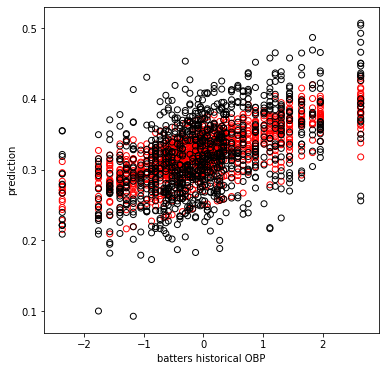

<IPython.core.display.Javascript object>

In [146]:
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
ax1.scatter(
    X_ob_oa_scale_test[:, 0], df_eval_v2["pred"], facecolors="none", edgecolors="red",
)

ax1.scatter(
    X_ob_oa_scale_test[:, 0], df_eval_v2["test"], facecolors="none", edgecolors="black",
)

ax1.set_xlabel("batters historical OBP")
ax1.set_ylabel("prediction")

In [195]:
metrics.r2_score(df_eval_v2["test"], df_eval_v2["pred"])

0.43286029552329564

<IPython.core.display.Javascript object>

# Determining right number of qcuts

In [ ]:
preprocess_col = [
    "onbase_event",
    "prop_onbase_event_overall_x",
    "prop_onbase_event_overall_y",
]

df_sc_all_preprocess_wbat_wpitch_4model = df_sc_all_preprocess_wbat_wpitch[
    preprocess_col
].copy()


No of cuts:  5
R2 score: 0.9936631794476001
No of cuts:  10
R2 score: 0.9196557678876578
No of cuts:  15
R2 score: 0.9175919219565578
No of cuts:  20
R2 score: 0.8342391892521545
No of cuts:  25
R2 score: 0.7695520076715783
No of cuts:  30
R2 score: 0.6848728701005476
No of cuts:  35
R2 score: 0.5934721751413012
No of cuts:  40
R2 score: 0.5417603405300049
No of cuts:  45
R2 score: 0.47596904031295983
No of cuts:  50
R2 score: 0.4502250876079835


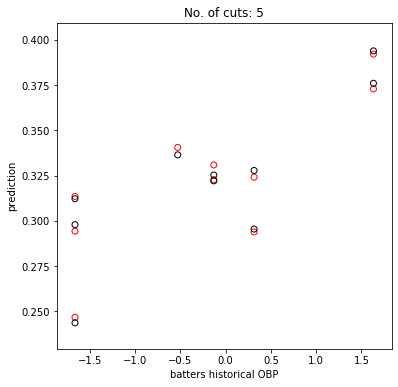

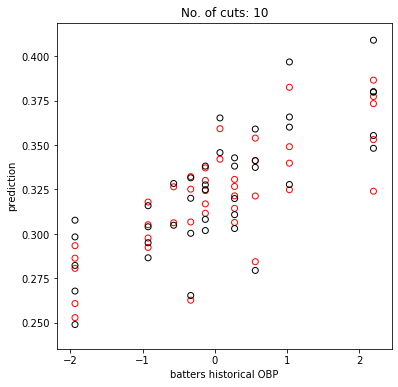

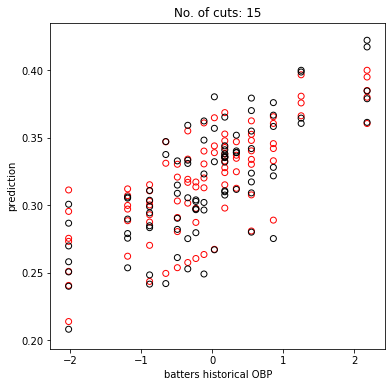

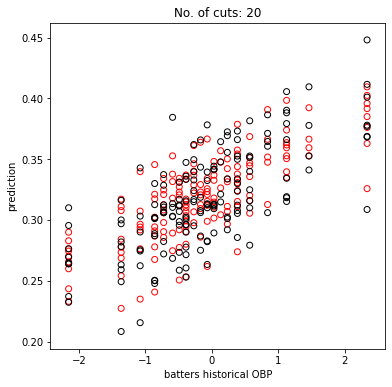

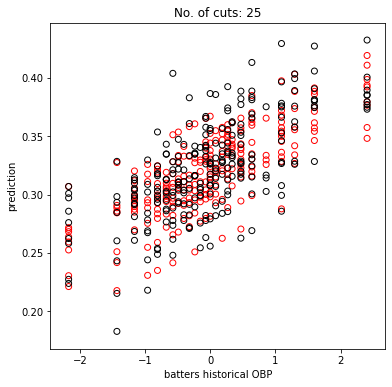

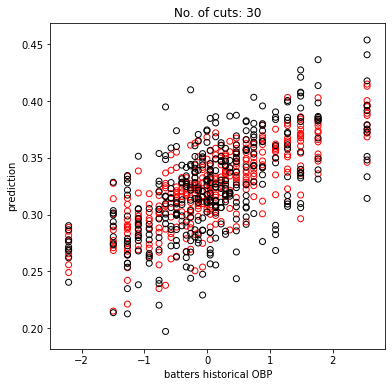

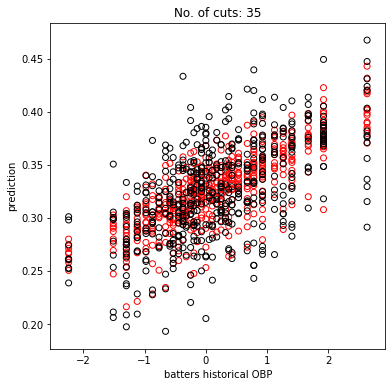

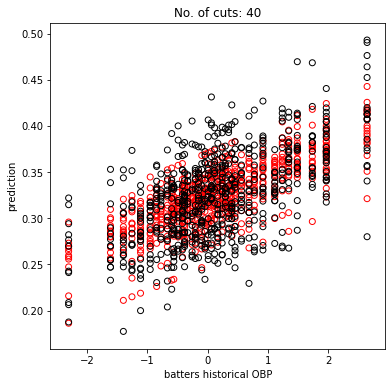

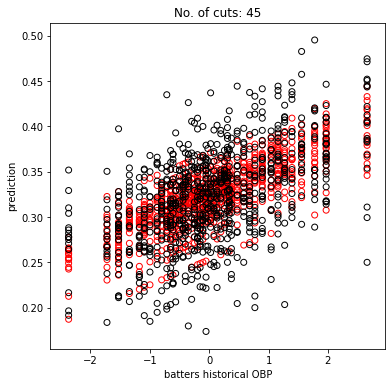

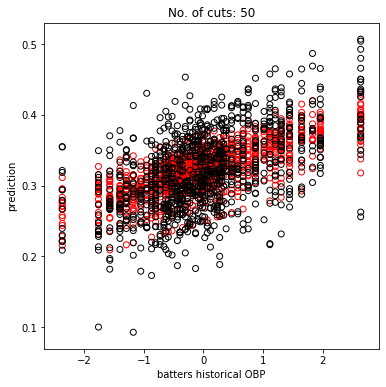

<IPython.core.display.Javascript object>

In [276]:
r2_list = list()
for no_cuts in range(5, 55, 5):
    print("No of cuts: ", no_cuts)

    # Bin these so that the most frequent categories are subdivided more
    df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_batter"] = pd.qcut(
        df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_event_overall_x"], no_cuts
    )
    df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_pitcher"] = pd.qcut(
        df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_event_overall_y"], no_cuts
    )

    no_avg_batters = (
        df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_batter"]
        .value_counts()
        .mean()
    )
    no_avg_pitchers = (
        df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_pitcher"]
        .value_counts()
        .mean()
    )

    #     print(
    #         "Avg. of batters and pitchers, respectively: ", no_avg_batters, no_avg_pitchers
    #     )

    #     print(
    #         "Avg. of batter/pitcher intersection bin: ",
    #         no_avg_batters / no_cuts,
    #         no_avg_pitchers / no_cuts,
    #     )

    df_sc_all_preprocess_wbat_wpitch_4model_agg = get_df_binned_4model(
        df_sc_all_preprocess_wbat_wpitch_4model,
        "prop_onbase_batter",
        "prop_onbase_pitcher",
        "onbase_event",
    )

    # Remove rows with null values
    df_sc_all_preprocess_wbat_wpitch_4model_agg.dropna(axis=0, inplace=True)
    #     print(
    #         "Shape of aggregated dataframe after removing null: ",
    #         df_sc_all_preprocess_wbat_wpitch_4model_agg.shape,
    #     )

    feature_col_now = [
        "batter_cat",
        "pitcher_cat",
    ]

    feature_col = feature_col_now
    target_col = "event_mean"

    X_ob_oa = df_sc_all_preprocess_wbat_wpitch_4model_agg[feature_col].copy()
    y_ob_oa = df_sc_all_preprocess_wbat_wpitch_4model_agg[target_col].copy()

    (
        X_ob_oa_scale_train,
        X_ob_oa_scale_test,
        y_ob_oa_train,
        y_ob_oa_test,
        scale_ob,
    ) = get_split_data(X_ob_oa, y_ob_oa, 0.4)

    lin_reg_vCheck, df_eval_vCheck = run_linreg_model(
        X_ob_oa_scale_train, y_ob_oa_train, X_ob_oa_scale_test, y_ob_oa_test
    )

    print(
        colored(
            "R2 score: "
            + str(metrics.r2_score(df_eval_vCheck["test"], df_eval_vCheck["pred"])),
            "red",
        )
    )

    r2_list.append(metrics.r2_score(df_eval_vCheck["test"], df_eval_vCheck["pred"]))

    f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
    ax1.scatter(
        X_ob_oa_scale_test[:, 0],
        df_eval_vCheck["pred"],
        facecolors="none",
        edgecolors="red",
    )

    ax1.scatter(
        X_ob_oa_scale_test[:, 0],
        df_eval_vCheck["test"],
        facecolors="none",
        edgecolors="black",
    )

    ax1.set_xlabel("batters historical OBP")
    ax1.set_ylabel("prediction")
    ax1.set_title("No. of cuts: " + str(no_cuts))

### Adding handedness



In [226]:
r2_list_h = list()

<IPython.core.display.Javascript object>

In [227]:
for no_cuts in range(5, 50, 5):
    print("No of cuts: ", no_cuts)

    preprocess_col = [
        "onbase_event",
        "prop_onbase_event_overall_x",
        "prop_onbase_event_overall_y",
    ]

    df_sc_all_preprocess_wbat_wpitch_4model = df_sc_all_preprocess_wbat_wpitch[
        preprocess_col
    ].copy()

    df_sc_all_preprocess_wbat_wpitch_4model = make_handedness_specific_df(
        df_sc_all_preprocess_wbat_wpitch, df_sc_all_preprocess_wbat_wpitch_4model
    )

    # Bin these so that the most frequent categories are subdivided more
    df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_batter"] = pd.qcut(
        df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_event_p_throws_handcomp"],
        no_cuts,
    )
    df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_pitcher"] = pd.qcut(
        df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_event_stand_handcomp"],
        no_cuts,
    )

    no_avg_batters = (
        df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_batter"]
        .value_counts()
        .mean()
    )
    no_avg_pitchers = (
        df_sc_all_preprocess_wbat_wpitch_4model["prop_onbase_pitcher"]
        .value_counts()
        .mean()
    )

    print(
        "Avg. of batters and pitchers, respectively: ", no_avg_batters, no_avg_pitchers
    )

    print(
        "Avg. of batter/pitcher intersection bin: ",
        no_avg_batters / no_cuts,
        no_avg_pitchers / no_cuts,
    )

    df_sc_all_preprocess_wbat_wpitch_4model_agg = get_df_binned_4model(
        df_sc_all_preprocess_wbat_wpitch_4model,
        "prop_onbase_batter",
        "prop_onbase_pitcher",
        "onbase_event",
    )

    # Remove rows with null values
    df_sc_all_preprocess_wbat_wpitch_4model_agg.dropna(axis=0, inplace=True)
    print(
        "Shape of aggregated dataframe after removing null: ",
        df_sc_all_preprocess_wbat_wpitch_4model_agg.shape,
    )

    feature_col_now = [
        "batter_cat",
        "pitcher_cat",
    ]

    feature_col = feature_col_now
    target_col = "event_mean"

    X_ob_oa = df_sc_all_preprocess_wbat_wpitch_4model_agg[feature_col].copy()
    y_ob_oa = df_sc_all_preprocess_wbat_wpitch_4model_agg[target_col].copy()

    (
        X_ob_oa_scale_train,
        X_ob_oa_scale_test,
        y_ob_oa_train,
        y_ob_oa_test,
        scale_ob,
    ) = get_split_data(X_ob_oa, y_ob_oa, 0.4)

    lin_reg_vCheck, df_eval_vCheck = run_linreg_model(
        X_ob_oa_scale_train, y_ob_oa_train, X_ob_oa_scale_test, y_ob_oa_test
    )

    print(
        colored(
            "R2 score: "
            + str(metrics.r2_score(df_eval_vCheck["test"], df_eval_vCheck["pred"])),
            "red",
        )
    )

    r2_list_h.append(metrics.r2_score(df_eval_vCheck["test"], df_eval_vCheck["pred"]))

#     f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
#     ax1.scatter(
#         X_ob_oa_scale_test[:, 0],
#         df_eval_vCheck["pred"],
#         facecolors="none",
#         edgecolors="red",
#     )

#     ax1.scatter(
#         X_ob_oa_scale_test[:, 0],
#         df_eval_vCheck["test"],
#         facecolors="none",
#         edgecolors="black",
#     )

#     ax1.set_xlabel("batters historical OBP")
#     ax1.set_ylabel("prediction")
#     ax1.set_title("No. of cuts: " + str(no_cuts))

No of cuts:  5
Avg. of batters and pitchers, respectively:  64961.2 64961.2
Avg. of batter/pitcher intersection bin:  12992.24 12992.24
Shape of aggregated dataframe after removing null:  (25, 3)
R2 score: 0.9832997680939355
No of cuts:  10
Avg. of batters and pitchers, respectively:  32480.6 32480.6
Avg. of batter/pitcher intersection bin:  3248.06 3248.06
Shape of aggregated dataframe after removing null:  (100, 3)
R2 score: 0.9312307039504928
No of cuts:  15
Avg. of batters and pitchers, respectively:  21653.733333333334 21653.733333333334
Avg. of batter/pitcher intersection bin:  1443.5822222222223 1443.5822222222223
Shape of aggregated dataframe after removing null:  (225, 3)
R2 score: 0.9251557910478312
No of cuts:  20
Avg. of batters and pitchers, respectively:  16240.3 16240.3
Avg. of batter/pitcher intersection bin:  812.015 812.015
Shape of aggregated dataframe after removing null:  (400, 3)
R2 score: 0.8284591241258483
No of cuts:  25
Avg. of batters and pitchers, respective

<IPython.core.display.Javascript object>

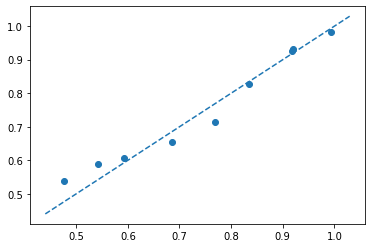

<IPython.core.display.Javascript object>

In [229]:
f, ax1 = plt.subplots()
ax1.scatter(r2_list, r2_list_h)
abline(1, 0, ax1)

In [231]:
df_r2_compare = pd.DataFrame(
    {"no_cuts": range(5, 50, 5), "no_hand": r2_list, "hand": r2_list_h}
)
df_r2_compare

no_cuts   no_hand      hand
0        5  0.993663  0.983300
1       10  0.919656  0.931231
2       15  0.917592  0.925156
3       20  0.834239  0.828459
4       25  0.769552  0.715669
5       30  0.684873  0.654168
6       35  0.593472  0.605494
7       40  0.541760  0.589375
8       45  0.475969  0.539596

<IPython.core.display.Javascript object>

# Evaluate bin sizes for all events

In [ ]:
df_sc_all_preprocess_wbat_wpitch

In [298]:
def get_no_cuts_check(event_type, df):

    preprocess_col = [
        event_type + "_event",
        "prop_" + event_type + "_event_overall_x",
        "prop_" + event_type + "_event_overall_y",
    ]

    df_4model = df[preprocess_col].copy()

    # Overall ---------

    cut_range = range(5, 55, 5)
    no_avg_b_p_list = list()
    no_bp_int_list = list()
    r2_list = list()
    r2_list_h = list()
    r2_list_htr = list()

    for no_cuts in cut_range:
        print("No of cuts: ", no_cuts)

        # Bin these so that the most frequent categories are subdivided more
        df_4model["prop_" + event_type + "_batter"] = pd.qcut(
            df_4model["prop_" + event_type + "_event_overall_x"], no_cuts
        )
        df_4model["prop_" + event_type + "_pitcher"] = pd.qcut(
            df_4model["prop_" + event_type + "_event_overall_y"], no_cuts
        )

        no_avg_batters = (
            df_4model["prop_" + event_type + "_batter"].value_counts().mean()
        )
        no_avg_pitchers = (
            df_4model["prop_" + event_type + "_pitcher"].value_counts().mean()
        )

        # no_avg_b_p_list.append((no_avg_batters, no_avg_pitchers))  # gives same value
        no_avg_b_p_list.append(no_avg_batters)

        # no_bp_int_list.append((no_avg_batters / no_cuts, no_avg_pitchers / no_cuts))  # gives same value
        no_bp_int_list.append(no_avg_batters / no_cuts)

        df_4model_agg = get_df_binned_4model(
            df_4model,
            "prop_" + event_type + "_batter",
            "prop_" + event_type + "_pitcher",
            "" + event_type + "_event",
        )

        # Remove rows with null values
        df_4model_agg.dropna(axis=0, inplace=True)

        feature_col_now = [
            "batter_cat",
            "pitcher_cat",
        ]

        feature_col = feature_col_now
        target_col = "event_mean"

        X_ob_oa = df_4model_agg[feature_col].copy()
        y_ob_oa = df_4model_agg[target_col].copy()

        (
            X_ob_oa_scale_train,
            X_ob_oa_scale_test,
            y_ob_oa_train,
            y_ob_oa_test,
            scale_ob,
        ) = get_split_data(X_ob_oa, y_ob_oa, 0.4)

        lin_reg_vCheck, df_eval_vCheck = run_linreg_model(
            X_ob_oa_scale_train, y_ob_oa_train, X_ob_oa_scale_test, y_ob_oa_test
        )

        r2_list.append(metrics.r2_score(df_eval_vCheck["test"], df_eval_vCheck["pred"]))

        # Handedness ---------

        df_4model = make_handedness_specific_df(df, df_4model, event_type)

        # Bin these so that the most frequent categories are subdivided more
        df_4model["prop_" + event_type + "_batter"] = pd.qcut(
            df_4model["prop_" + event_type + "_event_p_throws_handcomp"], no_cuts,
        )
        df_4model["prop_" + event_type + "_pitcher"] = pd.qcut(
            df_4model["prop_" + event_type + "_event_stand_handcomp"], no_cuts,
        )

        no_avg_batters = (
            df_4model["prop_" + event_type + "_batter"].value_counts().mean()
        )
        no_avg_pitchers = (
            df_4model["prop_" + event_type + "_pitcher"].value_counts().mean()
        )

        df_4model_agg = get_df_binned_4model(
            df_4model,
            "prop_" + event_type + "_batter",
            "prop_" + event_type + "_pitcher",
            "" + event_type + "_event",
        )

        # Remove rows with null values
        df_4model_agg.dropna(axis=0, inplace=True)

        feature_col_now = [
            "batter_cat",
            "pitcher_cat",
        ]

        feature_col = feature_col_now
        target_col = "event_mean"

        X_ob_oa = df_4model_agg[feature_col].copy()
        y_ob_oa = df_4model_agg[target_col].copy()

        (
            X_ob_oa_scale_train,
            X_ob_oa_scale_test,
            y_ob_oa_train,
            y_ob_oa_test,
            scale_ob,
        ) = get_split_data(X_ob_oa, y_ob_oa, 0.4)

        lin_reg_vCheck, df_eval_vCheck = run_linreg_model(
            X_ob_oa_scale_train, y_ob_oa_train, X_ob_oa_scale_test, y_ob_oa_test
        )

        r2_list_h.append(
            metrics.r2_score(df_eval_vCheck["test"], df_eval_vCheck["pred"])
        )

        # Handedness with transformation
        X_ob_oa = np.log(df_4model_agg[feature_col].copy())
        y_ob_oa = np.log(df_4model_agg[target_col].copy())

        (
            X_ob_oa_scale_train,
            X_ob_oa_scale_test,
            y_ob_oa_train,
            y_ob_oa_test,
            scale_ob,
        ) = get_split_data(X_ob_oa, y_ob_oa, 0.4)

        try:
            lin_reg_vCheck, df_eval_vCheck = run_linreg_model(
                X_ob_oa_scale_train, y_ob_oa_train, X_ob_oa_scale_test, y_ob_oa_test
            )
        except:
            df_eval_vCheck = None

        try:
            r2_list_htr.append(
                metrics.r2_score(df_eval_vCheck["test"], df_eval_vCheck["pred"])
            )
        except:
            r2_list_htr.append(None)

    # Summary
    df_eval_summary = pd.DataFrame()
    df_eval_summary["n_cuts"] = cut_range
    df_eval_summary["no_avg_b_p_list"] = no_avg_b_p_list
    df_eval_summary["no_bp_int_list"] = no_bp_int_list
    df_eval_summary["r2_list_o"] = r2_list
    df_eval_summary["r2_list_h"] = r2_list_h
    df_eval_summary["r2_diff_h_o"] = (
        df_eval_summary["r2_list_h"] - df_eval_summary["r2_list_o"]
    )
    df_eval_summary["r2_list_htr"] = r2_list_htr
    df_eval_summary["r2_diff_htr_h"] = (
        df_eval_summary["r2_list_htr"] - df_eval_summary["r2_list_h"]
    )

    return df_eval_summary

<IPython.core.display.Javascript object>

In [285]:
df_onbase_summary = get_no_cuts_check("onbase", df_sc_all_preprocess_wbat_wpitch)
df_onbase_summary

No of cuts:  5
No of cuts:  10
No of cuts:  15
No of cuts:  20
No of cuts:  25
No of cuts:  30
No of cuts:  35
No of cuts:  40
No of cuts:  45
No of cuts:  50


n_cuts  no_avg_b_p_list  no_bp_int_list  r2_list_o  r2_list_h  r2_diff_h_o  \
0       5     64961.200000    12992.240000   0.993663   0.983300    -0.010363   
1      10     32480.600000     3248.060000   0.919656   0.931231     0.011575   
2      15     21653.733333     1443.582222   0.917592   0.925156     0.007564   
3      20     16240.300000      812.015000   0.834239   0.828459    -0.005780   
4      25     12992.240000      519.689600   0.769552   0.715669    -0.053883   
5      30     10826.866667      360.895556   0.684873   0.654168    -0.030705   
6      35      9280.171429      265.147755   0.593472   0.605494     0.012022   
7      40      8120.150000      203.003750   0.541760   0.589375     0.047615   
8      45      7217.911111      160.398025   0.475969   0.539596     0.063627   
9      50      6496.120000      129.922400   0.450225   0.432860    -0.017365   

   r2_list_htr  r2_diff_htr_h  
0     0.974646      -0.008653  
1     0.928476      -0.002755  
2     0.922768      -0.002388  
3     0.834657       0.006197  
4     0.719587       0.003919  
5     0.667497       0.013329  
6     0.603521      -0.001973  
7     0.593280       0.003905  
8     0.535867      -0.003729  
9     0.431297      -0.001563

<IPython.core.display.Javascript object>

In [299]:
df_walk_summary = get_no_cuts_check("walk", df_sc_all_preprocess_wbat_wpitch)
df_walk_summary

No of cuts:  5
No of cuts:  10
No of cuts:  15
No of cuts:  20
No of cuts:  25
No of cuts:  30
No of cuts:  35
No of cuts:  40


/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


No of cuts:  45


/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


No of cuts:  50


/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


n_cuts  no_avg_b_p_list  no_bp_int_list  r2_list_o  r2_list_h  r2_diff_h_o  \
0       5     64961.200000    12992.240000   0.941278   0.915150    -0.026128   
1      10     32480.600000     3248.060000   0.938210   0.915545    -0.022666   
2      15     21653.733333     1443.582222   0.923510   0.943055     0.019545   
3      20     16240.300000      812.015000   0.883377   0.883260    -0.000117   
4      25     12992.240000      519.689600   0.842184   0.851849     0.009666   
5      30     10826.866667      360.895556   0.794352   0.797349     0.002997   
6      35      9280.171429      265.147755   0.769221   0.750016    -0.019205   
7      40      8120.150000      203.003750   0.713680   0.688884    -0.024796   
8      45      7217.911111      160.398025   0.656827   0.621050    -0.035777   
9      50      6496.120000      129.922400   0.601237   0.556855    -0.044381   

   r2_list_htr  r2_diff_htr_h  
0     0.974361       0.059210  
1     0.969346       0.053801  
2     0.940279      -0.002776  
3     0.907724       0.024464  
4     0.855355       0.003505  
5     0.791064      -0.006285  
6     0.744069      -0.005947  
7          NaN            NaN  
8          NaN            NaN  
9          NaN            NaN

<IPython.core.display.Javascript object>

In [300]:
df_single_summary = get_no_cuts_check("single", df_sc_all_preprocess_wbat_wpitch)
df_single_summary

No of cuts:  5
No of cuts:  10
No of cuts:  15
No of cuts:  20
No of cuts:  25
No of cuts:  30
No of cuts:  35
No of cuts:  40
No of cuts:  45


/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


No of cuts:  50


n_cuts  no_avg_b_p_list  no_bp_int_list  r2_list_o  r2_list_h  r2_diff_h_o  \
0       5     64961.200000    12992.240000   0.975499   0.956062    -0.019437   
1      10     32480.600000     3248.060000   0.956426   0.944357    -0.012070   
2      15     21653.733333     1443.582222   0.916631   0.913327    -0.003305   
3      20     16240.300000      812.015000   0.850805   0.867598     0.016793   
4      25     12992.240000      519.689600   0.751765   0.827766     0.076001   
5      30     10826.866667      360.895556   0.705633   0.725729     0.020096   
6      35      9280.171429      265.147755   0.634787   0.669059     0.034272   
7      40      8120.150000      203.003750   0.603856   0.623404     0.019548   
8      45      7217.911111      160.398025   0.544407   0.560667     0.016260   
9      50      6496.120000      129.922400   0.467035   0.489973     0.022938   

   r2_list_htr  r2_diff_htr_h  
0     0.959447       0.003385  
1     0.947400       0.003043  
2     0.913723       0.000397  
3     0.851381      -0.016218  
4     0.828308       0.000541  
5     0.734588       0.008860  
6     0.660859      -0.008200  
7     0.630140       0.006736  
8          NaN            NaN  
9     0.499654       0.009681

<IPython.core.display.Javascript object>

In [301]:
df_double_summary = get_no_cuts_check("double", df_sc_all_preprocess_wbat_wpitch)
df_double_summary

No of cuts:  5
No of cuts:  10
No of cuts:  15
No of cuts:  20
No of cuts:  25
No of cuts:  30
No of cuts:  35


/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


No of cuts:  40


/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


No of cuts:  45


/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


No of cuts:  50


/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


n_cuts  no_avg_b_p_list  no_bp_int_list  r2_list_o  r2_list_h  r2_diff_h_o  \
0       5     64961.200000    12992.240000   0.943176   0.941578    -0.001597   
1      10     32480.600000     3248.060000   0.827690   0.853202     0.025511   
2      15     21653.733333     1443.582222   0.764789   0.824896     0.060107   
3      20     16240.300000      812.015000   0.605948   0.687428     0.081480   
4      25     12992.240000      519.689600   0.531359   0.620529     0.089170   
5      30     10826.866667      360.895556   0.404133   0.503013     0.098880   
6      35      9280.171429      265.147755   0.360601   0.444944     0.084343   
7      40      8120.150000      203.003750   0.286895   0.329824     0.042929   
8      45      7217.911111      160.398025   0.252241   0.320400     0.068160   
9      50      6496.120000      129.922400   0.202389   0.260433     0.058044   

   r2_list_htr  r2_diff_htr_h  
0     0.982495       0.040917  
1     0.856612       0.003410  
2     0.830934       0.006038  
3     0.731927       0.044498  
4     0.611713      -0.008816  
5     0.522673       0.019660  
6          NaN            NaN  
7          NaN            NaN  
8          NaN            NaN  
9          NaN            NaN

<IPython.core.display.Javascript object>

In [302]:
df_homerun_summary = get_no_cuts_check("homerun", df_sc_all_preprocess_wbat_wpitch)
df_homerun_summary

No of cuts:  5
No of cuts:  10
No of cuts:  15
No of cuts:  20
No of cuts:  25


/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


No of cuts:  30


/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


No of cuts:  35


/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


No of cuts:  40


/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


No of cuts:  45


/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


No of cuts:  50


/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


n_cuts  no_avg_b_p_list  no_bp_int_list  r2_list_o  r2_list_h  r2_diff_h_o  \
0       5     64961.200000    12992.240000   0.934562   0.887175    -0.047387   
1      10     32480.600000     3248.060000   0.946170   0.868201    -0.077969   
2      15     21653.733333     1443.582222   0.906913   0.873731    -0.033182   
3      20     16240.300000      812.015000   0.823173   0.862063     0.038891   
4      25     12992.240000      519.689600   0.767260   0.747648    -0.019613   
5      30     10826.866667      360.895556   0.663932   0.710508     0.046576   
6      35      9280.171429      265.147755   0.661739   0.672958     0.011219   
7      40      8120.150000      203.003750   0.582112   0.597324     0.015212   
8      45      7217.911111      160.398025   0.550606   0.557542     0.006936   
9      50      6496.120000      129.922400   0.466846   0.465398    -0.001448   

   r2_list_htr  r2_diff_htr_h  
0     0.963593       0.076418  
1     0.937178       0.068977  
2     0.884086       0.010355  
3     0.861408      -0.000656  
4          NaN            NaN  
5          NaN            NaN  
6          NaN            NaN  
7          NaN            NaN  
8          NaN            NaN  
9          NaN            NaN

<IPython.core.display.Javascript object>

In [303]:
df_strikeout_summary = get_no_cuts_check("strikeout", df_sc_all_preprocess_wbat_wpitch)
df_strikeout_summary

No of cuts:  5
No of cuts:  10
No of cuts:  15
No of cuts:  20
No of cuts:  25
No of cuts:  30
No of cuts:  35
No of cuts:  40
No of cuts:  45
No of cuts:  50


n_cuts  no_avg_b_p_list  no_bp_int_list  r2_list_o  r2_list_h  r2_diff_h_o  \
0       5     64961.200000    12992.240000   0.934030   0.919835    -0.014195   
1      10     32480.600000     3248.060000   0.941914   0.934396    -0.007517   
2      15     21653.733333     1443.582222   0.951128   0.944998    -0.006130   
3      20     16240.300000      812.015000   0.944455   0.925033    -0.019423   
4      25     12992.240000      519.689600   0.918687   0.923029     0.004342   
5      30     10826.866667      360.895556   0.880803   0.876840    -0.003963   
6      35      9280.171429      265.147755   0.875955   0.864502    -0.011453   
7      40      8120.150000      203.003750   0.842757   0.840021    -0.002736   
8      45      7217.911111      160.398025   0.812635   0.810862    -0.001773   
9      50      6496.120000      129.922400   0.759085   0.770056     0.010970   

   r2_list_htr  r2_diff_htr_h  
0     0.983436       0.063602  
1     0.963078       0.028681  
2     0.975462       0.030464  
3     0.947364       0.022332  
4     0.942675       0.019645  
5     0.897232       0.020393  
6     0.859386      -0.005116  
7     0.820665      -0.019356  
8     0.810829      -0.000033  
9     0.739617      -0.030439

<IPython.core.display.Javascript object>

# Get model parameters and calculate uncertainty

In [314]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

<IPython.core.display.Javascript object>

In [604]:
def return_xy_for_uncertainty(event_type, df):
    '''
    # Returning X, y splits using bins with 40 cuts
    '''

    preprocess_col = [
        event_type + "_event",
        "prop_" + event_type + "_event_overall_x",
        "prop_" + event_type + "_event_overall_y",
    ]

    df_4model = df[preprocess_col].copy()

    # Overall ---------

    no_cuts = 40

    # Bin these so that the most frequent categories are subdivided more
    df_4model["prop_" + event_type + "_batter"] = pd.qcut(
        df_4model["prop_" + event_type + "_event_overall_x"], no_cuts
    )
    df_4model["prop_" + event_type + "_pitcher"] = pd.qcut(
        df_4model["prop_" + event_type + "_event_overall_y"], no_cuts
    )

    no_avg_batters = df_4model["prop_" + event_type + "_batter"].value_counts().mean()
    no_avg_pitchers = df_4model["prop_" + event_type + "_pitcher"].value_counts().mean()

    df_4model_agg = get_df_binned_4model(
        df_4model,
        "prop_" + event_type + "_batter",
        "prop_" + event_type + "_pitcher",
        "" + event_type + "_event",
    )

    # Remove rows with null values
    df_4model_agg.dropna(axis=0, inplace=True)

    feature_col_now = [
        "batter_cat",
        "pitcher_cat",
    ]

    feature_col = feature_col_now
    target_col = "event_mean"

    X_ob_oa = df_4model_agg[feature_col].copy()
    y_ob_oa = df_4model_agg[target_col].copy()

    (
        X_ob_oa_scale_train,
        X_ob_oa_scale_test,
        y_ob_oa_train,
        y_ob_oa_test,
        scale_ob,
    ) = get_split_data(X_ob_oa, y_ob_oa, 0.4)

    return (
        X_ob_oa_scale_train,
        y_ob_oa_train,
        X_ob_oa_scale_test,
        y_ob_oa_test,
        scale_ob,
    )

<IPython.core.display.Javascript object>

In [ ]:
# used in testing
# (
#     X_4ols,
#     y_4ols,
#     X_new4ols,
#     y_new4ols,
# ) = return_xy_for_uncertainty("onbase", df_sc_all_preprocess_wbat_wpitch)

In [606]:
(
    X_4ols_onbase,
    y_4ols_onbase,
    X_new4ols_onbase,
    y_new4ols_onbase,
    scale_onbase,
) = return_xy_for_uncertainty("onbase", df_sc_all_preprocess_wbat_wpitch)

<IPython.core.display.Javascript object>

In [607]:
(
    X_4ols_walk,
    y_4ols_walk,
    X_new4ols_walk,
    y_new4ols_walk,
    scale_walk,
) = return_xy_for_uncertainty("walk", df_sc_all_preprocess_wbat_wpitch)

<IPython.core.display.Javascript object>

In [608]:
(
    X_4ols_single,
    y_4ols_single,
    X_new4ols_single,
    y_new4ols_single,
    scale_single,
) = return_xy_for_uncertainty("single", df_sc_all_preprocess_wbat_wpitch)

<IPython.core.display.Javascript object>

In [609]:
(
    X_4ols_double,
    y_4ols_double,
    X_new4ols_double,
    y_new4ols_double,
    scale_double,
) = return_xy_for_uncertainty("double", df_sc_all_preprocess_wbat_wpitch)

<IPython.core.display.Javascript object>

In [610]:
(
    X_4ols_homerun,
    y_4ols_homerun,
    X_new4ols_homerun,
    y_new4ols_homerun,
    scale_homerun,
) = return_xy_for_uncertainty("homerun", df_sc_all_preprocess_wbat_wpitch)

<IPython.core.display.Javascript object>

In [611]:
(
    X_4ols_strikeout,
    y_4ols_strikeout,
    X_new4ols_strikeout,
    y_new4ols_strikeout,
    scale_strikeout,
) = return_xy_for_uncertainty("strikeout", df_sc_all_preprocess_wbat_wpitch)

<IPython.core.display.Javascript object>

In [ ]:
# # Example
# X = df_adv[['TV', 'Radio']] y = df_adv['Sales']
# ## fit a OLS model with intercept on TV and Radio
# X = sm.add_constant(X)
# est = sm.OLS(y, X).fit()
# est.summary()

In [351]:
def train_models_for_export(X_train, y_train, X_new, y_new):

    # Construct dataframe for use in statsmodels - train model with training set
    X_train_wconstant = sm.add_constant(X_train)
    est = sm.OLS(y_train, X_train_wconstant).fit()

    # Make prediction
    #     X_new_wconstant = sm.add_constant(X_new)
    #     est_prediction = est.get_prediction(X_new_wconstant)
    #     est_prediction_mean = est_model_fit_prediction.predicted_mean
    #     est_prediction_se_obs = est_model_fit_prediction.se_obs

    # Get scikit-learn's prediction
    lin_reg_model, df_eval_model = run_linreg_model(X_train, y_train, X_new, y_new)
    #    sklearn_pred = df_eval_model["pred"].tolist()

    #     df_summary = pd.DataFrame(
    #         {
    #             "sm_pred": est_prediction_mean,
    #             "sm_se": est_prediction_se_obs,
    #             "sm_mean_minus_se": est_prediction_mean - est_prediction_se_obs,
    #             "sm_mean_plus_se": est_prediction_mean + est_prediction_se_obs,
    #             "sklearn_pred": sklearn_pred,
    #         }
    #     )

    return est, lin_reg_model

<IPython.core.display.Javascript object>

In [355]:
# Used in testing
# sm_est_model, skl_linreg_model = train_models_for_export(
#     X_4ols, y_4ols, X_new4ols, y_new4ols
# )

<IPython.core.display.Javascript object>

In [421]:
sm_est_model_onbase, skl_linreg_model_onbase = train_models_for_export(
    X_4ols_onbase, y_4ols_onbase, X_new4ols_onbase, y_new4ols_onbase
)

<IPython.core.display.Javascript object>

In [423]:
sm_est_model_walk, skl_linreg_model_walk = train_models_for_export(
    X_4ols_walk, y_4ols_walk, X_new4ols_walk, y_new4ols_walk
)

<IPython.core.display.Javascript object>

In [424]:
sm_est_model_single, skl_linreg_model_single = train_models_for_export(
    X_4ols_single, y_4ols_single, X_new4ols_single, y_new4ols_single
)

<IPython.core.display.Javascript object>

In [425]:
sm_est_model_double, skl_linreg_model_double = train_models_for_export(
    X_4ols_double, y_4ols_double, X_new4ols_double, y_new4ols_double
)

<IPython.core.display.Javascript object>

In [426]:
sm_est_model_homerun, skl_linreg_model_homerun = train_models_for_export(
    X_4ols_homerun, y_4ols_homerun, X_new4ols_homerun, y_new4ols_homerun
)

<IPython.core.display.Javascript object>

In [427]:
sm_est_model_strikeout, skl_linreg_model_strikeout = train_models_for_export(
    X_4ols_strikeout, y_4ols_strikeout, X_new4ols_strikeout, y_new4ols_strikeout
)

<IPython.core.display.Javascript object>

In [340]:
# Used for verifying results between SM and SKlearn

# def get_prediction_se_obs(X_train, y_train, X_new, y_newa):

#     # Construct dataframe for use in statsmodels - train model with training set
#     X_train_wconstant = sm.add_constant(X_train)
#     est = sm.OLS(y_train, X_train_wconstant).fit()

#     # Make prediction
#     X_new_wconstant = sm.add_constant(X_new)
#     est_prediction = est.get_prediction(X_new_wconstant)
#     est_prediction_mean = est_model_fit_prediction.predicted_mean
#     est_prediction_se_obs = est_model_fit_prediction.se_obs

#     # Get scikit-learn's prediction
#     lin_reg_v0, df_eval_v0 = run_linreg_model(X_train, y_train, X_new, y_new)
#     sklearn_pred = df_eval_v0["pred"].tolist()

#     df_summary = pd.DataFrame(
#         {
#             "sm_pred": est_prediction_mean,
#             "sm_se": est_prediction_se_obs,
#             "sm_mean_minus_se": est_prediction_mean - est_prediction_se_obs,
#             "sm_mean_plus_se": est_prediction_mean + est_prediction_se_obs,
#             "sklearn_pred": sklearn_pred,
#         }
#     )

#     return df_summary

<IPython.core.display.Javascript object>

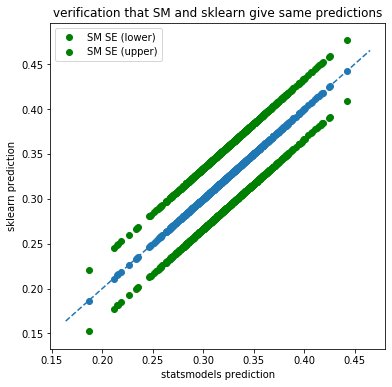

<IPython.core.display.Javascript object>

In [347]:
f, ax1 = plt.subplots(figsize=(6, 6))
ax1.scatter(df_summary_prediction["sm_pred"], df_summary_prediction["sklearn_pred"])
abline(1, 0, ax1)
ax1.set_title("verification that SM and sklearn give same predictions")
ax1.set_xlabel("statsmodels prediction")
ax1.set_ylabel("sklearn prediction")
ax1.scatter(
    df_summary_prediction["sm_pred"],
    df_summary_prediction["sm_mean_minus_se"],
    c="green",
    label="SM SE (lower)",
)


ax1.scatter(
    df_summary_prediction["sm_pred"],
    df_summary_prediction["sm_mean_plus_se"],
    c="green",
    label="SM SE (upper)",
)

ax1.legend()

# Moving towards production

### Saving model then re-importing for new predictions

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/




In [350]:
import pickle

<IPython.core.display.Javascript object>

In [ ]:
# Example 
# results = sm.OLS(data.endog, data.exog).fit()
# results.save("longley_results.pickle")

# # we should probably add a generic load to the main namespace
# from statsmodels.regression.linear_model import OLSResults
# new_results = OLSResults.load("longley_results.pickle")

# # or more generally
# from statsmodels.iolib.smpickle import load_pickle
# new_results = load_pickle("longley_results.pickle")

In [814]:
# Export
sm_est_model_onbase.save("sm_est_model_onbase_saved.pickle")
sm_est_model_walk.save("sm_est_model_walk_saved.pickle")
sm_est_model_single.save("sm_est_model_single_saved.pickle")
sm_est_model_double.save("sm_est_model_double_saved.pickle")
sm_est_model_homerun.save("sm_est_model_homerun_saved.pickle")
sm_est_model_strikeout.save("sm_est_model_strikeout_saved.pickle")

<IPython.core.display.Javascript object>

In [ ]:
# Load
from statsmodels.regression.linear_model import OLSResults


In [815]:
sm_est_model_onbase_loaded = OLSResults.load("sm_est_model_onbase_saved.pickle")
sm_est_model_walk_loaded = OLSResults.load("sm_est_model_walk_saved.pickle")
sm_est_model_single_loaded = OLSResults.load("sm_est_model_single_saved.pickle")
sm_est_model_double_loaded = OLSResults.load("sm_est_model_double_saved.pickle")
sm_est_model_homerun_loaded = OLSResults.load("sm_est_model_homerun_saved.pickle")
sm_est_model_strikeout_loaded = OLSResults.load("sm_est_model_strikeout_saved.pickle")

<IPython.core.display.Javascript object>

### Saving scaler, then re-importing

In [821]:
from sklearn.externals import joblib

<IPython.core.display.Javascript object>

In [ ]:
# from stack overflow
# from sklearn.externals import joblib 

# # this is more efficient than pickle for things like large numpy arrays
# # ... which sklearn models often have.   

# # then just 'dump' your file
# joblib.dump(clf, 'my_dope_model.pkl') 

In [828]:
# # Save scaler
# joblib.dump(scale_onbase, "scale_onbase_saved.pickle")
# joblib.dump(scale_walk, "scale_walk_saved.pickle")
# joblib.dump(scale_single, "scale_single_saved.pickle")
# joblib.dump(scale_double, "scale_double_saved.pickle")
# joblib.dump(scale_homerun, "scale_homerun_saved.pickle")
# joblib.dump(scale_strikeout, "scale_strikeout_saved.pickle")

['scale_strikeout_saved.pickle']

<IPython.core.display.Javascript object>

In [829]:
# Load scaler
scale_onbase_loaded = joblib.load("scale_onbase_saved.pickle")
scale_walk_loaded = joblib.load("scale_walk_saved.pickle")
scale_single_loaded = joblib.load("scale_single_saved.pickle")
scale_double_loaded = joblib.load("scale_double_saved.pickle")
scale_homerun_loaded = joblib.load("scale_homerun_saved.pickle")
scale_strikeout_loaded = joblib.load("scale_strikeout_saved.pickle")

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.externals import joblib
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 

# And now to load...

scaler = joblib.load(scaler_filename) 

## New predictions

In [741]:
# Mimic production directory
os.chdir(
    "/Users/lacar/Documents/Goals_and_careers/Edu_Data_Science/Insight/dev_setup_and_project/flask_insight_notes/flask_baseball/"
)

<IPython.core.display.Javascript object>

In [747]:
# Made player name to search
# df_player_id["name2search"] = df_player_id["name_first"] + df_player_id["name_last"]
# df_player_id.to_csv("df_player_id.csv", index=True)

<IPython.core.display.Javascript object>

In [751]:
df_player_id = pd.read_csv("df_player_id.csv", index_col=0)
df_player_id.head()

index name_last name_first  key_mlbam key_retro  key_bbref  key_fangraphs  \
0      0      abad   fernando     472551  abadf001   abadfe01           4994   
1      1     abreu      bryan     650556  abreb002  abreubr01          16609   
2      2     abreu       jose     547989  abrej003  abreujo02          15676   
3      3     acuna     ronald     660670  acunr001  acunaro01          18401   
4      4      adam      jason     592094  adamj002   adamja01          11861   

   mlb_played_first  mlb_played_last   name2search  
0            2010.0           2019.0  fernandoabad  
1            2019.0           2019.0    bryanabreu  
2            2014.0           2019.0     joseabreu  
3            2018.0           2019.0   ronaldacuna  
4            2018.0           2019.0     jasonadam

<IPython.core.display.Javascript object>

In [772]:
# df_player_id[df_player_id["name2search"].duplicated(keep=False)]

<IPython.core.display.Javascript object>

In [791]:
def return_batter_pitcher_ids(batter_name, pitcher_name):

    batter_name = batter_name.lower().strip().replace(' ', '')
    pitcher_name = pitcher_name.lower().strip().replace(' ', '')
    
    # If there's more than one, then take the player that played their first game more recently;
    # and last game more recently
    
    bool_batter = df_player_id['name2search']==batter_name
    if bool_batter.sum() > 1:
        df_temp = df_player_id.loc[bool_batter, :]
        # This actually just returns the first occurrence but I'll just go with this
        ind2keep = df_temp["mlb_played_first"].idxmax()
    else:
        ind2keep = bool_batter
    batter_id = df_player_id.loc[bool_batter, 'key_mlbam']
    
    bool_pitcher = df_player_id['name2search']==pitcher_name
    if bool_pitcher.sum() > 1:
        df_temp = df_player_id.loc[bool_pitcher, :]
        # This actually just returns the first occurrence but I'll just go with this
        ind2keep = df_temp["mlb_played_first"].idxmax()
    else:
        ind2keep = bool_pitcher
    pitcher_id = df_player_id.loc[ind2keep, 'key_mlbam']
    
    return int(batter_id), int(pitcher_id)


<IPython.core.display.Javascript object>

In [851]:
# Each tuple goes (batter, pitcher)

# Example shows Trout - Jeurys Familia
# Example B shows Josh VanMeter - DeGrom

bp_A = return_batter_pitcher_ids("miketrout", "Gerrit COLE")
bp_B = return_batter_pitcher_ids("hunter renfroe", "jacob degrom")

<IPython.core.display.Javascript object>

In [852]:
bp_A, bp_B

((545361, 543037), (592669, 594798))

<IPython.core.display.Javascript object>

In [681]:
df_batting_fromsc_250pa_prop_events.head()

batters_PA_as_L  batters_PA_as_R  PA_vs_LHP  PA_vs_RHP    PA  \
batter                                                                   
120074.0           1233.0              1.0      334.0      900.0  1234   
121347.0              0.0            866.0      277.0      589.0   866   
134181.0              0.0           2127.0      592.0     1535.0  2127   
150029.0              0.0           1274.0      280.0      994.0  1274   
400284.0           1525.0              0.0      253.0     1272.0  1525   

         batter_stance  prop_onbase_event_p_throws_L  \
batter                                                 
120074.0             L                      0.320359   
121347.0             R                      0.335740   
134181.0             R                      0.373311   
150029.0             R                      0.357143   
400284.0             L                      0.252964   

          prop_onbase_event_p_throws_R  prop_onbase_event_overall  \
batter                                                              
120074.0                      0.368889                   0.355754   
121347.0                      0.310696                   0.318707   
134181.0                      0.330293                   0.342266   
150029.0                      0.310865                   0.321036   
400284.0                      0.315252                   0.304918   

          prop_walk_event_p_throws_L  ...  prop_triple_event_p_throws_same  \
batter                                ...                                    
120074.0                    0.080838  ...                                0   
121347.0                    0.115523  ...                                0   
134181.0                    0.094595  ...                        0.0019544   
150029.0                    0.114286  ...                       0.00201207   
400284.0                    0.071146  ...                       0.00395257   

          prop_homerun_event_p_throws_same  \
batter                                       
120074.0                         0.0389222   
121347.0                          0.049236   
134181.0                         0.0364821   
150029.0                          0.027163   
400284.0                         0.0158103   

          prop_strikeout_event_p_throws_same  prop_onbase_event_p_throws_diff  \
batter                                                                          
120074.0                            0.176647                         0.368889   
121347.0                            0.241087                          0.33574   
134181.0                            0.130293                         0.373311   
150029.0                            0.231388                         0.357143   
400284.0                            0.225296                         0.315252   

          prop_walk_event_p_throws_diff  prop_single_event_p_throws_diff  \
batter                                                                     
120074.0                       0.108889                         0.112222   
121347.0                       0.115523                         0.104693   
134181.0                      0.0945946                         0.173986   
150029.0                       0.114286                         0.110714   
400284.0                      0.0754717                         0.138365   

          prop_double_event_p_throws_diff  prop_triple_event_p_throws_diff  \
batter                                                                       
120074.0                        0.0755556                       0.00111111   
121347.0                        0.0505415                       0.00361011   
134181.0                        0.0489865                       0.00675676   
150029.0                        0.0714286                                0   
400284.0                        0.0518868                       0.00707547   

          prop_homerun_event_p_throws_diff  prop_strikeout_event_p_throws_diff  
batter         

<IPython.core.display.Javascript object>

In [700]:
# removed switch hitters from model building
# df_batting_fromsc_250pa_prop_events.index == 544725

<IPython.core.display.Javascript object>

In [727]:
# df_batting_fromsc_250pa_prop_events.columns

<IPython.core.display.Javascript object>

In [728]:
# df_pitching_fromsc_500pa_prop_events.columns

<IPython.core.display.Javascript object>

In [616]:
df_sc_all_preprocess_wbat_wpitch.loc[
    :, df_sc_all_preprocess_wbat_wpitch.columns.str.contains("onbase")
]  # head()

onbase_event  prop_onbase_event_p_throws_L  \
0                  0                      0.357143   
27772              1                      0.357143   
28866              1                      0.357143   
155920             0                      0.357143   
158235             0                      0.357143   
...              ...                           ...   
189137             1                      0.309091   
355207             0                      0.333333   
355224             0                      0.333333   
355242             1                      0.333333   
355257             0                      0.333333   

        prop_onbase_event_p_throws_R  prop_onbase_event_overall_x  \
0                           0.310865                     0.321036   
27772                       0.310865                     0.321036   
28866                       0.310865                     0.321036   
155920                      0.310865                     0.321036   
158235                      0.310865                     0.321036   
...                              ...                          ...   
189137                      0.351759                     0.338676   
355207                      0.273830                     0.298264   
355224                      0.273830                     0.298264   
355242                      0.273830                     0.298264   
355257                      0.273830                     0.298264   

       prop_onbase_event_p_throws_same prop_onbase_event_p_throws_diff  \
0                             0.310865                        0.357143   
27772                         0.310865                        0.357143   
28866                         0.310865                        0.357143   
155920                        0.310865                        0.357143   
158235                        0.310865                        0.357143   
...                                ...                             ...   
189137                        0.309091                        0.351759   
355207                         0.27383                        0.333333   
355224                         0.27383                        0.333333   
355242                         0.27383                        0.333333   
355257                         0.27383                        0.333333   

        prop_onbase_event_stand_L  prop_onbase_event_stand_R  \
0                        0.318644                   0.286313   
27772                    0.318644                   0.286313   
28866                    0.318644                   0.286313   
155920                   0.318644                   0.286313   
158235                   0.318644                   0.286313   
...                           ...                        ...   
189137                   0.304539                   0.290064   
355207                   0.304539                   0.290064   
355224                   0.304539                   0.290064   
355242                   0.304539                   0.290064   
355257                   0.304539                   0.290064   

        prop_onbase_event_overall_y prop_onbase_event_stand_same  \
0                          0.300919                     0.286313   
27772                      0.300919                     0.286313   
28866                      0.300919                     0.286313   
155920                     0.300919                     0.286313   
158235                     0.300919                     0.286313   
...                             ...                          ...   
189137                     0.297628                     0.290064   
355207                     0.297628                     0.290064   
355224                     0.297628                     0.290064   
355242                     0.297628                     0.290064   
355257                     0.297628                     0.290064   

       prop_onbase_event_stand_diff  
0                

<IPython.core.display.Javascript object>

In [816]:
# Export batting, pitching info for re-import
# df_batting_fromsc_250pa_prop_events.to_csv(
#     "df_batting_fromsc_250pa_prop_events.csv", index=True
# )
# df_pitching_fromsc_500pa_prop_events.to_csv(
#     "df_pitching_fromsc_500pa_prop_events.csv", index=True
# )

<IPython.core.display.Javascript object>

In [818]:
df_batting_fromsc_250pa_prop_events = pd.read_csv(
    "df_batting_fromsc_250pa_prop_events.csv", index_col=0
)

df_pitching_fromsc_500pa_prop_events = pd.read_csv(
    "df_pitching_fromsc_500pa_prop_events.csv", index_col=0
)

<IPython.core.display.Javascript object>

In [853]:
def get_input_values_4model(event_type, matchup_A, matchup_B):

    # MATCHUP A ---------------
    # Determine handedness
    b_stand_A = df_batting_fromsc_250pa_prop_events.loc[matchup_A[0], "batter_stance"]
    p_throws_A = df_pitching_fromsc_500pa_prop_events.loc[
        matchup_A[1], "pitchers_throwing_hand"
    ]

    if b_stand_A == p_throws_A:
        matchup_same_or_diff_A = "same"
    else:
        matchup_same_or_diff_A = "diff"

    # Get event-specific columns in batter, pitcher characteristics DFs -----------
    batter_col_A = "prop_" + event_type + "_event_p_throws_" + matchup_same_or_diff_A
    pitcher_col_A = "prop_" + event_type + "_event_stand_" + matchup_same_or_diff_A
    batA_val = df_batting_fromsc_250pa_prop_events.loc[matchup_A[0], batter_col_A]
    pitchA_val = df_pitching_fromsc_500pa_prop_events.loc[matchup_A[1], pitcher_col_A]

    # MATCHUP B ---------------
    # Determine handedness
    b_stand_B = df_batting_fromsc_250pa_prop_events.loc[matchup_B[0], "batter_stance"]
    p_throws_B = df_pitching_fromsc_500pa_prop_events.loc[
        matchup_B[1], "pitchers_throwing_hand"
    ]

    if b_stand_B == p_throws_B:
        matchup_same_or_diff_B = "same"
    else:
        matchup_same_or_diff_B = "diff"

    # Get event-specific columns in batter, pitcher characteristics DFs -----------
    batter_col_B = "prop_" + event_type + "_event_p_throws_" + matchup_same_or_diff_B
    pitcher_col_B = "prop_" + event_type + "_event_stand_" + matchup_same_or_diff_B
    batB_val = df_batting_fromsc_250pa_prop_events.loc[matchup_B[0], batter_col_B]
    pitchB_val = df_pitching_fromsc_500pa_prop_events.loc[matchup_B[1], pitcher_col_B]

    X_vals = np.array([[batA_val, pitchA_val], [batB_val, pitchB_val]])

    # Apply scaling specific to category  ---------

    scale_dict = {
        "onbase": scale_onbase_loaded,
        "walk": scale_walk_loaded,
        "single": scale_single_loaded,
        "double": scale_double_loaded,
        "homerun": scale_homerun_loaded,
        "strikeout": scale_strikeout_loaded,
    }

    scaler = scale_dict[event_type]
    X_vals_scaled = scaler.transform(X_vals)

    return X_vals_scaled

<IPython.core.display.Javascript object>

In [854]:
def get_prediction_se_obs(X_new, sm_model):
    """
    Import the two matchups
    """

    # Make prediction - SM
    X_new_wconstant = sm.add_constant(X_new)
    sm_model_prediction = sm_model.get_prediction(X_new_wconstant)
    sm_model_prediction_mean = sm_model_prediction.predicted_mean
    sm_model_prediction_se_obs = sm_model_prediction.se_obs
    sm_model_prediction_ci_lower = sm_model_prediction.conf_int()[:, 0]
    sm_model_prediction_ci_upper = sm_model_prediction.conf_int()[:, 1]

    df_summary = pd.DataFrame(
        {
            "sm_pred": sm_model_prediction_mean,
            "sm_se": sm_model_prediction_se_obs,
            "sm_mean_minus_se": sm_model_prediction_mean - sm_model_prediction_se_obs,
            "sm_mean_plus_se": sm_model_prediction_mean + sm_model_prediction_se_obs,
            "sm_mean_lower_ci": sm_model_prediction_ci_lower,
            "sm_mean_upper_ci": sm_model_prediction_ci_upper,
        }
    )

    # Return the summary of the two matchups
    return df_summary

<IPython.core.display.Javascript object>

In [370]:
# # For testing
# # df_summary_prediction = get_prediction_se_obs(X_new4ols[0:2, :], sm_est_model)

# df_summary_prediction_onbase = get_prediction_se_obs(X_new_onbase, sm_est_model_onbase)
# df_summary_prediction_onbase

# df_summary_prediction_onbase = get_prediction_se_obs(
#     X_new4ols[0:2, :], sm_est_model_onbase
# )
# df_summary_prediction_onbase

# df_summary_prediction_walk = get_prediction_se_obs(X_new4ols[0:2, :], sm_est_model_walk)
# df_summary_prediction_walk

# df_summary_prediction_single = get_prediction_se_obs(
#     X_new4ols[0:2, :], sm_est_model_single
# )
# df_summary_prediction_single

# df_summary_prediction_double = get_prediction_se_obs(
#     X_new4ols[0:2, :], sm_est_model_double
# )
# df_summary_prediction_double

# df_summary_prediction_homerun = get_prediction_se_obs(
#     X_new4ols[0:2, :], sm_est_model_homerun
# )
# df_summary_prediction_homerun

# df_summary_prediction_strikeout = get_prediction_se_obs(
#     X_new4ols[0:2, :], sm_est_model_strikeout
# )
# df_summary_prediction_strikeout


<IPython.core.display.Javascript object>

In [594]:
df_sc_all_preprocess_wbat_wpitch_4model.head()

onbase_event  prop_onbase_event_overall_x  \
0                  0                     0.321036   
27772              1                     0.321036   
28866              1                     0.321036   
155920             0                     0.321036   
158235             0                     0.321036   

        prop_onbase_event_overall_y prop_onbase_event_p_throws_handcomp  \
0                          0.300919                            0.310865   
27772                      0.300919                            0.310865   
28866                      0.300919                            0.310865   
155920                     0.300919                            0.310865   
158235                     0.300919                            0.310865   

       prop_onbase_event_stand_handcomp prop_onbase_batter prop_onbase_pitcher  
0                              0.286313     (0.32, 0.3214]    (0.2994, 0.3016]  
27772                          0.286313     (0.32, 0.3214]    (0.2994, 0.3016]  
28866                          0.286313     (0.32, 0.3214]    (0.2994, 0.3016]  
155920                         0.286313     (0.32, 0.3214]    (0.2994, 0.3016]  
158235                         0.286313     (0.32, 0.3214]    (0.2994, 0.3016]

<IPython.core.display.Javascript object>

In [795]:
# X_new_onbase = get_input_values_4model("onbase", bp_A, bp_B)
# df_summary_prediction_onbase = get_prediction_se_obs(X_new_onbase, sm_est_model_onbase)
# df_summary_prediction_onbase

sm_pred     sm_se  sm_mean_minus_se  sm_mean_plus_se  sm_mean_lower_ci  \
0  0.355830  0.033974          0.321855         0.389804          0.347204   
1  0.331795  0.033774          0.298022         0.365569          0.327098   

   sm_mean_upper_ci  
0          0.364456  
1          0.336493

<IPython.core.display.Javascript object>

In [855]:
# Compare with saved and loaded model
X_new_onbase = get_input_values_4model("onbase", bp_A, bp_B)
df_summary_prediction_onbase = get_prediction_se_obs(X_new_onbase, sm_est_model_onbase_loaded)
df_summary_prediction_onbase


sm_pred     sm_se  sm_mean_minus_se  sm_mean_plus_se  sm_mean_lower_ci  \
0  0.378859  0.033918          0.344941         0.412777          0.371135   
1  0.201548  0.033901          0.167647         0.235449          0.194122   

   sm_mean_upper_ci  
0          0.386583  
1          0.208974

<IPython.core.display.Javascript object>

In [856]:
X_new_walk = get_input_values_4model("walk", bp_A, bp_B)
df_summary_prediction_walk = get_prediction_se_obs(X_new_walk, sm_est_model_walk_loaded)
df_summary_prediction_walk

sm_pred     sm_se  sm_mean_minus_se  sm_mean_plus_se  sm_mean_lower_ci  \
0  0.121404  0.019414           0.10199         0.140818          0.117882   
1  0.029449  0.019368           0.01008         0.048817          0.027079   

   sm_mean_upper_ci  
0          0.124927  
1          0.031819

<IPython.core.display.Javascript object>

In [857]:
X_new_single = get_input_values_4model("single", bp_A, bp_B)
df_summary_prediction_single = get_prediction_se_obs(
    X_new_single, sm_est_model_single_loaded
)
df_summary_prediction_single

sm_pred     sm_se  sm_mean_minus_se  sm_mean_plus_se  sm_mean_lower_ci  \
0  0.133349  0.025901          0.107448         0.159251          0.131432   
1  0.090200  0.025948          0.064252         0.116148          0.086590   

   sm_mean_upper_ci  
0          0.135267  
1          0.093810

<IPython.core.display.Javascript object>

In [858]:
X_new_double = get_input_values_4model("double", bp_A, bp_B)
df_summary_prediction_double = get_prediction_se_obs(
    X_new_double, sm_est_model_double_loaded
)
df_summary_prediction_double

sm_pred     sm_se  sm_mean_minus_se  sm_mean_plus_se  sm_mean_lower_ci  \
0  0.045167  0.014802          0.030365         0.059969          0.044151   
1  0.033715  0.014820          0.018895         0.048535          0.031982   

   sm_mean_upper_ci  
0          0.046183  
1          0.035449

<IPython.core.display.Javascript object>

In [859]:
X_new_homerun = get_input_values_4model("homerun", bp_A, bp_B)
df_summary_prediction_homerun = get_prediction_se_obs(
    X_new_homerun, sm_est_model_homerun_loaded
)
df_summary_prediction_homerun

sm_pred     sm_se  sm_mean_minus_se  sm_mean_plus_se  sm_mean_lower_ci  \
0  0.060692  0.013501          0.047192         0.074193          0.058306   
1  0.050705  0.013485          0.037220         0.064190          0.048684   

   sm_mean_upper_ci  
0          0.063078  
1          0.052727

<IPython.core.display.Javascript object>

In [860]:
X_new_strikeout = get_input_values_4model("strikeout", bp_A, bp_B)
df_summary_prediction_strikeout = get_prediction_se_obs(
    X_new_strikeout, sm_est_model_strikeout_loaded
)
df_summary_prediction_strikeout

sm_pred     sm_se  sm_mean_minus_se  sm_mean_plus_se  sm_mean_lower_ci  \
0  0.249599  0.031281          0.218318         0.280880          0.246956   
1  0.403362  0.031405          0.371957         0.434767          0.397287   

   sm_mean_upper_ci  
0          0.252241  
1          0.409437

<IPython.core.display.Javascript object>

### Make summary dataframe

In [861]:
df_matchup_summary = pd.DataFrame()
df_matchup_summary["onbase"] = df_summary_prediction_onbase["sm_pred"].T
df_matchup_summary["walk"] = df_summary_prediction_walk["sm_pred"].T
df_matchup_summary["single"] = df_summary_prediction_single["sm_pred"].T
df_matchup_summary["double"] = df_summary_prediction_double["sm_pred"].T
df_matchup_summary["homerun"] = df_summary_prediction_homerun["sm_pred"].T
df_matchup_summary["strikeout"] = df_summary_prediction_strikeout["sm_pred"].T
df_matchup_summary = df_matchup_summary.T
df_matchup_summary.columns = ["matchup A", "matchup B"]

<IPython.core.display.Javascript object>

In [863]:
# Pretty print - export and display
df_matchup_summary.round(3)

matchup A  matchup B
onbase         0.379      0.202
walk           0.121      0.029
single         0.133      0.090
double         0.045      0.034
homerun        0.061      0.051
strikeout      0.250      0.403

<IPython.core.display.Javascript object>

# Dataframe to flask table
https://stackoverflow.com/questions/52644035/how-to-show-a-pandas-dataframe-into-a-existing-flask-html-table

## Figure (assumes previous prediction tables have been updated)

In [864]:
def create_figure(event_type, ax, pred_table_name):
    # f, ax = plt.subplots(figsize=(4, 2))
    # Player 1
    ax.scatter(pred_table_name.loc[0, "sm_pred"], 1.5, c="blue")
    ax.plot(
        (
            pred_table_name.loc[0, "sm_mean_lower_ci"],
            pred_table_name.loc[0, "sm_mean_upper_ci"],
        ),
        (1.5, 1.5),
        "b-",
    )

    #     ax.plot(
    #         (
    #             pred_table_name.loc[0, "sm_mean_minus_se"],
    #             pred_table_name.loc[0, "sm_mean_plus_se"],
    #         ),
    #         (1.5, 1.5),
    #         "b-",
    #     )

    # Player 2
    ax.scatter(pred_table_name.loc[1, "sm_pred"], 0.5, c="red")
    ax.plot(
        (
            pred_table_name.loc[1, "sm_mean_lower_ci"],
            pred_table_name.loc[1, "sm_mean_upper_ci"],
        ),
        (0.5, 0.5),
        "r-",
    )

    #     ax.plot(
    #         (
    #             pred_table_name.loc[1, "sm_mean_minus_se"],
    #             pred_table_name.loc[1, "sm_mean_plus_se"],
    #         ),
    #         (0.5, 0.5),
    #         "r-",
    #     )

    # ax.set_xlim(0.2, 0.45)
    ax.set_ylim(0, 2)
    # ax.set_xlabel("prediction")
    ax.set_title(event_type)
    ax.get_yaxis().set_visible(False)

    return ax

<IPython.core.display.Javascript object>

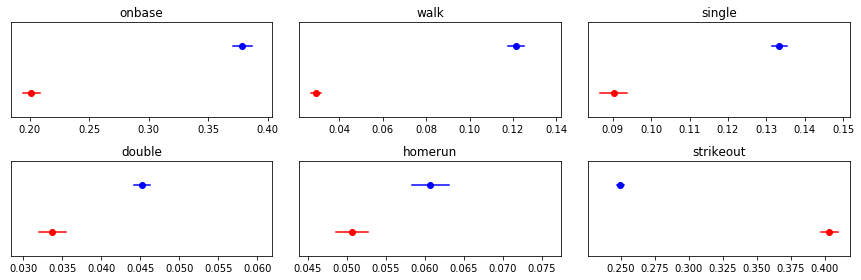

<IPython.core.display.Javascript object>

In [865]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 4))

create_figure("onbase", ax1, df_summary_prediction_onbase)
create_figure("walk", ax2, df_summary_prediction_walk)
create_figure("single", ax3, df_summary_prediction_single)
create_figure("double", ax4, df_summary_prediction_double)
create_figure("homerun", ax5, df_summary_prediction_homerun)
create_figure("strikeout", ax6, df_summary_prediction_strikeout)

plt.tight_layout()


dir_path = "./flaskexample/static/bp_hist/"
plt.savefig(dir_path + "matchup_results_fig.png")
matchup_results_fig = dir_path + "matchup_results_fig.png"

## Histogram of batter, pitcher performance against all

In [ ]:
#df_summary_prediction = get_prediction_se_obs(X_4ols, y_4ols, X_new4ols, y_new4ols)

# Addressing other questions

In [429]:
df_sc_all_preprocess_wbat_wpitch.head()

batter   pitcher     events stand p_throws  inning_topbot  \
0       150029.0  544727.0  field_out     R        R              0   
27772   150029.0  544727.0     single     R        R              1   
28866   150029.0  544727.0     single     R        R              1   
155920  150029.0  544727.0  field_out     R        R              0   
158235  150029.0  544727.0  field_out     R        R              0   

        onbase_event  walk_event  single_event  double_event  ...  \
0                  0           0             0             0  ...   
27772              1           0             1             0  ...   
28866              1           0             1             0  ...   
155920             0           0             0             0  ...   
158235             0           0             0             0  ...   

        prop_triple_event_stand_same  prop_homerun_event_stand_same  \
0                         0.00139665                      0.0125698   
27772                     0.00139665                      0.0125698   
28866                     0.00139665                      0.0125698   
155920                    0.00139665                      0.0125698   
158235                    0.00139665                      0.0125698   

        prop_strikeout_event_stand_same  prop_onbase_event_stand_diff  \
0                              0.287709                      0.318644   
27772                          0.287709                      0.318644   
28866                          0.287709                      0.318644   
155920                         0.287709                      0.318644   
158235                         0.287709                      0.318644   

        prop_walk_event_stand_diff  prop_single_event_stand_diff  \
0                        0.0932203                      0.154237   
27772                    0.0932203                      0.154237   
28866                    0.0932203                      0.154237   
155920                   0.0932203                      0.154237   
158235                   0.0932203                      0.154237   

        prop_double_event_stand_diff  prop_triple_event_stand_diff  \
0                          0.0474576                    0.00338983   
27772                      0.0474576                    0.00338983   
28866                      0.0474576                    0.00338983   
155920                     0.0474576                    0.00338983   
158235                     0.0474576                    0.00338983   

        prop_homerun_event_stand_diff prop_strikeout_event_stand_diff  
0                           0.0152542                        0.225424  
27772                       0.0152542                        0.225424  
28866                       0.0152542                        0.225424  
155920                      0.0152542                        0.225424  
158235                      0.0152542                        0.225424  

[5 rows x 96 columns]

<IPython.core.display.Javascript object>

In [431]:
len(df_sc_all_preprocess_wbat_wpitch["batter"].unique())

315

<IPython.core.display.Javascript object>

In [482]:
df_sc_all_preprocess_wbat_wpitch.shape

(324806, 96)

<IPython.core.display.Javascript object>

In [483]:
df_temp = df_sc_all_preprocess_wbat_wpitch.copy()  # .iloc[0:10, :]

<IPython.core.display.Javascript object>

## Batter characteristics

In [486]:
batter_list = list()
no_unique_pitchers_list = list()
no_at_bats_list = list()
avg_opp_pitcher_list = list()
sd_opp_pitcher_list = list()

for batter in df_temp["batter"].unique():
    df_batter = df_temp.loc[df_temp["batter"] == batter, :]
    # print(batter, df_batter.shape)
    batter_list.append(batter)
    no_unique_pitchers_list.append(len(df_batter["pitcher"].unique()))
    avg_opp_pitcher_list.append(df_batter["prop_onbase_event_overall_y"].mean())
    try:
        sd_opp_pitcher = df_batter["prop_onbase_event_overall_y"].std()
    except:
        sd_opp_pitcher = None

    sd_opp_pitcher_list.append(sd_opp_pitcher)

df_batter_unique_pitchers = pd.DataFrame(
    {
        "batter_list": batter_list,
        "no_unique_pitchers_list": no_unique_pitchers_list,
        "avg_OBP_pitcher": avg_opp_pitcher_list,
        "sd_OBP_pitcher": sd_opp_pitcher_list,
    }
)

<IPython.core.display.Javascript object>

In [867]:
df_batter.head()

batter   pitcher     events stand p_throws  inning_topbot  \
883575  607387.0  543272.0  strikeout     R        L              1   
886642  607387.0  543272.0  strikeout     R        L              0   
180793  607387.0  461325.0     double     R        R              0   
541282  607387.0  461325.0  strikeout     R        R              1   
261829  607387.0  407793.0  field_out     R        R              0   

        onbase_event  walk_event  single_event  double_event  ...  \
883575             0           0             0             0  ...   
886642             0           0             0             0  ...   
180793             1           0             0             1  ...   
541282             0           0             0             0  ...   
261829             0           0             0             0  ...   

        prop_triple_event_stand_same  prop_homerun_event_stand_same  \
883575                    0.00390625                       0.015625   
886642                    0.00390625                       0.015625   
180793                     0.0027894                      0.0432357   
541282                     0.0027894                      0.0432357   
261829                    0.00155521                      0.0326594   

        prop_strikeout_event_stand_same  prop_onbase_event_stand_diff  \
883575                          0.34375                      0.318512   
886642                          0.34375                      0.318512   
180793                         0.269177                      0.251185   
541282                         0.269177                      0.251185   
261829                         0.250389                      0.326905   

        prop_walk_event_stand_diff  prop_single_event_stand_diff  \
883575                   0.0725953                      0.153358   
886642                   0.0725953                      0.153358   
180793                   0.0774092                     0.0947867   
541282                   0.0774092                     0.0947867   
261829                   0.0844812                      0.155188   

        prop_double_event_stand_diff  prop_triple_event_stand_diff  \
883575                     0.0444646                    0.00181488   
886642                     0.0444646                    0.00181488   
180793                     0.0394945                    0.00315956   
541282                     0.0394945                    0.00315956   
261829                     0.0394858                    0.00367309   

        prop_homerun_event_stand_diff prop_strikeout_event_stand_diff  
883575                      0.0281307                         0.26588  
886642                      0.0281307                         0.26588  
180793                       0.028436                        0.255924  
541282                       0.028436                        0.255924  
261829                      0.0348944                        0.166208  

[5 rows x 96 columns]

<IPython.core.display.Javascript object>

In [487]:
df_batter_unique_pitchers

batter_list  no_unique_pitchers_list  avg_OBP_pitcher  sd_OBP_pitcher
0       150029.0                      125         0.311050        0.021803
1       547180.0                      188         0.308814        0.021571
2       607208.0                      158         0.310023        0.021629
3       543685.0                      179         0.309101        0.021538
4       502517.0                      183         0.307705        0.022692
..           ...                      ...              ...             ...
310     425902.0                      121         0.310861        0.020429
311     455759.0                      112         0.310699        0.021281
312     607345.0                      108         0.305070        0.022449
313     571602.0                      129         0.306342        0.020103
314     607387.0                       85         0.306167        0.021435

[315 rows x 4 columns]

<IPython.core.display.Javascript object>

In [495]:
print(
    "mean +/- SD: ",
    df_batter_unique_pitchers["no_unique_pitchers_list"].mean(),
    df_batter_unique_pitchers["no_unique_pitchers_list"].std(),
)

mean +/- SD:  159.14920634920634 28.940086765239272


<IPython.core.display.Javascript object>

Text(0.5, 0, 'No. of unique pitchers')

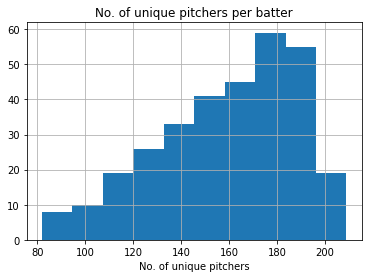

<IPython.core.display.Javascript object>

In [490]:
f, ax1 = plt.subplots()
df_batter_unique_pitchers["no_unique_pitchers_list"].hist(ax=ax1)
ax1.set_title("No. of unique pitchers per batter")
ax1.set_xlabel("No. of unique pitchers")

<BarContainer object of 315 artists>

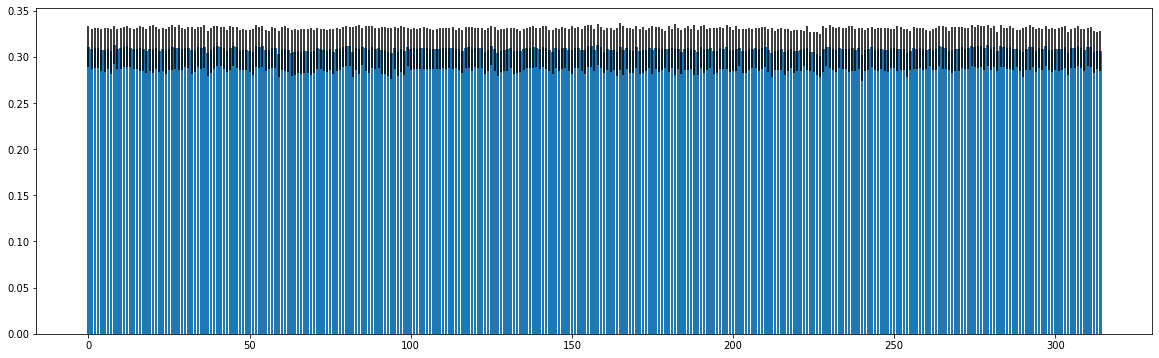

<IPython.core.display.Javascript object>

In [866]:
f, ax1 = plt.subplots(figsize=(20, 6))
ax1.bar(
    df_batter_unique_pitchers.index,
    df_batter_unique_pitchers["avg_OBP_pitcher"],
    yerr=df_batter_unique_pitchers["sd_OBP_pitcher"],
)

# df_batter_unique_pitchers["no_unique_pitchers_list"].hist(ax=ax1)
# ax1.set_title("No. of unique pitchers per batter")
# ax1.set_xlabel("No. of unique pitchers")

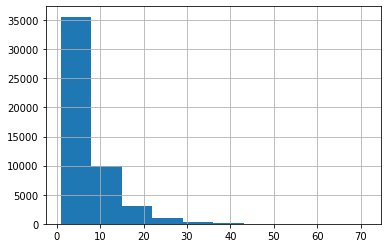

<IPython.core.display.Javascript object>

In [452]:
df_temp.hist()

## Pitcher characteristics

In [511]:
pitcher_list = list()
no_unique_batters_list = list()
no_at_bats_list = list()
avg_opp_batter_list = list()
sd_opp_batter_list = list()

for pitcher in df_temp["pitcher"].unique():
    df_pitcher = df_temp.loc[df_temp["pitcher"] == pitcher, :]
    # print(pitcher, df_pitcher.shape)
    pitcher_list.append(pitcher)
    no_unique_batters_list.append(len(df_pitcher["batter"].unique()))
    avg_opp_batter_list.append(df_pitcher["prop_onbase_event_overall_x"].mean())
    try:
        sd_opp_batter = df_pitcher["prop_onbase_event_overall_x"].std()
    except:
        sd_opp_batter = None

    sd_opp_batter_list.append(sd_opp_batter)

df_pitcher_unique_batters = pd.DataFrame(
    {
        "pitcher_list": pitcher_list,
        "no_unique_batters_list": no_unique_batters_list,
        "avg_OBP_batter": avg_opp_batter_list,
        "sd_OBP_batter": sd_opp_batter_list,
    }
)

<IPython.core.display.Javascript object>

In [516]:
df_temp.shape

(324806, 96)

<IPython.core.display.Javascript object>

In [515]:
len(df_temp["pitcher"].unique())

230

<IPython.core.display.Javascript object>

In [519]:
df_temp.head()

batter   pitcher     events stand p_throws  inning_topbot  \
0       150029.0  544727.0  field_out     R        R              0   
27772   150029.0  544727.0     single     R        R              1   
28866   150029.0  544727.0     single     R        R              1   
155920  150029.0  544727.0  field_out     R        R              0   
158235  150029.0  544727.0  field_out     R        R              0   

        onbase_event  walk_event  single_event  double_event  ...  \
0                  0           0             0             0  ...   
27772              1           0             1             0  ...   
28866              1           0             1             0  ...   
155920             0           0             0             0  ...   
158235             0           0             0             0  ...   

        prop_triple_event_stand_same  prop_homerun_event_stand_same  \
0                         0.00139665                      0.0125698   
27772                     0.00139665                      0.0125698   
28866                     0.00139665                      0.0125698   
155920                    0.00139665                      0.0125698   
158235                    0.00139665                      0.0125698   

        prop_strikeout_event_stand_same  prop_onbase_event_stand_diff  \
0                              0.287709                      0.318644   
27772                          0.287709                      0.318644   
28866                          0.287709                      0.318644   
155920                         0.287709                      0.318644   
158235                         0.287709                      0.318644   

        prop_walk_event_stand_diff  prop_single_event_stand_diff  \
0                        0.0932203                      0.154237   
27772                    0.0932203                      0.154237   
28866                    0.0932203                      0.154237   
155920                   0.0932203                      0.154237   
158235                   0.0932203                      0.154237   

        prop_double_event_stand_diff  prop_triple_event_stand_diff  \
0                          0.0474576                    0.00338983   
27772                      0.0474576                    0.00338983   
28866                      0.0474576                    0.00338983   
155920                     0.0474576                    0.00338983   
158235                     0.0474576                    0.00338983   

        prop_homerun_event_stand_diff prop_strikeout_event_stand_diff  
0                           0.0152542                        0.225424  
27772                       0.0152542                        0.225424  
28866                       0.0152542                        0.225424  
155920                      0.0152542                        0.225424  
158235                      0.0152542                        0.225424  

[5 rows x 96 columns]

<IPython.core.display.Javascript object>

In [523]:
df_temp.groupby("pitcher").count()["events"].std()

569.4809741445835

<IPython.core.display.Javascript object>

In [512]:
df_pitcher_unique_batters

pitcher_list  no_unique_batters_list  avg_OBP_batter  sd_OBP_batter
0        544727.0                     229        0.327898       0.027869
1        594798.0                     231        0.331061       0.027507
2        592789.0                     214        0.330694       0.029016
3        429719.0                     244        0.328455       0.027201
4        605538.0                     223        0.326501       0.028295
..            ...                     ...             ...            ...
225      460059.0                     186        0.323797       0.026821
226      533167.0                     187        0.323085       0.025538
227      607259.0                     162        0.326595       0.029372
228      605135.0                     159        0.324967       0.028504
229      407890.0                     107        0.323541       0.029708

[230 rows x 4 columns]

<IPython.core.display.Javascript object>

In [513]:
print(
    "mean +/- SD: ",
    df_pitcher_unique_batters["no_unique_batters_list"].mean(),
    df_pitcher_unique_batters["no_unique_batters_list"].std(),
)

mean +/- SD:  217.96521739130435 34.04439188689038


<IPython.core.display.Javascript object>

Text(0.5, 0, 'No. of unique batters')

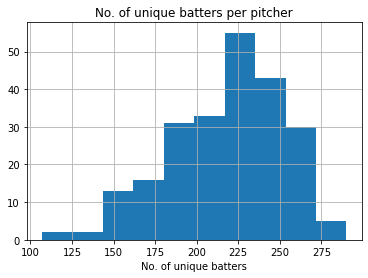

<IPython.core.display.Javascript object>

In [524]:
f, ax1 = plt.subplots()
df_pitcher_unique_batters["no_unique_batters_list"].hist(ax=ax1)
ax1.set_title("No. of unique batters per pitcher")
ax1.set_xlabel("No. of unique batters")

In [529]:
df_pitcher_unique_batters.index[0:n_bars]

RangeIndex(start=0, stop=100, step=1)

<IPython.core.display.Javascript object>

<BarContainer object of 100 artists>

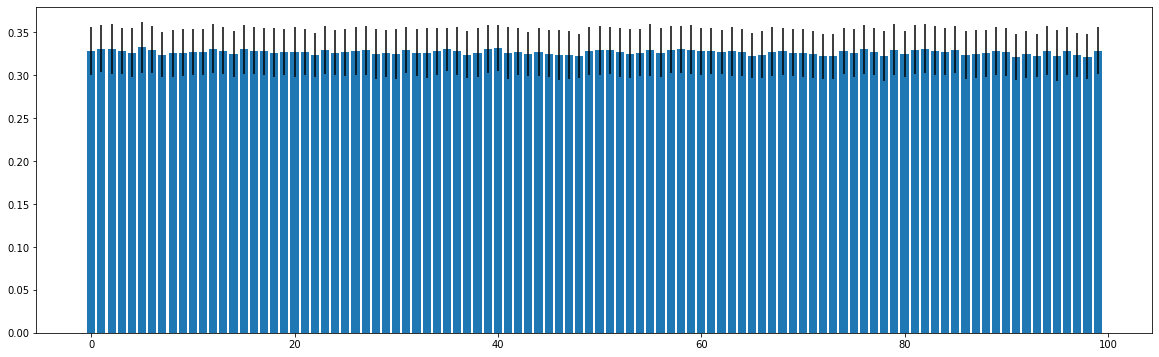

<IPython.core.display.Javascript object>

In [530]:
f, ax1 = plt.subplots(figsize=(20, 6))
n_bars = 100

ax1.bar(
    df_pitcher_unique_batters.index[0:n_bars],
    df_pitcher_unique_batters["avg_OBP_batter"].iloc[0:n_bars],
    yerr=df_pitcher_unique_batters["sd_OBP_batter"].iloc[0:n_bars],
)

# df_batter_unique_pitchers["no_unique_pitchers_list"].hist(ax=ax1)
# ax1.set_title("No. of unique pitchers per batter")
# ax1.set_xlabel("No. of unique pitchers")

## Feature and target construction

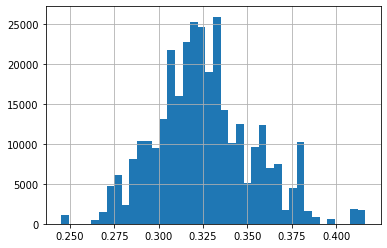

<IPython.core.display.Javascript object>

In [533]:
df_temp["prop_onbase_event_overall_x"].hist(bins=40)

# Validating model with player pairs

# Finding correlations with contacted balls

In [534]:
df_batting1519agg_200pa.head()

Season          Name       Team   Age      G     AB     PA      H     1B  \
1   2018.0  Mookie Betts    Red Sox  25.0  136.0  520.0  614.0  180.0   96.0   
2   2018.0    Mike Trout     Angels  26.0  140.0  471.0  608.0  147.0   80.0   
16  2016.0    Mike Trout     Angels  24.0  159.0  549.0  681.0  173.0  107.0   
0   2015.0  Bryce Harper  Nationals  22.0  153.0  521.0  654.0  172.0   91.0   
22  2015.0    Mike Trout     Angels  23.0  159.0  575.0  682.0  172.0   93.0   

      2B  ...  wSL/C (pi)  wXX/C (pi)  O-Swing% (pi)  Z-Swing% (pi)  \
1   47.0  ...        1.93         NaN          0.185          0.535   
2   24.0  ...        2.55       -5.67          0.198          0.555   
16  32.0  ...       -0.40       -5.63          0.235          0.570   
0   38.0  ...        2.70         NaN          0.281          0.677   
22  32.0  ...        0.26       -1.68          0.247          0.531   

    Swing% (pi)  O-Contact% (pi)  Z-Contact% (pi)  Contact% (pi)  Zone% (pi)  \
1         0.356            0.658            0.926          0.855       0.490   
2         0.376            0.660            0.903          0.839       0.498   
16        0.388            0.708            0.864          0.813       0.457   
0         0.446            0.588            0.846          0.751       0.417   
22        0.381            0.660            0.875          0.801       0.470   

    Pace (pi)  
1        23.3  
2        23.3  
16       23.3  
0        24.4  
22       23.3  

[5 rows x 287 columns]

<IPython.core.display.Javascript object>

In [537]:
[print(i, col) for i, col in enumerate(df_batting1519agg_200pa.columns)]

0 Season
1 Name
2 Team
3 Age
4 G
5 AB
6 PA
7 H
8 1B
9 2B
10 3B
11 HR
12 R
13 RBI
14 BB
15 IBB
16 SO
17 HBP
18 SF
19 SH
20 GDP
21 SB
22 CS
23 AVG
24 GB
25 FB
26 LD
27 IFFB
28 Pitches
29 Balls
30 Strikes
31 IFH
32 BU
33 BUH
34 BB%
35 K%
36 BB/K
37 OBP
38 SLG
39 OPS
40 ISO
41 BABIP
42 GB/FB
43 LD%
44 GB%
45 FB%
46 IFFB%
47 HR/FB
48 IFH%
49 BUH%
50 wOBA
51 wRAA
52 wRC
53 Bat
54 Fld
55 Rep
56 Pos
57 RAR
58 WAR
59 Dol
60 Spd
61 wRC+
62 WPA
63 -WPA
64 +WPA
65 RE24
66 REW
67 pLI
68 phLI
69 PH
70 WPA/LI
71 Clutch
72 FB% (Pitch)
73 FBv
74 SL%
75 SLv
76 CT%
77 CTv
78 CB%
79 CBv
80 CH%
81 CHv
82 SF%
83 SFv
84 KN%
85 KNv
86 XX%
87 PO%
88 wFB
89 wSL
90 wCT
91 wCB
92 wCH
93 wSF
94 wKN
95 wFB/C
96 wSL/C
97 wCT/C
98 wCB/C
99 wCH/C
100 wSF/C
101 wKN/C
102 O-Swing%
103 Z-Swing%
104 Swing%
105 O-Contact%
106 Z-Contact%
107 Contact%
108 Zone%
109 F-Strike%
110 SwStr%
111 BsR
112 FA% (pfx)
113 FT% (pfx)
114 FC% (pfx)
115 FS% (pfx)
116 FO% (pfx)
117 SI% (pfx)
118 SL% (pfx)
119 CU% (pfx)
120 KC% (pfx)
121 EP%

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

<IPython.core.display.Javascript object>

In [538]:
df_batting18agg_200pa = df_batting1519agg_200pa[
    df_batting1519agg_200pa["Season"] == 2018
].copy()

<IPython.core.display.Javascript object>

In [539]:
df_batting18agg_200pa.shape

(355, 287)

<IPython.core.display.Javascript object>

In [573]:
# calculate the correlation matrix - try 4 to 111

my_matrix = df_batting18agg_200pa.iloc[:, 4:111]
my_matrix.drop(["Dol", "PO%"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [560]:
for i, col in enumerate(my_matrix.columns):
    print(col, my_matrix.loc[1, col])

G 136.0
AB 520.0
PA 614.0
H 180.0
1B 96.0
2B 47.0
3B 5.0
HR 32.0
R 129.0
RBI 80.0
BB 81.0
IBB 8.0
SO 91.0
HBP 8.0
SF 5.0
SH 0.0
GDP 5.0
SB 30.0
CS 6.0
AVG 0.346
GB 147.0
FB 195.0
LD 92.0
IFFB 18.0
Pitches 2582.0
Balls 1095.0
Strikes 1487.0
IFH 14.0
BU 0.0
BUH 0.0
BB% 0.132
K% 0.14800000000000002
BB/K 0.89
OBP 0.438
SLG 0.64
OPS 1.078
ISO 0.294
BABIP 0.368
GB/FB 0.0075
LD% 0.212
GB% 0.33899999999999997
FB% 0.449
IFFB% 0.092
HR/FB 0.16399999999999998
IFH% 0.095
BUH% 0.0
wOBA 0.449
wRAA 67.2
wRC 139.0
Bat 62.3
Fld 16.8
Rep 18.4
Pos -5.3
RAR 101.1
WAR 10.4
Spd 7.0
wRC+ 185.0
WPA 5.77
-WPA -8.16
+WPA 13.93
RE24 62.93
REW 6.11
pLI 0.92
phLI 3.62
PH 4.0
WPA/LI 6.44
Clutch -0.15
FB% (Pitch) 0.547
FBv 93.2
SL% 0.19899999999999998
SLv 84.5
CT% 0.05
CTv 88.7
CB% 0.073
CBv 79.1
CH% 0.114
CHv 84.4
SF% 0.017
SFv 85.4
KN% nan
KNv nan
XX% 0.009000000000000001
PO% nan
wFB 40.1
wSL 11.2
wCT 4.2
wCB 1.1
wCH 11.1
wSF 2.3
wKN nan
wFB/C 2.84
wSL/C 2.19
wCT/C 3.28
wCB/C 0.58
wCH/C 3.79
wSF/C 5.06
wKN/C nan
O

<IPython.core.display.Javascript object>

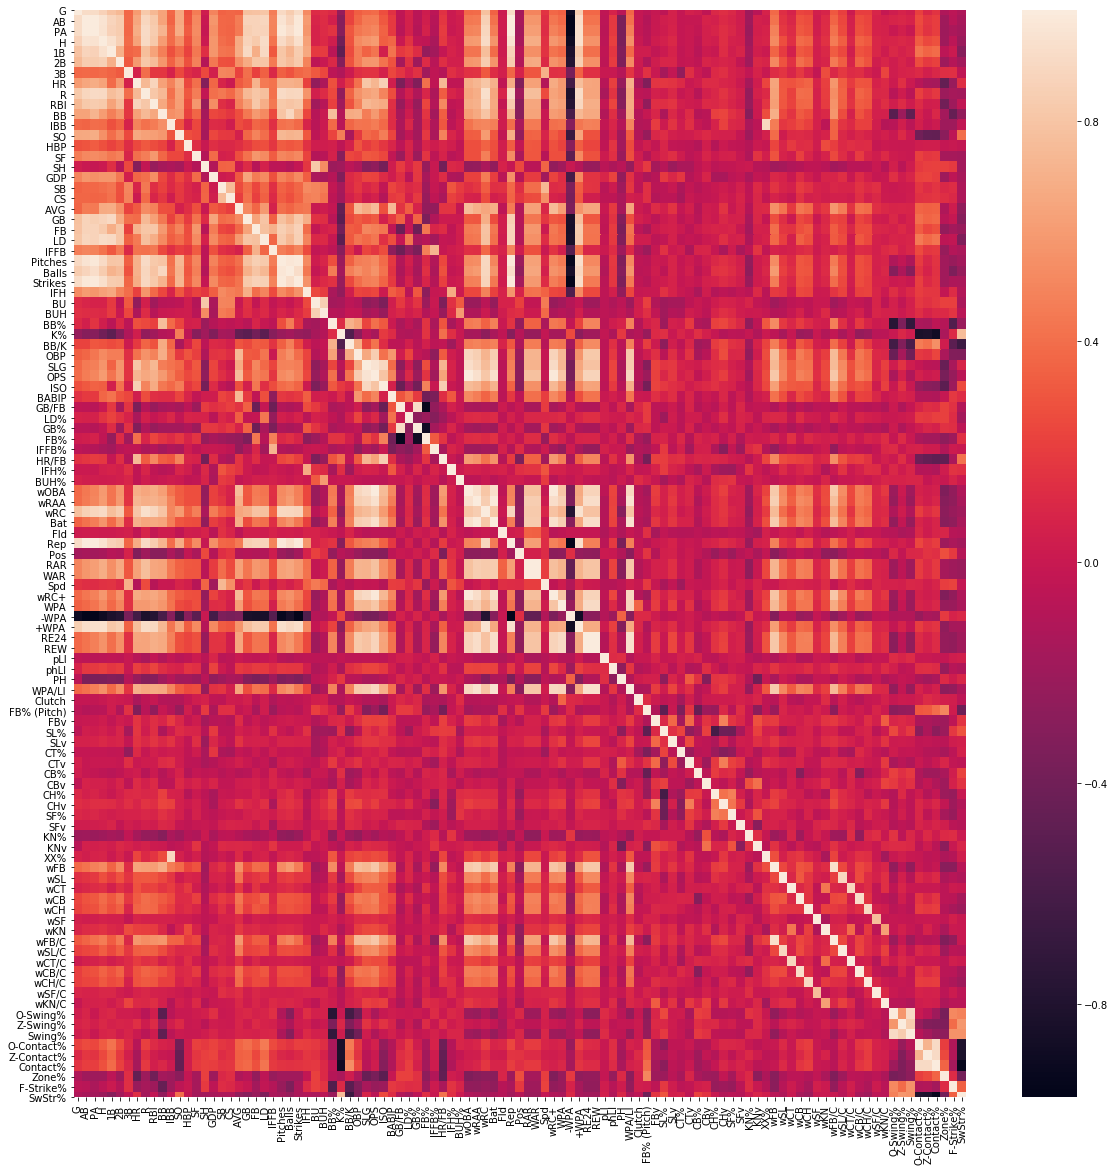

<IPython.core.display.Javascript object>

In [574]:
corr = my_matrix.corr()

# plot the heatmap
f, ax1 = plt.subplots(figsize=(20, 20))

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, ax=ax1)

In [550]:
from sklearn import preprocessing

<IPython.core.display.Javascript object>

In [575]:
min_max_scaler = preprocessing.MinMaxScaler()
my_matrix_minmax = min_max_scaler.fit_transform(my_matrix)

<IPython.core.display.Javascript object>

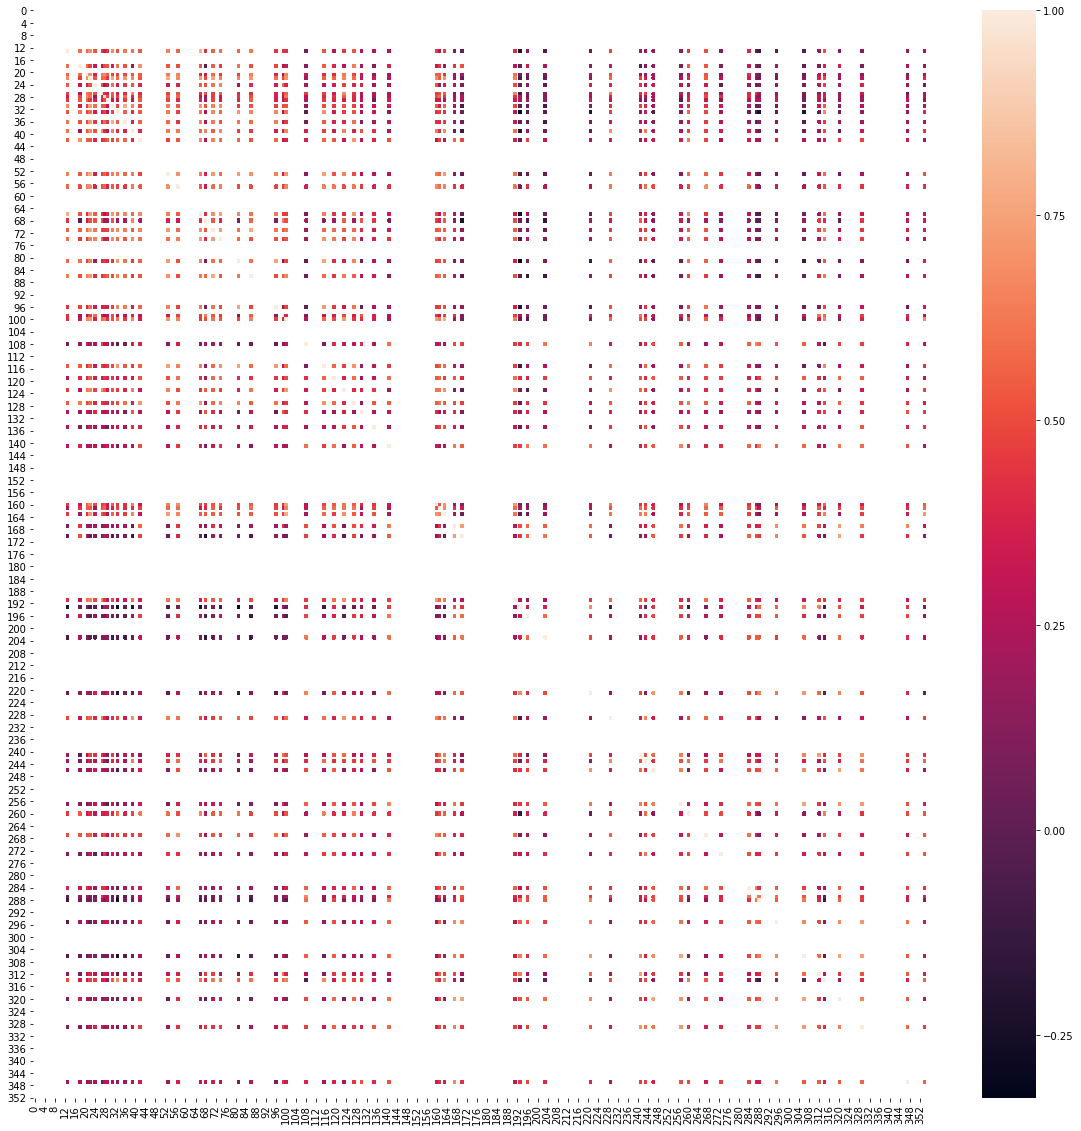

<IPython.core.display.Javascript object>

In [576]:
corr = np.corrcoef(my_matrix_minmax)

# plot the heatmap
f, ax1 = plt.subplots(figsize=(20, 20))

# sns.heatmap(corr, xticklabels=my_matrix.columns, yticklabels=my_matrix.columns, ax=ax1)
sns.heatmap(corr, ax=ax1)